# Characterizing Patronage on YouTube

### Libaries imports

In [1]:
import math
import pickle
import warnings

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm.notebook import tqdm
from tableone import TableOne

### Paths to data folders

In [2]:
# data folder paths
DATA_FOLDER = "/dlabdata1/youtube_large/"
LOCAL_DATA_FOLDER = "local_data/"

## 1. Load data

### 1.0 Preprocessing

#### Original datasets

This is the list of the original YouNiverse and Graphteon datasets:

**YouNiverse dataset:**

- `df_channels_en.tsv.gz`: channel metadata.
- `df_timeseries_en.tsv.gz`: channel-level time-series.
- `yt_metadata_en.jsonl.gz`: raw video metadata.

**Graphteon dataset:**
- `final_processed_file.jsonl.gz` all graphteon time-series.


---
#### Preprocessed datasets

After processing the above datasets in the _preprocessing_ notebook, we obtain the following preprocessed datasets, which we'll use in this notebook:

**YouNiverse dataset:**

- `df_yt_timeseries_restricted.tsv.gz`: channel-level time-series after having applied 4 filters:
    - _YouTube channels that are linked to a Patreon account_; _at least two years between first and last video_; _at least 20 videos with Patreon ids_; and _at least 250k subscribers at data crawling time_
- `yt_metadata_en.jsonl.gz`: raw video metadata restricted to videos referencing Patreon accounts, and channels that exist in the restricted YouTube time series

**Graphteon dataset:**
- `dailyGraph_patrons_and_earnings_Series.tsv.gz` extracted patrons and earnings time series.

**New dataset:**
- `df_linked_channels_patreons`: matches exactly 1 Patreon id to 1 YouTube channel.


### 1.1. Load YouTube metadata
_In the preprocessing phase, we extracted Patreon urls from YouTube metadata description (if they existed) and kept only those rows_

In [3]:
# YT metadata containing patreon ids in description
!ls -lh {LOCAL_DATA_FOLDER}yt_metadata_en_restricted.tsv.gz

-rw-r--r-- 1 fmurray 30064 91M Jun  7 22:12 local_data/yt_metadata_en_restricted.tsv.gz


In [4]:
# read filtered and restricted youtube metadata file (takes about 10 seconds)
yt_metadata_en_restricted = pd.read_csv(LOCAL_DATA_FOLDER+"yt_metadata_en_restricted.tsv.gz", sep="\t", lineterminator='\n', compression='gzip') 
yt_metadata_en_restricted['crawl_date'] = pd.to_datetime(yt_metadata_en_restricted['crawl_date'])
yt_metadata_en_restricted['upload_date'] = pd.to_datetime(yt_metadata_en_restricted['upload_date'])
yt_metadata_en_restricted.head()

categories                channel_id                 crawl_date  \
0  Pets & Animals  UCzV_hd9M_7UBEVrGLUJu-2Q 2019-11-01 20:32:01.795199   
1   Howto & Style  UCzV_hd9M_7UBEVrGLUJu-2Q 2019-11-01 20:32:02.393862   
2  People & Blogs  UCzV_hd9M_7UBEVrGLUJu-2Q 2019-11-01 20:32:02.989359   
3  Pets & Animals  UCzV_hd9M_7UBEVrGLUJu-2Q 2019-11-01 20:32:03.668560   
4  Pets & Animals  UCzV_hd9M_7UBEVrGLUJu-2Q 2019-11-01 20:32:04.351296   

                                         description  dislike_count  \
0  You may send your support through the link pro...           38.0   
1  DUCK FARMING & LAYER POULTRY - How to become s...          112.0   
2  You may send your support through the link pro...           51.0   
3  You may send your support through the link pro...           53.0   
4  You may send your support through the link pro...           38.0   

    display_id  duration  like_count  \
0  jjzo_piP2L4       734      1204.0   
1  2azTtWzYYBU       776      1546.0   
2  ZFHGPSFJSIg       706      1114.0   
3  HNMPkSLDg1k       687      1640.0   
4  9HVa0Lh1omI       619      1057.0   

                                                tags  \
0  Fish breeding,Fish rescue,Fish feeding,Exotic ...   
1  duck farm,poultry farm,layer ducks,ducklings,d...   
2  Fish breeding,Fish rescue,Fish feeding,Exotic ...   
3  Fish breeding,Fish rescue,Fish feeding,rare fi...   
4  Fish breeding,Fish rescue,Fish feeding,Exotic ...   

                                               title upload_date  view_count  \
0          TOO MUCH CHANGES ARE HAPPENING IN MY FARM  2019-10-02     39631.0   
1  HOW TO BECOME SUCCESSFUL IN RAISING DUCKS & CH...  2019-09-29     89838.0   
2   I STOCK MY POND WITH NEW FISH (  GROW OUT TANK )  2019-09-27     54902.0   
3                      ALL MY EXOTIC LIVEBEARER FISH  2019-09-22     64776.0   
4                             HOW I TRANSFER MY FISH  2019-09-19     44491.0   

                 patreon_id  
0  patreon.com/dextersworld  
1  patreon.com/dextersworld  
2  patreon.com/dextersworld  
3  patreon.com/dextersworld  
4  patreon.com/dextersworld

#### YouTube Metadata statistics

In [5]:
# declare global variable for size of original YT dataset
DF_YT_METADATA_ROWS = 72_924_794

# stats 
print("Videos:")
print("[Original YouTube metadata] Total number of videos:                                             {:>10,}".format(DF_YT_METADATA_ROWS))
print("[Filtered YouTube metadata] Number of videos that contain a valid patreon link in description \n \
                           and match the channels of the restricted timeseries:                {:>10,} ({:.1%} of total dataset)".format(len(yt_metadata_en_restricted), len(yt_metadata_en_restricted)/DF_YT_METADATA_ROWS))


# get list of all unique patreon ids in yt_metadata_en_restricted
yt_patreon_list = yt_metadata_en_restricted['patreon_id'].unique()
yt_pt_channel_list = yt_metadata_en_restricted['channel_id'].unique()
print("\nChannels:")
print("[Filtered YouTube metadata] Total number of unique patreon ids:                                 {:>9,}".format(len(yt_patreon_list)))
print("[Filtered YouTube metadata] Number of unique channels that contain a valid patreon account:     {:>9,}".format(len(yt_pt_channel_list)))

Videos:
[Original YouTube metadata] Total number of videos:                                             72,924,794
[Filtered YouTube metadata] Number of videos that contain a valid patreon link in description 
                            and match the channels of the restricted timeseries:                   405,534 (0.6% of total dataset)

Channels:
[Filtered YouTube metadata] Total number of unique patreon ids:                                     1,456
[Filtered YouTube metadata] Number of unique channels that contain a valid patreon account:         1,456


### 1.2 Load "Link" dataframe (channel/patreon)
This dataframe gives the correspondence between `channel_id` and `patreon_id`

In [6]:
!ls -lh {LOCAL_DATA_FOLDER}df_linked_channels_patreons.tsv.gz

-rw-r--r-- 1 fmurray 30064 437K Jun  7 20:20 local_data/df_linked_channels_patreons.tsv.gz


In [7]:
df_linked_channels_patreons = pd.read_csv(LOCAL_DATA_FOLDER+"df_linked_channels_patreons.tsv.gz", sep="\t", compression="gzip")
df_linked_channels_patreons.head()

channel_id                    patreon_id
0  UC--24Q3_ZQeFmgJE-Um5QZQ        patreon.com/sailoralex
1  UC--70ql_IxJmhmqXqrkJrWQ        patreon.com/dakotawint
2  UC--94OGFAzYDOJb0eXgMjew  patreon.com/sailorjerrimusic
3  UC--SaadDxRXz729rtbQqyBA            patreon.com/djbit3
4  UC--e1G28Uhx1XL4na8uxIhA          patreon.com/zorosoro

In [8]:
print(f"Number of linked patreon_ids and channel_ids: {len(df_linked_channels_patreons):,}")

Number of linked patreon_ids and channel_ids: 17,238


### 1.3 Load YouTube timeseries
_In the preprocessing phase, the YouTube channels have been restricted / filtered according to the following criteria (filters were applied sequentially):_
- Filter 1: Keep only YouTube channels that are in YouTube Timeseries dataset AND linked to a patreon account 
- Filter 2: At least 2 year between first and last video
- Filter 3: At least 20 videos with patreon ids
- Filter 4: At least 250k subscribers at data crawling time

In [9]:
!ls -lh {LOCAL_DATA_FOLDER}df_yt_timeseries_restricted.tsv.gz

-rw-r--r-- 1 fmurray 30064 6.5M Jun  7 22:09 local_data/df_yt_timeseries_restricted.tsv.gz


In [10]:
# load restricted channel-level time-series.
df_yt_timeseries_restricted = pd.read_csv(LOCAL_DATA_FOLDER+'df_yt_timeseries_restricted.tsv.gz', sep="\t", compression='gzip', parse_dates=['datetime'])

# replace dates that were collected after 23:00 to their next day, and remove hour (+ backup original column)
df_yt_timeseries_restricted['datetime'] = df_yt_timeseries_restricted['datetime'].apply(lambda date: (date + pd.DateOffset(days=1)) if date.hour >= 23 else date) 

# remove hours and convert to datetime type
df_yt_timeseries_restricted['datetime'] = pd.to_datetime(df_yt_timeseries_restricted['datetime'].dt.date)

# add patreon_id column to YT timeseries
df_yt_timeseries_restricted_merged = df_yt_timeseries_restricted.merge(df_linked_channels_patreons, left_on='channel', right_on='channel_id')

df_yt_timeseries_restricted_merged = df_yt_timeseries_restricted_merged.drop(columns=['channel_id'])
df_yt_timeseries_restricted_merged.insert(1, 'patreon_id', df_yt_timeseries_restricted_merged.pop('patreon_id'))
df_yt_timeseries_restricted_merged

channel              patreon_id       category  \
0       UCltVEZ6GecWntoZ19FvaWhQ      patreon.com/ekeeda      Education   
1       UCltVEZ6GecWntoZ19FvaWhQ      patreon.com/ekeeda      Education   
2       UCltVEZ6GecWntoZ19FvaWhQ      patreon.com/ekeeda      Education   
3       UCltVEZ6GecWntoZ19FvaWhQ      patreon.com/ekeeda      Education   
4       UCltVEZ6GecWntoZ19FvaWhQ      patreon.com/ekeeda      Education   
...                          ...                     ...            ...   
223595  UCY6Ij8zOds0WJEeqCLOnqOQ  patreon.com/alexmeyers  Entertainment   
223596  UCY6Ij8zOds0WJEeqCLOnqOQ  patreon.com/alexmeyers  Entertainment   
223597  UCY6Ij8zOds0WJEeqCLOnqOQ  patreon.com/alexmeyers  Entertainment   
223598  UCY6Ij8zOds0WJEeqCLOnqOQ  patreon.com/alexmeyers  Entertainment   
223599  UCY6Ij8zOds0WJEeqCLOnqOQ  patreon.com/alexmeyers  Entertainment   

         datetime         views   delta_views          subs    delta_subs  \
0      2016-10-03  3.190740e+05  0.000000e+00  3.960000e+03      0.000000   
1      2016-10-10  3.472411e+05  2.816712e+04  4.383500e+03    423.500000   
2      2016-10-17  3.817262e+05  3.448512e+04  4.953250e+03    569.750000   
3      2016-10-24  4.469281e+05  6.520188e+04  5.601125e+03    647.875000   
4      2016-10-31  5.109108e+05  6.398266e+04  6.306819e+03    705.693653   
...           ...           ...           ...           ...           ...   
223595 2019-09-02  1.519259e+08  4.517518e+06  1.535577e+06  31061.875000   
223596 2019-09-09  1.554422e+08  3.516317e+06  1.558057e+06  22479.625000   
223597 2019-09-16  1.582264e+08  2.784177e+06  1.568507e+06  10450.125000   
223598 2019-09-23  1.617288e+08  3.502370e+06  1.592500e+06  23992.875000   
223599 2019-09-30  1.668376e+08  5.108808e+06  1.642857e+06  50357.142857   

        videos  delta_videos  activity  
0          665             0        30  
1          669             4        33  
2          675             6        29  
3          681             6        12  
4          682             1        13  
...        ...           ...       ...  
223595     164             1         2  
223596     165             1         2  
223597     166             1         2  
223598     167             1         2  
223599     168             1         2  

[223600 rows x 11 columns]

#### YouTube timeseries statistics

In [11]:
# declare global variable for size of original YT dataset
DF_YT_TIMESERIES_EN_ROWS = 18_872_499
DF_YT_TIMESERIES_EN_UNIQUE_CHANNELS = 133_516

chan_list_restricted = df_yt_timeseries_restricted['channel'].unique()
chan_list_restricted_cnt = len(chan_list_restricted)

# Nb of channels of original YT timeseries dataset
print("[YouTube Timeseries] Number of data points in original dataset:           {:>10,}".format(DF_YT_TIMESERIES_EN_ROWS))
print("[YouTube Timeseries] Number of data points after applying filters:        {:>10,} ({:5.1%} of original dataset)".format(len(df_yt_timeseries_restricted), len(df_yt_timeseries_restricted)/DF_YT_TIMESERIES_EN_ROWS))
print()
print("[YouTube Timeseries] Number of channels of original dataset:              {:>10,}".format(DF_YT_TIMESERIES_EN_UNIQUE_CHANNELS))
print("[YouTube Timeseries] Number of channels after applying filters:           {:>10,} ({:5.1%} of original dataset)".format(chan_list_restricted_cnt, chan_list_restricted_cnt/DF_YT_TIMESERIES_EN_UNIQUE_CHANNELS))
print()
print('[YouTube Timeseries] Time range after applying filters:               {} and {}'.format(df_yt_timeseries_restricted['datetime'].min().strftime('%B %d, %Y'),
                                                              df_yt_timeseries_restricted['datetime'].max().strftime('%B %d, %Y')))

[YouTube Timeseries] Number of data points in original dataset:           18,872,499
[YouTube Timeseries] Number of data points after applying filters:           223,600 ( 1.2% of original dataset)

[YouTube Timeseries] Number of channels of original dataset:                 133,516
[YouTube Timeseries] Number of channels after applying filters:                1,456 ( 1.1% of original dataset)

[YouTube Timeseries] Time range after applying filters:               December 07, 2015 and September 30, 2019


### 1.4 Load Graphtreon dataset
From the original dataset:
- Find corresponding YouTube channel for each patreon (lookup in linked patreon/channel dataset)
- If patreon_id exist in patreons corresponding to the restricted list of channels in YT time series
    - we extract the date and earnings from “dailyGraph_earningsSeriesData” (see preprocessing notebook
    - we extract the date and patrons from “dailyGraph_patronSeriesData” (see preprocessing notebook)
    - we merge those two time series)

In [12]:
!ls -lh {LOCAL_DATA_FOLDER}dailyGraph_patrons_and_earnings_Series.tsv.gz

-rw-r--r-- 1 fmurray 30064 8.7M Apr 30 12:22 local_data/dailyGraph_patrons_and_earnings_Series.tsv.gz


In [13]:
# read merged dailyGraph_patrons_and_earnings_Series from disk
df_dailyGraph_patrons_and_earnings_Series = pd.read_csv(LOCAL_DATA_FOLDER+"dailyGraph_patrons_and_earnings_Series.tsv.gz", sep="\t", compression='gzip')
df_dailyGraph_patrons_and_earnings_Series['date'] = pd.to_datetime(df_dailyGraph_patrons_and_earnings_Series['date'], unit='ms')
df_dailyGraph_patrons_and_earnings_Series['patrons'] = df_dailyGraph_patrons_and_earnings_Series['patrons'].astype('Int64')

#### Remove PT accounts that aren't in linked df

In [14]:
df_dailyGraph_patrons_and_earnings_Series = df_dailyGraph_patrons_and_earnings_Series[df_dailyGraph_patrons_and_earnings_Series['patreon'].isin(df_linked_channels_patreons['patreon_id'])]
df_dailyGraph_patrons_and_earnings_Series.head()

creatorName creatorRange   startDate categoryTitle               patreon  \
0    Fooligan        month  01/22/2018         Video  patreon.com/fooligan   
1    Fooligan        month  01/22/2018         Video  patreon.com/fooligan   
2    Fooligan        month  01/22/2018         Video  patreon.com/fooligan   
3    Fooligan        month  01/22/2018         Video  patreon.com/fooligan   
4    Fooligan        month  01/22/2018         Video  patreon.com/fooligan   

        date  earning  patrons  
0 2018-03-07   191.35       27  
1 2018-03-08   209.32       28  
2 2018-03-09   209.32       28  
3 2018-03-10   209.32       28  
4 2018-03-11   209.32       28

#### Graphtreon timeseries statistics

In [15]:
# RE-declare global variable for size of original GT dataset
GT_final_processed_file_ROWS = 232_269

# group by patreon account, sort by max number of patrons
dailyGraph_grp_patreon = df_dailyGraph_patrons_and_earnings_Series.groupby('patreon').agg(date_cnt=('date', 'count'), earliest_date=('date', 'min'), lastest_date=('date', 'max'),daily_earning_min=('earning', 'min'),daily_earning_max=('earning', 'max'), daily_earning_mean=('earning', 'mean'), daily_patrons_min=('patrons', 'min'), daily_patrons_max=('patrons', 'max'), daily_patrons_mean=('patrons', 'mean')).sort_values(by=['daily_patrons_max'], ascending=False).round(2).reset_index()

print("[Graphtreon Timeseries] Number of patreon ids in original dataset:                                            {:>9,}".format(GT_final_processed_file_ROWS))
print("[Graphtreon Timeseries] Number of patreon ids in dailyGraph patreon + earnings time series + linked df:       {:>9,} ({:.1%} of original dataset)".format(df_dailyGraph_patrons_and_earnings_Series.patreon.nunique(), df_dailyGraph_patrons_and_earnings_Series.patreon.nunique()/GT_final_processed_file_ROWS))


[Graphtreon Timeseries] Number of patreon ids in original dataset:                                              232,269
[Graphtreon Timeseries] Number of patreon ids in dailyGraph patreon + earnings time series + linked df:             746 (0.3% of original dataset)


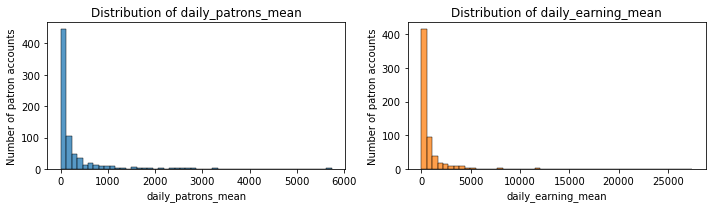

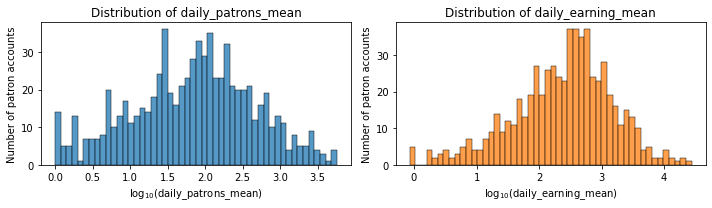

count        mean          std   min    25%      50%  \
daily_patrons_mean  746.0  304.982681   670.448718  1.00  21.15   77.815   
daily_earning_mean  629.0  936.984833  2279.392180  0.85  83.87  309.990   

                         75%       max  
daily_patrons_mean  251.3875   5735.40  
daily_earning_mean  813.0700  27440.71

In [16]:
selected_cols = ['daily_patrons_mean', 'daily_earning_mean']

# plot with log scale for x axis 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.histplot(data=dailyGraph_grp_patreon[col], stat='count', ax=ax, bins=50, kde=False, cumulative=False, color=f'C{i}')
    ax.set(title=f'Distribution of {col}')
    ax.set_ylabel("Number of patron accounts")
plt.tight_layout()
plt.show()

# plot with log scale for x axis 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
xlabels = [r'$\log_{10}($daily_patrons_mean$)$', r'$\log_{10}($daily_earning_mean$)$']
for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.histplot(data=np.log10(dailyGraph_grp_patreon[col]), stat='count', ax=ax, bins=50, kde=False, cumulative=False, color=f'C{i}')
    ax.set(title=f'Distribution of {col}')
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel("Number of patron accounts")
plt.tight_layout()
plt.show()

dailyGraph_grp_patreon.describe()[['daily_patrons_mean', 'daily_earning_mean']].T

### 1.5 Select top patreon accounts (> 200 patrons)
Restrict patreons accounts with mean number of patrons > 200 patrons

In [17]:
MIN_MAX_PATRONS = 200

# remove patrons accounts that have less than MIN_MAX_PATRONS patrons average
top_patreons_df = dailyGraph_grp_patreon[dailyGraph_grp_patreon['daily_patrons_max'] > MIN_MAX_PATRONS]
top_patreons = top_patreons_df['patreon']
df_top_pt_accts = df_dailyGraph_patrons_and_earnings_Series[df_dailyGraph_patrons_and_earnings_Series['patreon'].isin(top_patreons)]

print("[Graphtreon Timeseries] Filtered \"top\" patrons (> {} patrons):  {:>9,} ({:.1%} of original dataset)".format(MIN_MAX_PATRONS, len(top_patreons), len(top_patreons)/GT_final_processed_file_ROWS))

[Graphtreon Timeseries] Filtered "top" patrons (> 200 patrons):        313 (0.1% of original dataset)


#### Filter YT timeseries channels matching top patreon accounts


In [18]:
# filter YT channels matching top patreon accounts
df_yt_timeseries_top_pt = df_yt_timeseries_restricted_merged[df_yt_timeseries_restricted_merged['patreon_id'].isin(top_patreons)].copy()

print(f"Number of YouTube channels before filtering by top patreon accounts: {len(df_yt_timeseries_restricted_merged.patreon_id.unique()):>5}" )
print(f"Number of YouTube channels after  filtering by top patreon accounts: {df_yt_timeseries_top_pt.patreon_id.nunique():>5}" )

Number of YouTube channels before filtering by top patreon accounts:  1456
Number of YouTube channels after  filtering by top patreon accounts:   313


#### Filter YT metadata channels matching top Patreon accounts

In [19]:
# filter accounts that match selected Patreon ids
df_yt_metadata_pt_filtered = yt_metadata_en_restricted[yt_metadata_en_restricted['patreon_id'].isin(top_patreons)].copy()
print(f'Nuber of YouTube metadata videos that match top Patreon ids: {len(df_yt_metadata_pt_filtered):,} ({len(df_yt_metadata_pt_filtered)/len(yt_metadata_en_restricted):.1%} of restricted videos) ')

Nuber of YouTube metadata videos that match top Patreon ids: 106,581 (26.3% of restricted videos) 


## 2. Jointly examine time series related to patronage and YouTube statistics

### 2.1 Detecting bursts (breakpoints) of incoming patrons

In [20]:
def find_breakpoint_v3(df, column, ratio_threshold):
    """
    Scan column of the dataframe until it finds a breakpoint (= increase larger than threshold)
    
    :param df: dataframe
    :param column: column to scan
    :param ratio_threshold: minimum increase ratio threshold 
    """
    i = 0
    df_len = len(df)
    moving_avg_half = 15

    # scan dataset for increase larger than threshold
    for date_index, row in ts_pt_df.iterrows():
        if (i >= (30 + moving_avg_half) and i < df_len-90):
            sub30 = df.iloc[i-30][column]
            point = df.iloc[i][column]
            add30 = df.iloc[i+30][column]
            add60 = df.iloc[i+60][column]
            add90 = df.iloc[i+90][column]

            d1 = point - sub30
            d2 = add30 - point            
            d3 = add60 - add30            
            d4 = add90 - add60            
            
            # avoid  weird ratios obtained by diving by a difference between -1 and 1 
            if (0 <= d1 < 1):
                d1 = 1
            elif (-1 < d1 < 0):
                d1 = -1
        
            r_d1_d2 = d2 / d1

            # at least 10 patrons in the prior period
            if (d1 > 10) & (d2 > d1) & (r_d1_d2 >= ratio_threshold):
                bkpnt_dict = {
                    "bkpt_date"         : df.iloc[i]['date'],
                    "bkpt_date_sub30"   : df.iloc[i-30]['date'],
                    "bkpt_date_add30"   : df.iloc[i+30]['date'],
                    "bkpt_date_add60"   : df.iloc[i+60]['date'],
                    "bkpt_date_add90"   : df.iloc[i+90]['date'],
                    "avg_patrons_bkpnt" : point,
                    "avg_patrons_sub30" : sub30,
                    "avg_patrons_add30" : add30,
                    "avg_patrons_add60" : add60,
                    "avg_patrons_add90" : add90,
                    "d1"                : d1,
                    "d2"                : d2,
                    "d3"                : d3,
                    "d4"                : d4,
                    "r_d1_d2"           : r_d1_d2
                }
                
                return bkpnt_dict
        i = i + 1
    return None

In [21]:
def restrict_acct_and_sort_df(df, patreon_col, patreon_id, date_col):
    """
    Restrict time series to 1 Patreon account only, drop duplicate rows, and sort by ascending dates
    :param df: Time series dataframe with multiple Patreon accounts
    :param patreon_col: Name of column storing Patreon ids
    :param patreon_id: Patreon id we want to keep
    :param date_col: Date column of the dataframe
    :return: Time series with rows corresponding to selected patreon_id only
    """
    restr_df = df[df[patreon_col] == patreon_id].copy()
    restr_df = restr_df.sort_values(by=[date_col])
    restr_df = restr_df.drop_duplicates()
    return restr_df

In [22]:
def restrict_to_overlapping_dates(df1, df2, df1_date_col, df2_date_col):
    """
    Restrict two dataframes to their overlapping dates only
    
    :param df1: Patreon time series
    :param df2: YouTube time series
    :param df1_date_col: Patreon time series date column name
    :param df2_date_col: YouTube time series date column name
    :return: df1 and df2 restricted to overlapping dates only and raise Exception if none exist
    """

   # find min and max dates of both dataframes   
    date_min = max([df1[df1_date_col].min(), df2[df2_date_col].min()])
    date_max = min([df1[df1_date_col].max(), df2[df2_date_col].max()])
    
    # if no overlap period between YT and Patreon datasets, raise exception
    if date_max < date_min:
        raise Exception(f"No overlapping period between timeseries")

    # restrict datasets between min and max dates
    df1 = df1[(df1[df1_date_col] >= date_min) & (df1[df1_date_col] <= date_max)]
    df2 = df2[(df2[df2_date_col] >= date_min) & (df2[df2_date_col] <= date_max)]
    
    # align both dataframes since youtube starts once a week
    df1 = df1[df1[df1_date_col] >= df2[df2_date_col].min()]
    
    return df1, df2, date_min, date_max

#### Find breakpoints for top PT account

In [23]:
INCR_RATIO_THRESH = 3

In [24]:
# # Find breakpoints and store Patreon breakpoints + PT and YT statistics in "df_treated"

# # variables declaration
# ROLLING_AVG_WINDOW = 30
# treated_tuples = []
# no_bkpnt_cnt = 0
# no_overlap = 0



# print(f'Find breakpoints for {len(top_patreons)} patreon accounts...')

# # LOOP OVER TOP PATREON ACCOUNTS
# for idx, patreon in enumerate(tqdm(top_patreons)):
#     treat = None


    

#     ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################

#     # patreon earnings and users
#     tmp_df_pt = restrict_acct_and_sort_df(df_top_pt_accts, 'patreon', patreon, 'date')

#     # youtube videos
#     tmp_df_yt = restrict_acct_and_sort_df(df_yt_timeseries_top_pt, 'patreon_id', patreon, 'datetime')

#     # youtube metadata
#     tmp_df_yt_meta = restrict_acct_and_sort_df(df_yt_metadata_pt_filtered, 'patreon_id', patreon, 'upload_date')
    
    
#     ########################## RESTRICT PATREON AND YOUTUBE TIME SERIES TO OVERLAPPING DATES ##########################
    
#    # if no overlap period between YT and Patreon datasets, raise exception and skip account
#     try: 
#         tmp_df_pt, tmp_df_yt, date_min, date_max = restrict_to_overlapping_dates(tmp_df_pt, tmp_df_yt, 'date', 'datetime')
#     except Exception as e: 
#         print(f"Exception: {patreon} and {yt_channel_id}: {e} --> skipping account")        
#         no_overlap += 1
#         continue
    
#     ########################## PRINT TITLES ##########################
#     # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
#     yt_channel_id = tmp_df_yt['channel'].unique()[0]
#     # print(f"\n\033[1mRank {idx+1}: {patreon[12:]} \033[0m")
    
    
#     ########################## PATREON: CALCULATE MOVING AVERAGE ##########################
    
#     tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
#     tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
#     ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index

    
#     ########################## DETECT BREAKPOINT AND REJECT PATREON ACCOUNT IF NOT VALID ##########################

#     bkpnt_dict = find_breakpoint_v3(tmp_df_pt, 'patrons_ma', INCR_RATIO_THRESH)
#     # print("bkpnt_dict: ", bkpnt_dict)
    
#     if bkpnt_dict == None:
#         no_bkpnt_cnt += 1        
#         # print("No breakpoint for this account...")
#         continue
#     else: 
#         treat = 1


    
#     ########################## PATREON: CALCULATE WEEKLY DELTAS ##########################

#     # resample time series to get 7 days intervals in order to calculate weekly deltas
#     ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
#     ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
#     ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
#     ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
#     tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT
    
#     # reorder columns to have deltas columns next to their respective columns
#     patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
#     ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]
    
#     # convert Float64 columns to float64 to avoid Matplotlib NAType error
#     ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})
    
    
    
#     ################################### CALCULATE MEANS OF DELTA VALUES BEFORE AND AFTER BKPOINT ###################################  


#     ##### PATREON #####
#     tmp_df_PT_sub30 = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= bkpnt_dict['bkpt_date_sub30']) & (ts_pt_weekly_avg_df_float64.index <= bkpnt_dict['bkpt_date'])]
#     tmp_df_PT_add30 = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= bkpnt_dict['bkpt_date']) & (ts_pt_weekly_avg_df_float64.index <= bkpnt_dict['bkpt_date_add30'])]
#     tmp_df_PT_add60 = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= bkpnt_dict['bkpt_date_add30']) & (ts_pt_weekly_avg_df_float64.index <= bkpnt_dict['bkpt_date_add60'])]
#     tmp_df_PT_add90 = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= bkpnt_dict['bkpt_date_add60']) & (ts_pt_weekly_avg_df_float64.index <= bkpnt_dict['bkpt_date_add90'])]

#     # delta patrons
#     mean_delta_patrons_sub30 = tmp_df_PT_sub30['delta_patrons'].mean()
#     mean_delta_patrons_add30 = tmp_df_PT_add30['delta_patrons'].mean()
#     mean_delta_patrons_add60 = tmp_df_PT_add60['delta_patrons'].mean()
#     mean_delta_patrons_add90 = tmp_df_PT_add90['delta_patrons'].mean()
        
#     # delta earnings
#     mean_delta_earnings_sub30 = tmp_df_PT_sub30['delta_earning'].mean()
#     mean_delta_earnings_add30 = tmp_df_PT_add30['delta_earning'].mean()  
#     mean_delta_earnings_add60 = tmp_df_PT_add60['delta_earning'].mean()  
#     mean_delta_earnings_add90 = tmp_df_PT_add90['delta_earning'].mean()  

    
#     ##### YOUTUBE TIME SERIES #####
#     tmp_df_YT_sub30 = tmp_df_yt[(tmp_df_yt['datetime'] >= bkpnt_dict['bkpt_date_sub30']) & (tmp_df_yt['datetime'] <= bkpnt_dict['bkpt_date']      )]
#     tmp_df_YT_add30 = tmp_df_yt[(tmp_df_yt['datetime'] >= bkpnt_dict['bkpt_date']      ) & (tmp_df_yt['datetime'] <= bkpnt_dict['bkpt_date_add30'])]
#     tmp_df_YT_add60 = tmp_df_yt[(tmp_df_yt['datetime'] >= bkpnt_dict['bkpt_date_add30']) & (tmp_df_yt['datetime'] <= bkpnt_dict['bkpt_date_add60'])]
#     tmp_df_YT_add90 = tmp_df_yt[(tmp_df_yt['datetime'] >= bkpnt_dict['bkpt_date_add60']) & (tmp_df_yt['datetime'] <= bkpnt_dict['bkpt_date_add90'])]
    
#     # delta videos
#     mean_delta_videos_sub30 = tmp_df_YT_sub30['delta_videos'].mean()
#     mean_delta_videos_add30 = tmp_df_YT_add30['delta_videos'].mean()  
#     mean_delta_videos_add60 = tmp_df_YT_add60['delta_videos'].mean()  
#     mean_delta_videos_add90 = tmp_df_YT_add90['delta_videos'].mean()  

#     # delta views
#     mean_delta_views_sub30 = tmp_df_YT_sub30['delta_views'].mean()
#     mean_delta_views_add30 = tmp_df_YT_add30['delta_views'].mean()  
#     mean_delta_views_add60 = tmp_df_YT_add60['delta_views'].mean()  
#     mean_delta_views_add90 = tmp_df_YT_add90['delta_views'].mean()  

#     # delta subscriptions
#     mean_delta_subs_sub30 = tmp_df_YT_sub30['delta_subs'].mean()
#     mean_delta_subs_add30 = tmp_df_YT_add30['delta_subs'].mean()  
#     mean_delta_subs_add60 = tmp_df_YT_add60['delta_subs'].mean()  
#     mean_delta_subs_add90 = tmp_df_YT_add90['delta_subs'].mean()  

    
#     ##### YOUTUBE METADATA #####
#     tmp_df_YT_META_sub30 = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= bkpnt_dict['bkpt_date_sub30']) & (tmp_df_yt_meta['upload_date'] <= bkpnt_dict['bkpt_date']      )]
#     tmp_df_YT_META_add30 = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= bkpnt_dict['bkpt_date']      ) & (tmp_df_yt_meta['upload_date'] <= bkpnt_dict['bkpt_date_add30'])]
#     tmp_df_YT_META_add60 = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= bkpnt_dict['bkpt_date_add30']) & (tmp_df_yt_meta['upload_date'] <= bkpnt_dict['bkpt_date_add60'])]
#     tmp_df_YT_META_add90 = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= bkpnt_dict['bkpt_date_add60']) & (tmp_df_yt_meta['upload_date'] <= bkpnt_dict['bkpt_date_add90'])]
        
#     # durations
#     mean_duration_sub30 = tmp_df_YT_META_sub30['duration'].mean()
#     mean_duration_add30 = tmp_df_YT_META_add30['duration'].mean()      
#     mean_duration_add60 = tmp_df_YT_META_add60['duration'].mean()      
#     mean_duration_add90 = tmp_df_YT_META_add90['duration'].mean()      
        
#     # likes
#     mean_likes_sub30 = tmp_df_YT_META_sub30['like_count'].mean()
#     mean_likes_add30 = tmp_df_YT_META_add30['like_count'].mean()      
#     mean_likes_add60 = tmp_df_YT_META_add60['like_count'].mean()      
#     mean_likes_add90 = tmp_df_YT_META_add90['like_count'].mean()      
    
    

        
#     treated_tuples.append(
#         (          
#             patreon, 
#             yt_channel_id,   
#             treat,
#             bkpnt_dict["d1"], 
#             bkpnt_dict["d2"], 
#             bkpnt_dict["d3"], 
#             bkpnt_dict["d4"], 
            
#             bkpnt_dict["r_d1_d2"],
            
#             bkpnt_dict["bkpt_date"], 
#             bkpnt_dict["bkpt_date_sub30"], 
#             bkpnt_dict["bkpt_date_add30"],
#             bkpnt_dict["bkpt_date_add60"],
#             bkpnt_dict["bkpt_date_add90"],
            
#             bkpnt_dict["avg_patrons_bkpnt"], 
#             bkpnt_dict["avg_patrons_sub30"], 
#             bkpnt_dict["avg_patrons_add30"], 
#             bkpnt_dict["avg_patrons_add60"], 
#             bkpnt_dict["avg_patrons_add90"], 
            
#             # delta patrons
#             mean_delta_patrons_sub30,
#             mean_delta_patrons_add30,
#             mean_delta_patrons_add60,
#             mean_delta_patrons_add90,

#             # delta earnings
#             mean_delta_earnings_sub30,
#             mean_delta_earnings_add30,
#             mean_delta_earnings_add60, 
#             mean_delta_earnings_add90,

#             # delta videos
#             mean_delta_videos_sub30,
#             mean_delta_videos_add30,
#             mean_delta_videos_add60,
#             mean_delta_videos_add90,

#             # delta views
#             mean_delta_views_sub30,
#             mean_delta_views_add30,
#             mean_delta_views_add60,
#             mean_delta_views_add90,

#             # delta subscriptions
#             mean_delta_subs_sub30,
#             mean_delta_subs_add30,
#             mean_delta_subs_add60,
#             mean_delta_subs_add90,

#             # durations
#             mean_duration_sub30,
#             mean_duration_add30,     
#             mean_duration_add60,    
#             mean_duration_add90, 

#             # likes
#             mean_likes_sub30,
#             mean_likes_add30,  
#             mean_likes_add60,   
#             mean_likes_add90
#         )
#     )

            
# df_treated = pd.DataFrame(treated_tuples, columns = [
#     'patreon_id',
#     'yt_channel_id',
#     'treat',
#     'd1', 
#     'd2', 
#     'd3',
#     'd4',
    
#     'ratio_d1_d2',
#     'bkpt_date',     
#     'bkpt_date_sub30', 
#     'bkpt_date_add30', 
#     'bkpt_date_add60',
#     'bkpt_date_add90',
    
#     'avg_patrons_bkpnt', 
#     'avg_patrons_sub30', 
#     'avg_patrons_add30', 
#     'avg_patrons_add60',
#     'avg_patrons_add90',
    
#     # delta patrons
#     'mean_delta_patrons_sub30',
#     'mean_delta_patrons_add30',
#     'mean_delta_patrons_add60',
#     'mean_delta_patrons_add90',

#     # delta earnings
#     'mean_delta_earnings_sub30',
#     'mean_delta_earnings_add30',
#     'mean_delta_earnings_add60',
#     'mean_delta_earnings_add90',

#     # delta videos
#     'mean_delta_videos_sub30',
#     'mean_delta_videos_add30',
#     'mean_delta_videos_add60',
#     'mean_delta_videos_add90',

#     # delta views
#     'mean_delta_views_sub30',
#     'mean_delta_views_add30',
#     'mean_delta_views_add60',
#     'mean_delta_views_add90',

#     # delta subscriptions
#     'mean_delta_subs_sub30',
#     'mean_delta_subs_add30',
#     'mean_delta_subs_add60',
#     'mean_delta_subs_add90',
#     # durations
#     'mean_duration_sub30',
#     'mean_duration_add30',
#     'mean_duration_add60',
#     'mean_duration_add90',

#     # likes
#     'mean_likes_sub30',
#     'mean_likes_add30',
#     'mean_likes_add60',
#     'mean_likes_add90'
# ])


# print(f'Patreon accounts added to the treated group (increase ratio >= {INCR_RATIO_THRESH}):                      {len(df_treated):>3}')
# print(f'Patreon accounts with no breakpoints found:                                             {no_bkpnt_cnt:>3}')
# print(f'Patreon accounts with no overlapping period between YouTube and Patreon datasets found: {no_overlap:>3}')


# df_treated['bkpt_date'] = pd.to_datetime(df_treated['bkpt_date'])
# df_treated['bkpt_date_sub30'] = pd.to_datetime(df_treated['bkpt_date_sub30'])
# df_treated['bkpt_date_add30'] = pd.to_datetime(df_treated['bkpt_date_add30'])
# df_treated['bkpt_date_add60'] = pd.to_datetime(df_treated['bkpt_date_add60'])
# df_treated['bkpt_date_add90'] = pd.to_datetime(df_treated['bkpt_date_add90'])
# df_treated

In [25]:
# save "df_treated" dataframe to LOCAL SCRATCH FOLDER as a compressed tsv
# output_file_path = LOCAL_DATA_FOLDER+"df_treated.tsv.gz"
# df_treated.to_csv(output_file_path, index=False, sep='\t', compression='gzip')

In [26]:
!ls -lh {LOCAL_DATA_FOLDER}df_treated.tsv.gz

-rw-r--r-- 1 fmurray 30064 40K Jun  5 16:33 local_data/df_treated.tsv.gz


In [27]:
df_treated = pd.read_csv(LOCAL_DATA_FOLDER+"df_treated.tsv.gz", sep="\t", compression='gzip')
df_treated['bkpt_date'] = pd.to_datetime(df_treated['bkpt_date'])
df_treated['bkpt_date_sub30'] = pd.to_datetime(df_treated['bkpt_date_sub30'])
df_treated['bkpt_date_add30'] = pd.to_datetime(df_treated['bkpt_date_add30'])
df_treated['bkpt_date_add60'] = pd.to_datetime(df_treated['bkpt_date_add60'])
df_treated['bkpt_date_add90'] = pd.to_datetime(df_treated['bkpt_date_add90'])
print(f"Number of treated subjects (increase ratio >= {INCR_RATIO_THRESH}): {len(df_treated)}")

df_treated.head()

Number of treated subjects (increase ratio >= 3): 179


patreon_id             yt_channel_id  treat         d1  \
0      patreon.com/blindwave  UCs1APU4_lj3PgZz2B4HeadA      1  28.600000   
1     patreon.com/thenormies  UCbv2OBLeYiYe7B6WgPDnLow      1  24.600000   
2  patreon.com/bohobeautiful  UCWN2FPlvg9r-LnUyepH9IaQ      1  28.466667   
3   patreon.com/lindsayellis  UCG1h-Wqjtwz7uUANw6gazRw      1  18.533333   
4    patreon.com/3blue1brown  UCYO_jab_esuFRV4b17AJtAw      1  97.400000   

           d2          d3          d4  ratio_d1_d2  bkpt_date bkpt_date_sub30  \
0  359.633333  437.866667  801.700000    12.574592 2017-05-05      2017-04-05   
1   76.000000  185.933333  522.866667     3.089431 2017-02-25      2017-01-24   
2   86.466667   55.966667   52.200000     3.037471 2017-08-25      2017-07-26   
3   74.000000   53.066667   44.233333     3.992806 2016-11-24      2016-10-25   
4  297.800000  121.066667   83.566667     3.057495 2017-04-12      2017-03-13   

   ... mean_delta_subs_add60 mean_delta_subs_add90 mean_duration_sub30  \
0  ...           2292.375000           3321.500000         1888.019231   
1  ...           1689.393750           1150.375000         1396.800000   
2  ...           5123.225000           5401.065104         1032.250000   
3  ...           3036.026042           1862.146875         1333.000000   
4  ...           6477.062500           5625.325000                 NaN   

   mean_duration_add30  mean_duration_add60  mean_duration_add90  \
0          1907.721311          1349.214286          1755.760870   
1          1489.291667          1380.939394          1317.216216   
2          1112.000000          1047.166667          1034.500000   
3          1162.333333          1899.000000           731.000000   
4           980.636364          1338.000000           943.000000   

   mean_likes_sub30  mean_likes_add30  mean_likes_add60  mean_likes_add90  
0       1922.519231       2036.065574       2108.724490       2476.684783  
1       1859.700000       1981.916667       2009.606061       2141.351351  
2       5967.750000       5695.200000       5088.833333      11173.000000  
3      17291.000000       9617.666667      26724.500000      26318.000000  
4               NaN      22157.818182      30737.500000      66768.000000  

[5 rows x 46 columns]

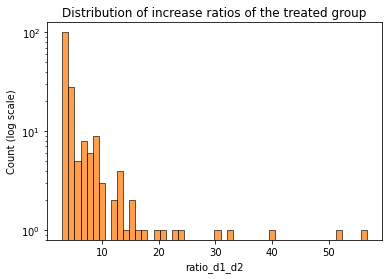

In [28]:
# distribution of ratios
sns.histplot(data=df_treated['ratio_d1_d2'], stat='count', bins=50, kde=False, cumulative=False, color=f'C{i}')
plt.title("Distribution of increase ratios of the treated group")
plt.ylabel("Count (log scale)")
# plt.xscale("log")
plt.yscale("log")
plt.show()

In [29]:
df_treated.describe()

treat          d1          d2           d3          d4  ratio_d1_d2  \
count  179.0  179.000000  179.000000   179.000000  179.000000   179.000000   
mean     1.0   15.885847   90.361825    71.062384   49.619181     6.424262   
std      0.0   12.351512   96.890038   113.871694  100.504390     7.424660   
min      1.0   10.033333   30.700000   -88.300000  -55.233333     3.000000   
25%      1.0   10.416667   40.683333    19.866667    6.000000     3.132669   
50%      1.0   10.966667   55.066667    39.333333   21.200000     3.738562   
75%      1.0   15.150000   92.916667    86.833333   53.300000     6.415714   
max      1.0   97.700000  613.466667  1089.300000  801.700000    56.627692   

       avg_patrons_bkpnt  avg_patrons_sub30  avg_patrons_add30  \
count         179.000000         179.000000         179.000000   
mean          473.808007         457.922160         564.169832   
std           708.152760         703.755581         731.696551   
min            11.533333           1.000000          61.366667   
25%            87.366667          74.650000         152.683333   
50%           232.733333         216.566667         293.533333   
75%           491.416667         479.166667         618.550000   
max          4319.300000        4305.933333        4360.333333   

       avg_patrons_add60  ...  mean_delta_subs_add60  mean_delta_subs_add90  \
count         179.000000  ...             179.000000             179.000000   
mean          635.232216  ...            5326.807313            4422.785699   
std           776.651224  ...            7636.045834            6259.132627   
min            78.533333  ...               0.000000               0.000000   
25%           192.666667  ...            1335.726042            1324.156250   
50%           340.400000  ...            3036.026042            2411.156250   
75%           693.116667  ...            5994.415365            5513.195052   
max          4379.000000  ...           53679.187500           51574.343750   

       mean_duration_sub30  mean_duration_add30  mean_duration_add60  \
count           150.000000           165.000000           158.000000   
mean            967.841012           909.047879           959.211863   
std             918.954841           728.797626           679.000952   
min              88.500000            71.000000            59.000000   
25%             475.937500           440.200000           483.187500   
50%             727.024816           725.000000           770.375000   
75%            1022.800000          1116.000000          1220.922379   
max            5812.000000          3892.000000          4128.200000   

       mean_duration_add90  mean_likes_sub30  mean_likes_add30  \
count           153.000000        150.000000        165.000000   
mean           1001.999207      13708.470469      21662.177414   
std             818.001689      17588.539499      58323.940446   
min              67.000000        151.000000        307.000000   
25%             510.714286       2598.500000       2522.294118   
50%             777.705882       6093.875000       7814.500000   
75%            1225.000000      17399.375000      18532.300000   
max            5842.000000      92559.000000     677661.000000   

       mean_likes_add60  mean_likes_add90  
count        158.000000        153.000000  
mean       16099.720728      14128.839451  
std        35039.704960      27383.192467  
min          110.000000         50.000000  
25%         2274.168750       2268.777778  
50%         6374.450000       5423.600000  
75%        16249.541667      17750.000000  
max       359155.000000     291668.000000  

[8 rows x 39 columns]

#### Time series plots (treated accounts)

In [30]:
years = mdates.YearLocator()
months = mdates.MonthLocator()

In [31]:
def color_neg_pos(ax, x, y):
    """
    draw a horizontal line at y=0
    fill negative values in red and positive values in green
    """
    if y.isnull().all():
        return
    if (y.min() < 0):
        ax.fill_between(x, y.min(), 0, color='red', alpha=0.05)
        ax.axhline(y=0, linestyle='solid', color='black', linewidth=0.5)
    # ax.fill_between(x, 0, y.max(), color='green', alpha=0.05)

In [32]:
def KM(x, pos):
    """
    format numbers in thousands (k) or in millions (M) on y axis
    """
    'The two args are the value and tick position'
    if x > 999_999:
        return '%2.1fM' % (x * 1e-6)
    elif x > 999:
        return '%2.1fK' % (x * 1e-3)
    else:
        return '%3.0f ' % (x)
KM_formatter = FuncFormatter(KM)

  0%|          | 0/4 [00:00<?, ?it/s]




 1: blindwave (treat = 1)
https://www.patreon.com/blindwave
https://graphtreon.com/creator/blindwave
https://youtube.com/channel/UCs1APU4_lj3PgZz2B4HeadA

YouTube Metadata: 
• YT videos were uploaded between November 11, 2015 and October 02, 2019
• YT metadata was crawled between November 10, 2019 and November 10, 2019
Breakpoint date:  2017-05-05

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-04-05): 2,680.5
• At breakpoint          (2017-05-05): 2,709.1
• At breakpoint + 30days (2017-06-04): 3,068.7
• At breakpoint + 60days (2017-07-04): 3,506.6
• At breakpoint + 90days (2017-08-03): 4,308.3

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-04-05 to 2017-05-05:        d1  =  +28.6 patrons
• Increase of patrons from 2017-05-05 to 2017-06-04:        d2  = +359.6 patrons
• Increase of patrons from 2017-06-04 to 2017-07-04:        d3  = +437.9 patrons
• Increase of

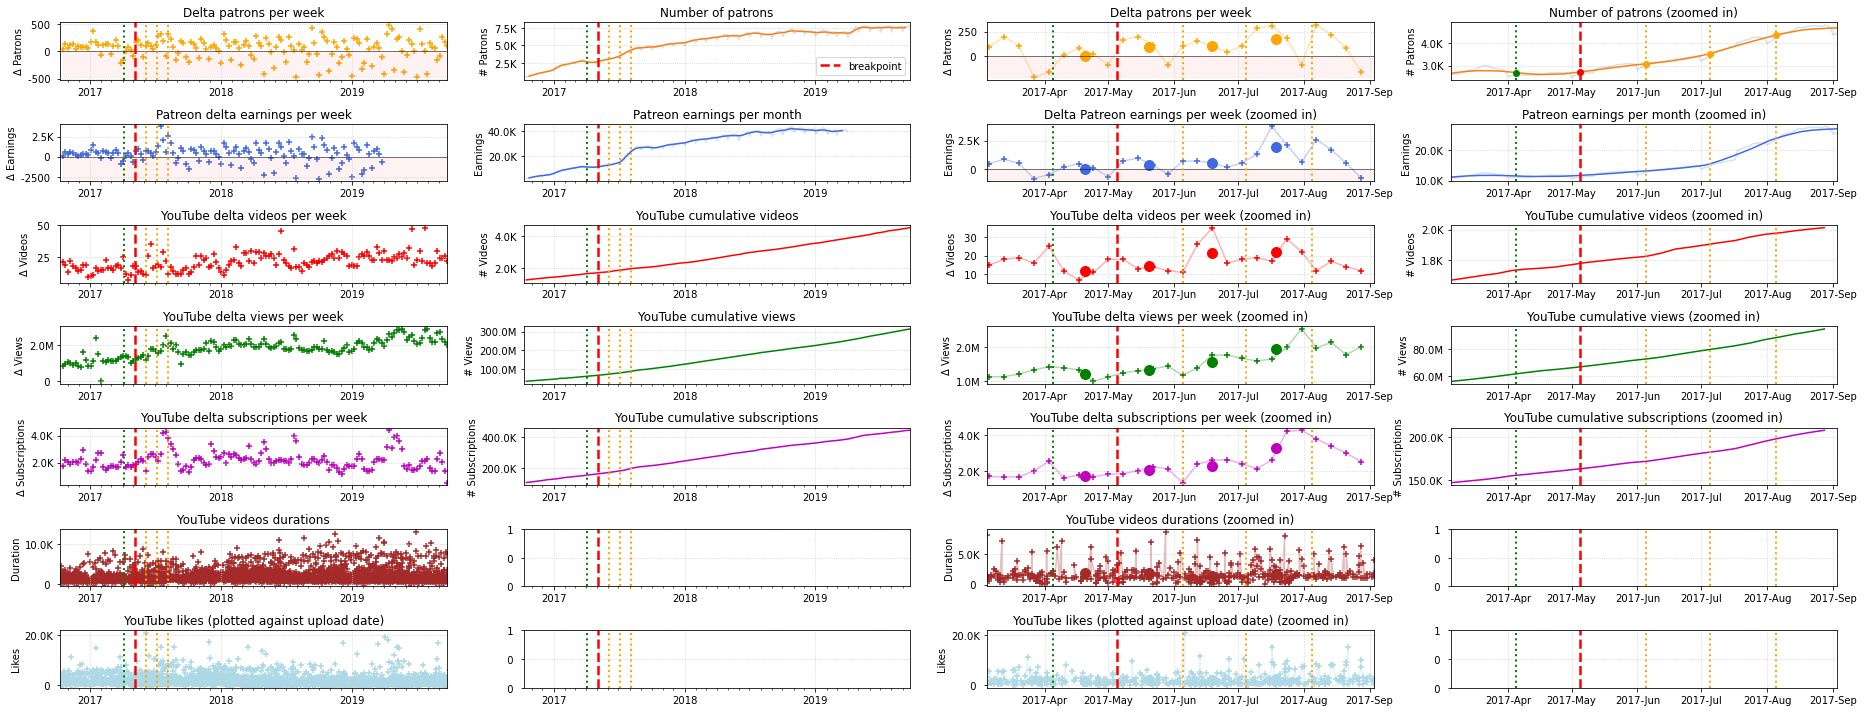




---------------------------------------------------------------------------------------------------------------------------------------------------



 2: thenormies (treat = 1)
https://www.patreon.com/thenormies
https://graphtreon.com/creator/thenormies
https://youtube.com/channel/UCbv2OBLeYiYe7B6WgPDnLow

YouTube Metadata: 
• YT videos were uploaded between October 27, 2016 and October 02, 2019
• YT metadata was crawled between November 04, 2019 and November 16, 2019
Breakpoint date:  2017-02-25

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-01-24): 74.1
• At breakpoint          (2017-02-25): 98.7
• At breakpoint + 30days (2017-03-27): 174.7
• At breakpoint + 60days (2017-04-26): 360.6
• At breakpoint + 90days (2017-05-26): 883.5

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-01-24 to 2017-02-25:        d1  =  +24.6 patrons
• Increase of patrons from 2017-02

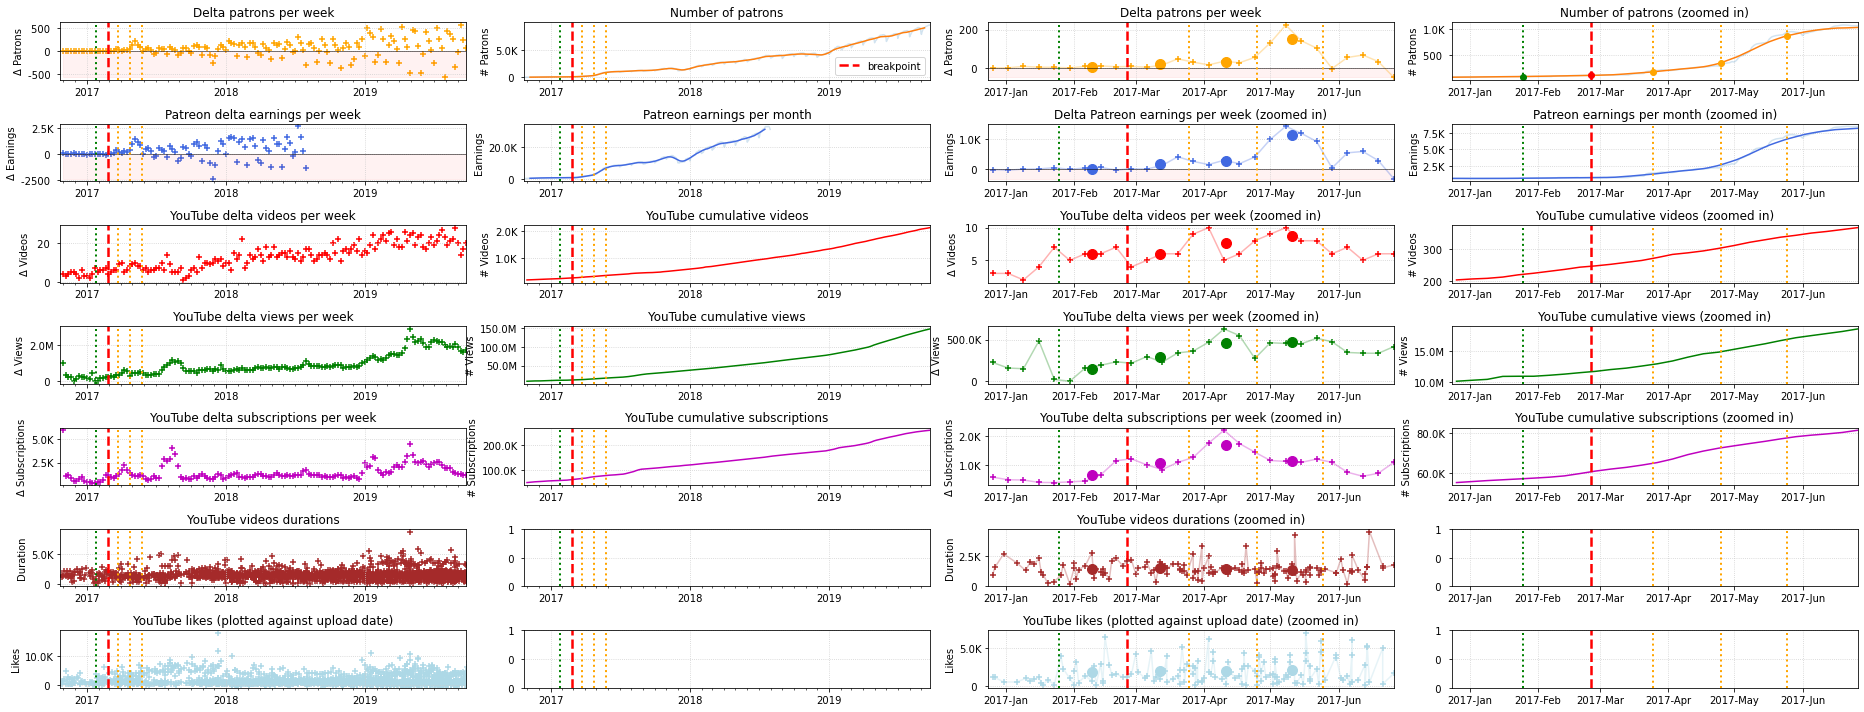




---------------------------------------------------------------------------------------------------------------------------------------------------



 3: bohobeautiful (treat = 1)
https://www.patreon.com/bohobeautiful
https://graphtreon.com/creator/bohobeautiful
https://youtube.com/channel/UCWN2FPlvg9r-LnUyepH9IaQ

YouTube Metadata: 
• YT videos were uploaded between May 30, 2016 and September 30, 2019
• YT metadata was crawled between November 11, 2019 and November 11, 2019
Breakpoint date:  2017-08-25

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-07-26): 503.9
• At breakpoint          (2017-08-25): 532.4
• At breakpoint + 30days (2017-09-24): 618.9
• At breakpoint + 60days (2017-10-24): 674.8
• At breakpoint + 90days (2017-11-23): 727.0

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-07-26 to 2017-08-25:        d1  =  +28.5 patrons
• Increase of patrons fro

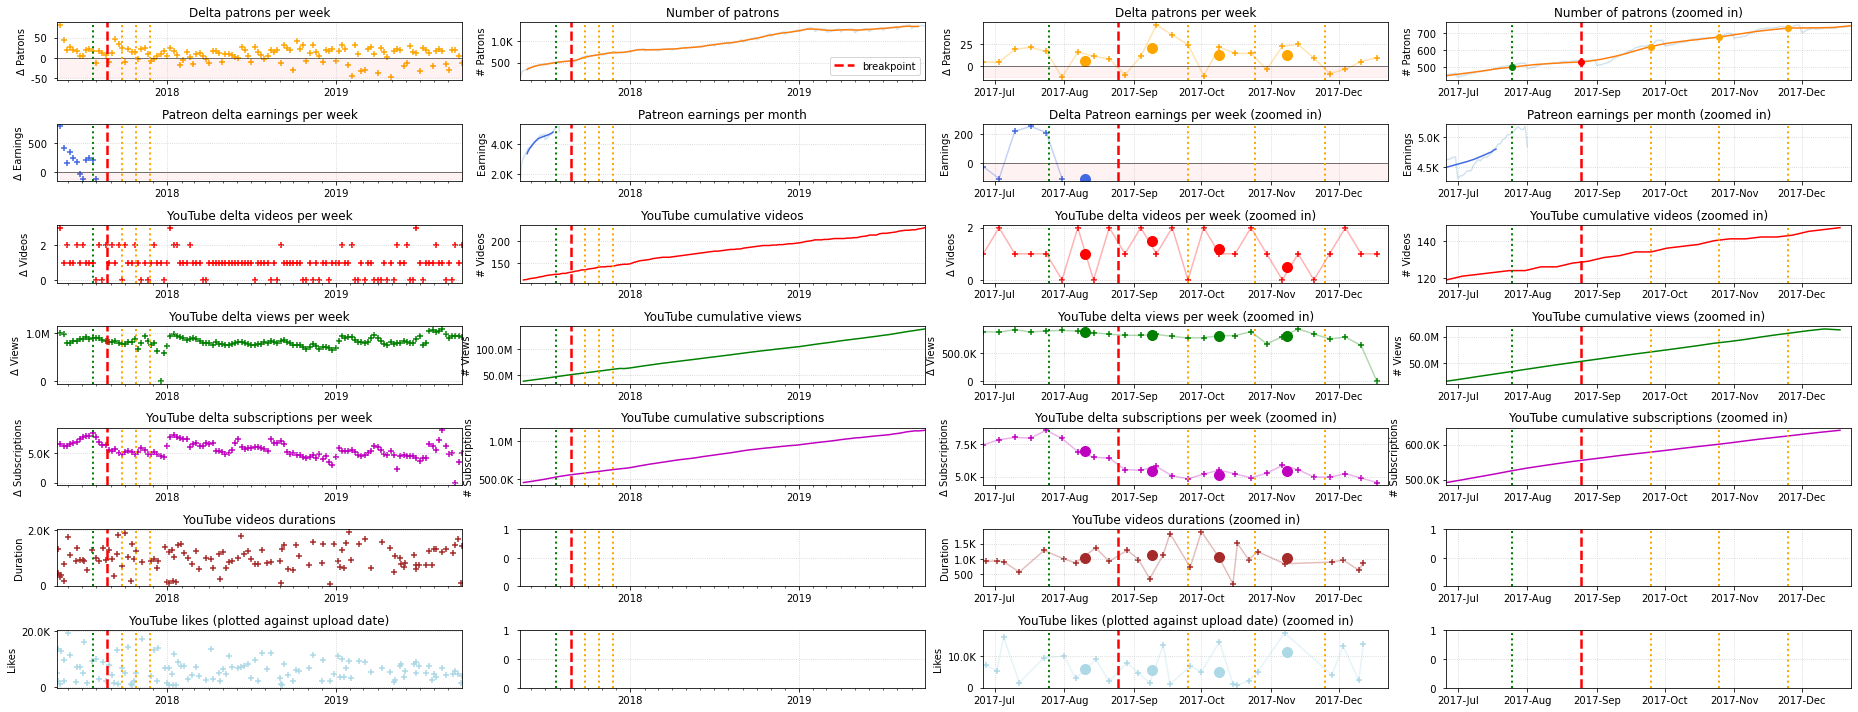




---------------------------------------------------------------------------------------------------------------------------------------------------



 4: lindsayellis (treat = 1)
https://www.patreon.com/lindsayellis
https://graphtreon.com/creator/lindsayellis
https://youtube.com/channel/UCG1h-Wqjtwz7uUANw6gazRw

YouTube Metadata: 
• YT videos were uploaded between February 25, 2016 and September 30, 2019
• YT metadata was crawled between October 30, 2019 and October 30, 2019
Breakpoint date:  2016-11-24

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2016-10-25): 1,014.0
• At breakpoint          (2016-11-24): 1,032.5
• At breakpoint + 30days (2016-12-24): 1,106.5
• At breakpoint + 60days (2017-01-23): 1,159.6
• At breakpoint + 90days (2017-02-24): 1,203.8

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2016-10-25 to 2016-11-24:        d1  =  +18.5 patrons
• Increase of p

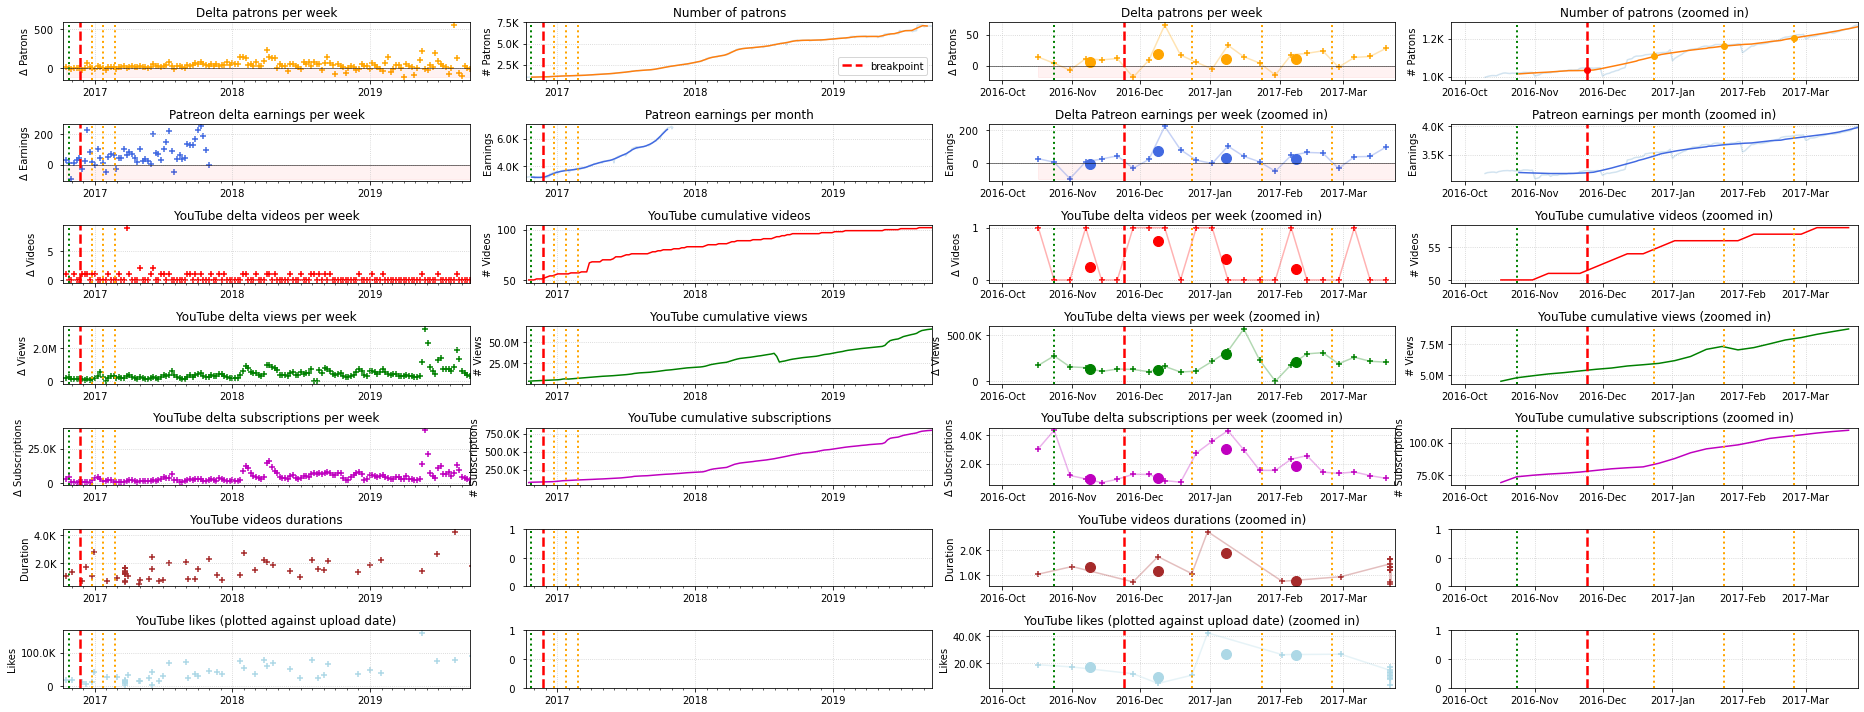




---------------------------------------------------------------------------------------------------------------------------------------------------


In [33]:
NUMBER_OF_ACCOUNTS_TO_PLOT = 4
MONTH_OFFSET = pd.DateOffset(months=1)
ROLLING_AVG_WINDOW = 30

# LOOP OVER TOP PATREON ACCOUNTS
for idx, row in tqdm(df_treated[:NUMBER_OF_ACCOUNTS_TO_PLOT].iterrows(), total=df_treated[:NUMBER_OF_ACCOUNTS_TO_PLOT].shape[0]):
    patreon = row['patreon_id']
    
    fig, axs = plt.subplots(7, 4, figsize=(26, 10), sharey=False, sharex=False)
        
    
    ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################

    # patreon earnings and users
    tmp_df_pt = restrict_acct_and_sort_df(df_top_pt_accts, 'patreon', patreon, 'date')

    # youtube videos
    tmp_df_yt = restrict_acct_and_sort_df(df_yt_timeseries_top_pt, 'patreon_id', patreon, 'datetime')

    # youtube metadata
    tmp_df_yt_meta = restrict_acct_and_sort_df(df_yt_metadata_pt_filtered, 'patreon_id', patreon, 'upload_date')
    
    
    ########################## PRINT TITLES ##########################
    
    # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
    ch_ids = tmp_df_yt['channel'].unique()
    print(f"\n\n\n\033[1m {idx+1}: {patreon[12:]} (treat = {row['treat']})\033[0m")
    print(f"https://www.{patreon}")
    print(f"https://graphtreon.com/creator/{patreon[12:]}")
    for ch_id in ch_ids:
        print(f"https://youtube.com/channel/{ch_id}")
   
    print(f'\nYouTube Metadata: ')
    
    if not (tmp_df_yt_meta.empty):
        print('• YT videos were uploaded between {} and {}'.format(tmp_df_yt_meta['upload_date'].min().strftime('%B %d, %Y'),
                                                                 tmp_df_yt_meta['upload_date'].max().strftime('%B %d, %Y')))

        print('• YT metadata was crawled between {} and {}'.format(tmp_df_yt_meta['crawl_date'].min().strftime('%B %d, %Y'),
                                                                 tmp_df_yt_meta['crawl_date'].max().strftime('%B %d, %Y')))
    else:
        print('• No metadata available for this acount')

       
    ########################## RESTRICT PATREON AND YOUTUBE TIME SERIES TO OVERLAPPING DATES ##########################
    
   # if no overlap period between YT and Patreon datasets, raise exception and skip account
    try: 
        tmp_df_pt, tmp_df_yt, date_min, date_max = restrict_to_overlapping_dates(tmp_df_pt, tmp_df_yt, 'date', 'datetime')
    except Exception as e: 
        print(f"Exception: {patreon} and {yt_channel_id}: {e} --> skipping account")        
        no_overlap += 1
        continue
    
    
    
    ########################## PATREON: CALCULATE MOVING AVERAGE AND WEEKLY DELTAS ##########################
    
    tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
    tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
    ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index
    
    # resample time series to get 7 days intervals in order to calculate weekly deltas
    ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
    ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
    ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
    tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT
    
    # reorder columns to have deltas columns next to their respective columns
    patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]
    
    # convert Float64 columns to float64 to avoid Matplotlib NAType error
    ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})
    
              
    ########################## DETECT BREAKPOINT AND REJECT PATREON ACCOUNT IF NOT VALID ##########################

    breakpoint_date = row['bkpt_date']
    # breakpoint_date = find_breakpoint_v2(tmp_df_pt, 'patrons_ma')
    print("Breakpoint date: ", breakpoint_date.date())

    # check that dates prior and after breakpoint exist
    if not (((breakpoint_date - 1*MONTH_OFFSET)) in ts_pt_df.index and ((breakpoint_date + 1*MONTH_OFFSET) in ts_pt_df.index)):
        print(f"ERROR: Breakpoint too close to edge of patreon time series or missing data\n")
        plt.figure().clear(); plt.close(); plt.cla(); plt.clf(); plt.show()
        continue
    
    
    ################################### CALCULATE INCREASE AND REJECT IF NOT VALID OR LESS THAN THRESHOLD ###################################

    avg_patrons_bkpnt = row['avg_patrons_bkpnt']
    avg_patrons_sub30 = row['avg_patrons_sub30']
    avg_patrons_add30 = row['avg_patrons_add30']
    avg_patrons_add60 = row['avg_patrons_add60']
    avg_patrons_add90 = row['avg_patrons_add90']
    
    bkpt_date       = row['bkpt_date']
    bkpt_date_sub30 = row['bkpt_date_sub30']
    bkpt_date_add30 = row['bkpt_date_add30']
    bkpt_date_add60 = row['bkpt_date_add60']
    bkpt_date_add90 = row['bkpt_date_add90']

    d1 = row['d1']
    d2 = row['d2']
    d3 = row['d3']
    d4 = row['d4']

    
    r_d1_d2 = row['ratio_d1_d2']

    print(f'\nAverage number of patrons: (values calculated using a 30 days centered moving average)')
    print(f'• At breakpoint - 30days ({bkpt_date_sub30.date()}): {avg_patrons_sub30:,.1f}')
    print(f'• At breakpoint          ({bkpt_date.date()}): {avg_patrons_bkpnt:,.1f}')
    print(f'• At breakpoint + 30days ({bkpt_date_add30.date()}): {avg_patrons_add30:,.1f}')
    print(f'• At breakpoint + 60days ({bkpt_date_add60.date()}): {avg_patrons_add60:,.1f}')
    print(f'• At breakpoint + 90days ({bkpt_date_add90.date()}): {avg_patrons_add90:,.1f}')
    
    print(f'\nIncrease of patrons in the period before and after the breakpoint:')
    print(f"• Increase of patrons from {bkpt_date_sub30.date()} to {bkpt_date.date()}:        d1  = {d1:>+6.1f} patrons")
    print(f"• Increase of patrons from {bkpt_date.date()} to {bkpt_date_add30.date()}:        d2  = {d2:>+6.1f} patrons")
    print(f"• Increase of patrons from {bkpt_date_add30.date()} to {bkpt_date_add60.date()}:        d3  = {d3:>+6.1f} patrons")
    print(f"• Increase of patrons from {bkpt_date_add60.date()} to {bkpt_date_add90.date()}:        d4  = {d4:>+6.1f} patrons")
    
    print(f'\nRatio of the increases of the 2 periods: ')
    print(f"• Ratio between 2 increases:                            d2/d1  = {r_d1_d2:.2f}")
    print(f"• Percentage increase:                              d2/d1*100  = {r_d1_d2:>+.0%}")

    
    
    

    ################################### GET DELTA MEANS BEFORE AND AFTER BKPOINT ###################################  
       
    
    mean_date_sub30 = row['bkpt_date_sub30'] + (row['bkpt_date']       - row['bkpt_date_sub30'])/2
    mean_date_add30 = row['bkpt_date']       + (row['bkpt_date_add30'] - row['bkpt_date'])/2
    mean_date_add60 = row['bkpt_date_add30'] + (row['bkpt_date_add60'] - row['bkpt_date_add30'])/2
    mean_date_add90 = row['bkpt_date_add60'] + (row['bkpt_date_add90'] - row['bkpt_date_add60'])/2
  

    mean_dates = [
        mean_date_sub30, 
        mean_date_add30, 
        mean_date_add60, 
        mean_date_add90
    ]  
    
    mean_delta_patrons = [
        row['mean_delta_patrons_sub30'],
        row['mean_delta_patrons_add30'],
        row['mean_delta_patrons_add60'],
        row['mean_delta_patrons_add90']
    ]

    mean_delta_earnings = [
        row['mean_delta_earnings_sub30'],
        row['mean_delta_earnings_add30'],
        row['mean_delta_earnings_add60'],
        row['mean_delta_earnings_add90']
    ]

    mean_delta_videos = [
        row['mean_delta_videos_sub30'],
        row['mean_delta_videos_add30'],
        row['mean_delta_videos_add60'],
        row['mean_delta_videos_add90']
    ]

    mean_delta_views = [
        row['mean_delta_views_sub30'],
        row['mean_delta_views_add30'],
        row['mean_delta_views_add60'],
        row['mean_delta_views_add90']
    ]

    mean_delta_subscriptions = [
        row['mean_delta_subs_sub30'],
        row['mean_delta_subs_add30'],
        row['mean_delta_subs_add60'],
        row['mean_delta_subs_add90']
    ]

    mean_delta_durations = [
        row['mean_duration_sub30'],
        row['mean_duration_add30'],
        row['mean_duration_add60'],
        row['mean_duration_add90']
    ]

    mean_delta_likes = [
        row['mean_likes_sub30'],
        row['mean_likes_add30'],
        row['mean_likes_add60'],
        row['mean_likes_add90']
    ]
    
        


    # patreons
    for mean_date, mean_value in zip(mean_dates, mean_delta_patrons):
        axs[0,2].plot(mean_date, mean_value, marker='o', color='orange', markersize=10)

    for mean_date, mean_value in zip(mean_dates, mean_delta_earnings):
        axs[1,2].plot(mean_date, mean_value, marker='o', color='royalblue', markersize=10)


    # youtube
    for mean_date, mean_value in zip(mean_dates, mean_delta_videos):
        axs[2,2].plot(mean_date, mean_value, marker='o', color='r', markersize=10)

    for mean_date, mean_value in zip(mean_dates, mean_delta_views):
        axs[3,2].plot(mean_date, mean_value, marker='o', color='g', markersize=10)

    for mean_date, mean_value in zip(mean_dates, mean_delta_subscriptions):
        axs[4,2].plot(mean_date, mean_value, marker='o', color='m', markersize=10)
        

    # youtube metadata
    for mean_date, mean_value in zip(mean_dates, mean_delta_durations):
        axs[5,2].plot(mean_date, mean_value, marker='o', color='brown', markersize=10)
        
    for mean_date, mean_value in zip(mean_dates, mean_delta_likes):
        axs[6,2].plot(mean_date, mean_value, marker='o', color='lightblue', markersize=10)
    
    

    
#     # plot horizontal lines for means
#     mean_befor_list = [mean_delta_patrons_befor, mean_delta_earnings_befor, mean_delta_videos_befor, mean_delta_views_befor, mean_delta_subs_befor, mean_duration_befor, mean_likes_befor]
#     mean_afer_list = [mean_delta_patrons_after, mean_delta_earnings_after, mean_delta_videos_after, mean_delta_views_after, mean_delta_subs_after, mean_duration_after, mean_likes_after]
       
#     for idx, mean in enumerate(mean_befor_list):
#             if not math.isnan(mean):
#                 axs[idx,2].hlines(y=mean, xmin=bkpt_date_sub30, xmax=bkpt_date      , linewidth=2, linestyle='--', color='green')

#     for idx, mean in enumerate(mean_afer_list):
#             if not math.isnan(mean):
#                 axs[idx,2].hlines(y=mean, xmin=bkpt_date,       xmax=bkpt_date_add30, linewidth=2, linestyle='--', color='orange')
        

    
    
    ################################### ZOOM OUT PLOTS ###################################
    
    # number of patrons (delta)
    axs[0,0].scatter(ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_patrons'], c='orange', s=30, marker='+')
    axs[0,0].set(title="Delta patrons per week")
    axs[0,0].set_ylabel("Δ Patrons")    
    color_neg_pos(axs[0,0], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_patrons'])

    # number of patrons (cumulative)
    axs[0,1].plot(tmp_df_pt['date'], tmp_df_pt['patrons'], alpha=0.2)
    axs[0,1].plot(tmp_df_pt['date'], tmp_df_pt['patrons_ma'])
    axs[0,1].set(title="Number of patrons")
    axs[0,1].set_ylabel("# Patrons")

    # patreon earnings (delta)
    axs[1,0].scatter(ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_earning'], color='royalblue', s=30, marker='+')
    axs[1,0].set(title="Patreon delta earnings per week")
    axs[1,0].set_ylabel("Δ Earnings") 
    color_neg_pos(axs[1,0], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_earning'])

    # patreon earnings (cumulative)
    axs[1,1].plot(tmp_df_pt['date'], tmp_df_pt['earning'], alpha=0.2)
    axs[1,1].plot(tmp_df_pt['date'], tmp_df_pt['earning_ma'], color='royalblue')
    axs[1,1].set(title="Patreon earnings per month")
    axs[1,1].set_ylabel("Earnings")
    
    # youtube videos (delta)
    axs[2,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_videos'], c='r', s=30, marker='+')
    axs[2,0].set(title="YouTube delta videos per week")
    axs[2,0].set_ylabel("Δ Videos")
    color_neg_pos(axs[2,0], tmp_df_yt['datetime'], tmp_df_yt['delta_videos'])

    # youtube videos (cumulative)
    axs[2,1].plot(tmp_df_yt['datetime'], tmp_df_yt['videos'], 'r')
    axs[2,1].set(title="YouTube cumulative videos")
    axs[2,1].set_ylabel("# Videos")

    # youtube views (delta)
    axs[3,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_views'], c='g', s=30, marker='+')
    axs[3,0].set(title="YouTube delta views per week")
    axs[3,0].set_ylabel("Δ Views")
    color_neg_pos(axs[3,0], tmp_df_yt['datetime'], tmp_df_yt['delta_views'])

    # youtube views (cumulative)
    axs[3,1].plot(tmp_df_yt['datetime'], tmp_df_yt['views'], 'g')
    axs[3,1].set(title="YouTube cumulative views")
    axs[3,1].set_ylabel("# Views")

    # youtube subs (delta)
    axs[4,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_subs'], c='m', s=30, marker='+')
    axs[4,0].set(title="YouTube delta subscriptions per week")
    axs[4,0].set_ylabel("Δ Subscriptions")
    color_neg_pos(axs[4,0], tmp_df_yt['datetime'], tmp_df_yt['delta_subs'])

    # youtube subs (cumulative)
    axs[4,1].plot(tmp_df_yt['datetime'], tmp_df_yt['subs'], 'm')
    axs[4,1].set(title="YouTube cumulative subscriptions")
    axs[4,1].set_ylabel("# Subscriptions")
    
    
    # youtube durations per uploads
    axs[5,0].scatter(tmp_df_yt_meta['upload_date'], tmp_df_yt_meta['duration'], c='brown', s=30, marker='+')
    axs[5,0].set(title="YouTube videos durations")
    axs[5,0].set_ylabel("Duration")
    
    
    # youtube likes at crawl date
    axs[6,0].scatter(tmp_df_yt_meta['upload_date'], tmp_df_yt_meta['like_count'], c='lightblue', s=30, marker='+')
    axs[6,0].set(title="YouTube likes (plotted against upload date)")
    axs[6,0].set_ylabel("Likes")
    

    ########################## RESTRICT DATES FOR ZOOM IN (+/- 2 months around breakpoint) ##########################

    # calculate min and max dates for zoom
    date_min_zoom = bkpt_date_sub30 - (1 * MONTH_OFFSET)
    date_max_zoom = bkpt_date_add90 + (1 * MONTH_OFFSET)
    
    
    # restrict datasets between min and max dates
    tmp_df_pt_zoomed = tmp_df_pt[(tmp_df_pt['date'] >= date_min_zoom) & (tmp_df_pt['date'] <= date_max_zoom)].copy()
    tmp_df_yt_zoomed = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min_zoom) & (tmp_df_yt['datetime'] <= date_max_zoom)].copy()
    tmp_df_yt_meta_zoomed = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= date_min_zoom) & (tmp_df_yt_meta['upload_date'] <= date_max_zoom)].copy()

    # used for coloration
    ts_pt_weekly_avg_df_zoomed = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= date_min_zoom) & (ts_pt_weekly_avg_df_float64.index <= date_max_zoom)]
    
    
   ################################### ZOOM IN PLOTS  ###################################

    # zoomed in patron numbers (delta)
    axs[0,2].scatter(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'], c='orange', s=30, marker='+')
    axs[0,2].plot(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'], c='orange', alpha=0.3)
    axs[0,2].set(title="Delta patrons per week")
    axs[0,2].set_ylabel("Δ Patrons")
    color_neg_pos(axs[0,2], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'])
    
    # zoomed in patron numbers (cumulative)
    axs[0,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['patrons'], alpha=0.2)
    axs[0,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['patrons_ma'])
    axs[0,3].set(title="Number of patrons (zoomed in)")
    axs[0,3].set_ylabel("# Patrons")
    
    # zoomed in patron earnings (delta)
    axs[1,2].scatter(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_earning'], color='royalblue', s=30, marker='+')
    axs[1,2].plot(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_earning'], color='royalblue', alpha=0.3)
    axs[1,2].set(title="Delta Patreon earnings per week (zoomed in)")
    axs[1,2].set_ylabel("Earnings")  
    color_neg_pos(axs[1,2], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_zoomed['delta_earning'])

    # zoomed in patron earnings (cumulative)
    axs[1,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['earning'], alpha=0.2)
    axs[1,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['earning_ma'], color='royalblue')
    axs[1,3].set(title="Patreon earnings per month (zoomed in)")
    axs[1,3].set_ylabel("Earnings")
    
    # zoomed in youtube videos (delta)
    axs[2,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_videos'], c='r', s=30, marker='+')
    axs[2,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_videos'], c='r', alpha=0.3)
    axs[2,2].set(title="YouTube delta videos per week (zoomed in)")
    axs[2,2].set_ylabel("Δ Videos")
    color_neg_pos(axs[2,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_videos'])

    # zoomed in youtube videos (cumulative)
    axs[2,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['videos'], 'r')
    axs[2,3].set(title="YouTube cumulative videos (zoomed in)")
    axs[2,3].set_ylabel("# Videos")

    # zoomed in youtube views (delta)
    axs[3,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_views'], c='g', s=30, marker='+')
    axs[3,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_views'], c='g', alpha=0.3)
    axs[3,2].set(title="YouTube delta views per week (zoomed in)")
    axs[3,2].set_ylabel("Δ Views")
    color_neg_pos(axs[3,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_views'])

    # zoomed in youtube views (cumulative)
    axs[3,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['views'], 'g')
    axs[3,3].set(title="YouTube cumulative views (zoomed in)")
    axs[3,3].set_ylabel("# Views")
    
    # zoomed in youtube subs (delta)
    axs[4,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_subs'], c='m', s=30, marker='+')
    axs[4,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_subs'], c='m', alpha=0.3)
    axs[4,2].set(title="YouTube delta subscriptions per week (zoomed in)")
    axs[4,2].set_ylabel("Δ Subscriptions")
    color_neg_pos(axs[4,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_subs'])

    # zoomed in youtube subs (cumulative)
    axs[4,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['subs'], 'm')
    axs[4,3].set(title="YouTube cumulative subscriptions (zoomed in)")
    axs[4,3].set_ylabel("# Subscriptions")
    
    
    # youtube durations per uploads
    axs[5,2].scatter(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'], c='brown', s=30, marker='+')
    axs[5,2].plot(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'], c='brown', alpha=0.3)
    axs[5,2].set(title="YouTube videos durations (zoomed in)")
    axs[5,2].set_ylabel("Duration")
    color_neg_pos(axs[5,2], tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'])
    
        
   # youtube likes per uploads
    axs[6,2].scatter(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['like_count'], c='lightblue', s=30, marker='+')
    axs[6,2].plot(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['like_count'], c='lightblue', alpha=0.3)
    axs[6,2].set(title="YouTube likes (plotted against upload date) (zoomed in)")
    axs[6,2].set_ylabel("Likes")
    color_neg_pos(axs[5,2], tmp_df_yt_meta_zoomed['crawl_date'], tmp_df_yt_meta_zoomed['like_count'])
    
    
    
    ################################### FORMAT AXES ###################################

    # format the axes
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if j < 2:
                axs[i,j].set_xlim([date_min, date_max])
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                axs[i,j].xaxis.set_major_locator(mdates.YearLocator())
                axs[i,j].xaxis.set_minor_locator(mdates.MonthLocator())
            if j >= 2:
                axs[i,j].set_xlim([date_min_zoom, date_max_zoom])
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
                axs[i,j].xaxis.set_major_locator(mdates.MonthLocator())
                # axs[i,j].xaxis.set_minor_locator(mdates.WeekdayLocator())
            axs[i,j].xaxis.grid(color="#CCCCCC", ls=":")
            axs[i,j].yaxis.grid(color="#CCCCCC", ls=":")
            axs[i,j].yaxis.set_major_formatter(KM_formatter)
            
            
    ################################### PLOT BREAKPOINT LINES AND POINTS ###################################

    # plot vertical lines for breakpoint, breakpoint-1month, breakpoint+1month
    print_legend = True
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if print_legend:
                axs[i,j].axvline(breakpoint_date, color='red', linestyle='--', label='breakpoint', linewidth=2.5)
                axs[i,j].axvline(breakpoint_date - MONTH_OFFSET, color='green', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)          
                axs[i,j].axvline(breakpoint_date + 2*MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)          
                axs[i,j].axvline(breakpoint_date + 3*MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)          
                # print_legend = False
            else:
                axs[i,j].axvline(breakpoint_date, color='red', linestyle='--', linewidth=2.5)
                axs[i,j].axvline(breakpoint_date - MONTH_OFFSET, color='green', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + 2*MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + 3*MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)
    # axs[0,0].legend()
    axs[0,1].legend()

    # plot point for mean nb of patrons for breakpoint, breakpoint-1month, breakpoint+1month    
    axs[0,3].plot(breakpoint_date - MONTH_OFFSET, ts_pt_df.at[(breakpoint_date - MONTH_OFFSET), 'patrons_ma'], marker='o', color='green')
    axs[0,3].plot(breakpoint_date,               ts_pt_df.at[breakpoint_date              , 'patrons_ma'], marker='o', color='red')    
    axs[0,3].plot(breakpoint_date + MONTH_OFFSET, ts_pt_df.at[(breakpoint_date + MONTH_OFFSET), 'patrons_ma'], marker='o', color='orange')    
    axs[0,3].plot(breakpoint_date + 2*MONTH_OFFSET, ts_pt_df.at[(breakpoint_date + 2*MONTH_OFFSET), 'patrons_ma'], marker='o', color='orange')    
    axs[0,3].plot(breakpoint_date + 3*MONTH_OFFSET, ts_pt_df.at[(breakpoint_date + 3*MONTH_OFFSET), 'patrons_ma'], marker='o', color='orange')   

    fig.tight_layout(w_pad=0)
    plt.show()
    
    print('\n\n\n---------------------------------------------------------------------------------------------------------------------------------------------------')
    

## 3. Granger causality

### 3.1 Compute Granger Tests

In [34]:
# precedence links we will explore
granger_columns = [
'pt_delta_patrons->yt_delta_videos',
'pt_delta_patrons->yt_delta_views',
'pt_delta_patrons->yt_delta_subs',
'yt_delta_videos->pt_delta_patrons',
'yt_delta_views->pt_delta_patrons',
'yt_delta_subs->pt_delta_patrons'
]

In [35]:
# compare YouTube and Patreon timeseries for top patreon accounts with rolling average - MANUAL VERSION 2
MONTH_OFFSET = pd.DateOffset(months=1)
# WEEK_OFFSET = pd.DateOffset(weeks=1)
ROLLING_AVG_WINDOW = 30

# variables for Granger Tests
MAXLAG = 2
granger_dict = {} # dictionary with  keys (cause --> effect) and values with list of corresponding patreon account(s)
not_granger = []
YT_variables = ['yt_delta_videos', 'yt_delta_views', 'yt_delta_subs']
# PT_variables = ['pt_delta_patrons', 'pt_delta_earning']
PT_variables = ['pt_delta_patrons']

df_granger = df_treated.copy()


# LOOP OVER TOP PATREON ACCOUNTS
for idx, row in tqdm(df_granger.iterrows(), total=df_granger.shape[0]):   
    patreon = row['patreon_id']

     ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################

    # patreon earnings and users
    tmp_df_pt = restrict_acct_and_sort_df(df_top_pt_accts, 'patreon', patreon, 'date')

    # youtube videos
    tmp_df_yt = restrict_acct_and_sort_df(df_yt_timeseries_top_pt, 'patreon_id', patreon, 'datetime')

    # youtube metadata
    tmp_df_yt_meta = restrict_acct_and_sort_df(df_yt_metadata_pt_filtered, 'patreon_id', patreon, 'upload_date')
    
    
    ########################## PRINT TITLES ##########################
    
    # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
    # ch_ids = tmp_df_yt['channel'].unique()
    # print(f"\n\n\n\033[1mRank {idx+1}: {patreon[12:]} \033[0m")
    # print(f"https://www.{patreon}")
    # print(f"https://graphtreon.com/creator/{patreon[12:]}")
    # for ch_id in ch_ids:
    #     print(f"https://youtube.com/channel/{ch_id}")

    
#     ########################## RESTRICT DATES FOR ZOOM OUT ##########################
    
#     # set min and max dates for plots   
#     date_min = max([tmp_df_yt['datetime'].min(), tmp_df_pt['date'].min()])
#     date_max = min([tmp_df_yt['datetime'].max(), tmp_df_pt['date'].max()])
    
#     if date_max < date_min:
#         print(f":( no overlapping period between YouTube and Patreon datasets\n")
#         continue
    
#     # restrict datasets between min and max dates
#     tmp_df_pt = tmp_df_pt[(tmp_df_pt['date'] >= date_min) & (tmp_df_pt['date'] <= date_max)]
#     tmp_df_yt = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min) & (tmp_df_yt['datetime'] <= date_max)]
    
#     # align both dataframes since youtube starts once a week
#     tmp_df_pt = tmp_df_pt[tmp_df_pt['date'] >= tmp_df_yt['datetime'].min()]
    
    ########################## RESTRICT PATREON AND YOUTUBE TIME SERIES TO OVERLAPPING DATES ##########################
    
   # if no overlap period between YT and Patreon datasets, raise exception and skip account
    try: 
        tmp_df_pt, tmp_df_yt, date_min, date_max = restrict_to_overlapping_dates(tmp_df_pt, tmp_df_yt, 'date', 'datetime')
    except Exception as e: 
        print(f"Exception: {patreon} and {yt_channel_id}: {e} --> skipping account")        
        no_overlap += 1
        continue
    
    
    
    ########################## PATREON: CALCULATE MOVING AVERAGE AND WEEKLY DELTAS ##########################
    
    tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
    tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
    ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index
    
    # resample time series to get 7 days intervals in order to calculate weekly deltas
    ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
    ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
    ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
    tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT
    
    # reorder columns to have deltas columns next to their respective columns
    patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]
    
    # convert Float64 columns to float64 to avoid Matplotlib NAType error
    ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})
    
               
    ################################### CALCULATE INCREASE AND REJECT IF NOT VALID OR LESS THAN THRESHOLD ###################################

    breakpoint_date = row['bkpt_date']

    avg_patrons_bkpnt = row['avg_patrons_bkpnt']
    avg_patrons_sub30 = row['avg_patrons_sub30']
    avg_patrons_add30 = row['avg_patrons_add30']
    
    bkpt_date       = row['bkpt_date']
    bkpt_date_sub30 = row['bkpt_date_sub30']
    bkpt_date_add30 = row['bkpt_date_add30']
    
    d1 = row['d1']
    d2 = row['d2']

    
    r = row['ratio_d1_d2']

#     print(f'\nAverage number of patrons: (values calculated using a 30 days centered moving average)')
#     print(f'• At breakpoint - 30days ({bkpt_date_sub30.date()}): {avg_patrons_sub30:,.1f}')
#     print(f'• At breakpoint          ({bkpt_date.date()}): {avg_patrons_bkpnt:,.1f}')
#     print(f'• At breakpoint + 30days ({bkpt_date_add30.date()}): {avg_patrons_add30:,.1f}')
    
#     print(f'\nIncrease of patrons in the period before and after the breakpoint:')
#     print(f"• Increase of patrons from {bkpt_date_sub30.date()} to {bkpt_date.date()}:        d1  = {d1:>+6.1f} patrons")
#     print(f"• Increase of patrons from {bkpt_date.date()} to {bkpt_date_add30.date()}:        d2  = {d2:>+6.1f} patrons")
    
#     print(f'\nRatio of the increases of the 2 periods: ')
#     print(f"• Ratio between 2 increases:                            d2/d1  = {r:.2f}")
#     print(f"• Percentage increase:                            |d2/d1|*100  = {abs(r):>+.0%}")
    


    ########################## RESTRICT DATES FOR ZOOM IN (+/- 2 months around breakpoint) ##########################

    # calculate min and max dates for zoom
    date_min_zoom = breakpoint_date - (2 * MONTH_OFFSET)
    date_max_zoom = breakpoint_date + (2 * MONTH_OFFSET)
            
    # restrict datasets between min and max dates
    tmp_df_pt_zoomed = tmp_df_pt[(tmp_df_pt['date'] >= date_min_zoom) & (tmp_df_pt['date'] <= date_max_zoom)].copy()
    tmp_df_yt_zoomed = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min_zoom) & (tmp_df_yt['datetime'] <= date_max_zoom)].copy()

    # used for coloration
    ts_pt_weekly_avg_df_zoomed = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= date_min_zoom) & (ts_pt_weekly_avg_df_float64.index <= date_max_zoom)]
    


    ################################### GRANGER CAUSALITY TESTS ###################################

    # create a new dataframe with merged columns (the dates might have a day difference)
    selected_pt_columns  = ['delta_earning', 'delta_patrons']
    df_pt = ts_pt_weekly_avg_df_zoomed
    df_pt = df_pt[selected_pt_columns].reset_index().add_prefix('pt_')

    selected_yt_columns = ['datetime', 'delta_views', 'delta_subs', 'delta_videos']
    df_yt = tmp_df_yt_zoomed
    df_yt = df_yt[selected_yt_columns].reset_index().add_prefix('yt_')

    # concatenated 2 dfs and select and reorder columns
    df_concat = pd.concat([df_pt, df_yt], axis=1)
    concat_columns = ['pt_date', 'yt_datetime', 'pt_delta_earning', 'pt_delta_patrons', 'yt_delta_views', 'yt_delta_subs', 'yt_delta_videos']
    df_concat = df_concat[concat_columns]
    # df_concat['dates_match'] = df_concat['pt_date'] == df_concat['yt_datetime']
    
    # display(df_concat.round())
    # display(df_concat.style.set_caption(f"df_concat"))
    
    
    # print(f"\nGranger Causality Tests:")
    
    granger_causal_link = False
    for pt_var in PT_variables:
        for yt_var in YT_variables:
            
            # if nan values in this df, skip
            if df_concat[[yt_var, pt_var]].isna().values.any():
                continue
                
            pvalue_fwd = {}
            pvalue_rev = {}
            
            try:
                granger_test_fwd = grangercausalitytests(df_concat[[yt_var, pt_var]], maxlag=MAXLAG, verbose=False)  
                # print(f'\n\n• {pt_var} --> {yt_var}')
                # for lag, tests_results in granger_test_fwd.items():
                #     print(f"\nlag={lag}")                    
                #     for test_name, tests_result in tests_results[0].items():
                #         # test_results is the tuple: (test statistic, pvalues, degrees of freedom, [degrees of freedom])
                #         print(f"{test_name}: \t{tests_result}")

                granger_test_rev = grangercausalitytests(df_concat[[pt_var, yt_var]], maxlag=MAXLAG, verbose=False) 
                # print(f'\n\n• {yt_var} --> {pt_var}')
                # for lag, tests_results in granger_test_rev.items():
                #     print(f"\nlag={lag}")                    
                #     for test_name, tests_result in tests_results[0].items():
                #         # test_results is the tuple: (test statistic, pvalues, degrees of freedom, [degrees of freedom])
                #         print(f"{test_name}: \t{tests_result}")
            except Exception:
                print("Granger Causality Exception")
                continue

            # for each lag, get the p-value for the sum of squared residuals (SSR) of the F-test
            for lag in range(1, MAXLAG+1):        
                pvalue_fwd[lag] = granger_test_fwd[lag][0]['ssr_ftest'][1]
                pvalue_rev[lag] = granger_test_rev[lag][0]['ssr_ftest'][1]
                
            
            
            # for the forward tests, get the minimum p-value of the different lags and compare it to our significance level
            min_pvalue_fwd = min(pvalue_fwd.values())
            if min_pvalue_fwd < 0.05:
                granger_causal_link = True
                # get the lag of the minimum p-value for that account
                min_lag_fwd = [k for k, v in pvalue_fwd.items() if v == min_pvalue_fwd][0]
                # print(f'• {pt_var} --> {yt_var} (pvalue={min_pvalue_fwd:.3f}, lag={min_lag_fwd})')

                # add value to df
                df_granger.loc[idx, pt_var+'->'+yt_var] = 1

                if (pt_var, yt_var) in granger_dict:                   
                    granger_dict[(pt_var, yt_var)].append(patreon)
                else:
                    granger_dict[(pt_var, yt_var)] = [patreon]
            else: 
                df_granger.loc[idx, pt_var+'->'+yt_var] = 0
                
            # repeat for the reverse tests
            min_pvalue_rev = min(pvalue_rev.values())
            if min_pvalue_rev < 0.05:
                granger_causal_link = True
                min_lag_rev = [k for k, v in pvalue_rev.items() if v == min_pvalue_rev][0]
                # print(f'• {yt_var} --> {pt_var} (pvalue={min_pvalue_rev:.3f}, lag={min_lag_rev})')

                # add value to df
                df_granger.loc[idx, yt_var+'->'+pt_var] = 1
                
                if (yt_var, pt_var) in granger_dict:
                    granger_dict[(yt_var, pt_var)].append(patreon)
                else:
                    granger_dict[(yt_var, pt_var)] = [patreon]
            else: 
                df_granger.loc[idx, yt_var+'->'+pt_var] = 0
                

    if (granger_causal_link == False):
        # print("• No Granger causality found for this account")
        not_granger.append(patreon)
    
    # print('\n\n\n---------------------------------------------------------------------------------------------------------------------------------------------------')
    
print(f'\n\nGranger tests summary statistics: (with maxlag = {MAXLAG})')
    
print(f'• Number of patreon accounts analysed (patrons increase ratio > {INCR_RATIO_THRESH}): {len(df_granger)}')
print(f'• Number of patreon with no Granger-causal link: {len(not_granger)} ({len(not_granger)/len(df_granger):.0%})')

print(f'• Number of patreon accounts per Granger-causal link:')

# Converting granger dict into list of tuples (in order to sort it), the 2nd value of the tuple being the count of accounts
granger_list = [(k, len(v)) for k, v in granger_dict.items()]
# sort by count desc


granger_list_desc = sorted(granger_list, key=lambda tup: -tup[1])
for (k,v) in granger_list_desc:
    print(f'    • {k[0]} \t--> {k[1]}:\t {v} ({v/df_granger[granger_columns].sum().sum():.0%})')

df_granger[granger_columns] = df_granger[granger_columns].astype('Int64')
df_granger

  0%|          | 0/179 [00:00<?, ?it/s]

Granger Causality Exception
Granger Causality Exception
Granger Causality Exception


Granger tests summary statistics: (with maxlag = 2)
• Number of patreon accounts analysed (patrons increase ratio > 3): 179
• Number of patreon with no Granger-causal link: 75 (42%)
• Number of patreon accounts per Granger-causal link:
    • pt_delta_patrons 	--> yt_delta_subs:	 47 (25%)
    • pt_delta_patrons 	--> yt_delta_views:	 40 (21%)
    • yt_delta_subs 	--> pt_delta_patrons:	 35 (18%)
    • pt_delta_patrons 	--> yt_delta_videos:	 27 (14%)
    • yt_delta_views 	--> pt_delta_patrons:	 24 (13%)
    • yt_delta_videos 	--> pt_delta_patrons:	 18 (9%)


patreon_id             yt_channel_id  treat         d1  \
0          patreon.com/blindwave  UCs1APU4_lj3PgZz2B4HeadA      1  28.600000   
1         patreon.com/thenormies  UCbv2OBLeYiYe7B6WgPDnLow      1  24.600000   
2      patreon.com/bohobeautiful  UCWN2FPlvg9r-LnUyepH9IaQ      1  28.466667   
3       patreon.com/lindsayellis  UCG1h-Wqjtwz7uUANw6gazRw      1  18.533333   
4        patreon.com/3blue1brown  UCYO_jab_esuFRV4b17AJtAw      1  97.400000   
..                           ...                       ...    ...        ...   
174   patreon.com/tristanparedes  UCi4_eFlo3rvZokGUXB_WoLQ      1  10.033333   
175      patreon.com/massageasmr  UCgOfiuubHnhVrc9IEcSk1Nw      1  10.466667   
176  patreon.com/indigotraveller  UCXulruMI7BHj3kGyosNa0jA      1  10.033333   
177       patreon.com/senseislam  UCULN4pFp-FlahCVfTNEE3BA      1  10.066667   
178   patreon.com/omgitsfirefoxx  UCKi52SDIwr5ysHX_ROF7A1g      1  10.966667   

             d2          d3          d4  ratio_d1_d2  bkpt_date  \
0    359.633333  437.866667  801.700000    12.574592 2017-05-05   
1     76.000000  185.933333  522.866667     3.089431 2017-02-25   
2     86.466667   55.966667   52.200000     3.037471 2017-08-25   
3     74.000000   53.066667   44.233333     3.992806 2016-11-24   
4    297.800000  121.066667   83.566667     3.057495 2017-04-12   
..          ...         ...         ...          ...        ...   
174   73.600000   31.633333    5.933333     7.335548 2018-03-16   
175   51.666667   -0.300000   -8.000000     4.936306 2019-03-21   
176   42.500000   21.600000    3.366667     4.235880 2018-06-29   
177  137.966667   40.633333   -5.533333    13.705298 2019-05-04   
178   51.100000   52.233333   39.133333     4.659574 2018-05-04   

    bkpt_date_sub30  ... mean_likes_sub30 mean_likes_add30 mean_likes_add60  \
0        2017-04-05  ...      1922.519231      2036.065574      2108.724490   
1        2017-01-24  ...      1859.700000      1981.916667      2009.606061   
2        2017-07-26  ...      5967.750000      5695.200000      5088.833333   
3        2016-10-25  ...     17291.000000      9617.666667     26724.500000   
4        2017-03-13  ...              NaN     22157.818182     30737.500000   
..              ...  ...              ...              ...              ...   
174      2018-02-14  ...     25814.250000     27481.360000     21596.115385   
175      2019-02-19  ...              NaN      7676.400000      2302.875000   
176      2018-05-30  ...     23451.666667     10747.833333      5507.857143   
177      2019-04-03  ...      6283.400000      6281.857143      1835.000000   
178      2018-04-04  ...      2109.333333      1575.000000      1323.666667   

     mean_likes_add90  pt_delta_patrons->yt_delta_videos  \
0         2476.684783                                  0   
1         2141.351351                                  1   
2        11173.000000                                  0   
3        26318.000000                                  0   
4        66768.000000                                  1   
..                ...                                ...   
174      18734.782609                                  0   
175       2945.500000                                  0   
176       3026.625000                                  0   
177       2781.777778                                  0   
178               NaN                                  1   

     yt_delta_videos->pt_delta_patrons  pt_delta_patrons->yt_delta_views  \
0                                    0                                 0   
1                                    0                                 0   
2                                    0                                 0   
3                                    0                                 0   
4                                    0                                 1   
..                                 ...                               ...   
174                                  0                

In [36]:
# save "df_granger" dataframe to LOCAL SCRATCH FOLDER as a compressed tsv
# output_file_path = LOCAL_DATA_FOLDER+"df_granger.tsv.gz"
# df_granger.to_csv(output_file_path, index=False, sep='\t', compression='gzip')

### 3.2 Granger causality plots

In [37]:
!ls -lh {LOCAL_DATA_FOLDER}df_granger.tsv.gz

-rw-r--r-- 1 fmurray 30064 40K Jun 10 19:08 local_data/df_granger.tsv.gz


In [38]:
# load granger dataframe
df_granger = pd.read_csv(LOCAL_DATA_FOLDER+"df_granger.tsv.gz", sep="\t", compression='gzip')
df_granger['bkpt_date'] = pd.to_datetime(df_granger['bkpt_date'])
df_granger['bkpt_date_sub30'] = pd.to_datetime(df_granger['bkpt_date_sub30'])
df_granger['bkpt_date_add30'] = pd.to_datetime(df_granger['bkpt_date_add30'])
df_granger['bkpt_date_add60'] = pd.to_datetime(df_granger['bkpt_date_add60'])
df_granger['bkpt_date_add90'] = pd.to_datetime(df_granger['bkpt_date_add90'])
df_granger[granger_columns] = df_granger[granger_columns].astype('Int64')
df_granger

patreon_id             yt_channel_id  treat         d1  \
0          patreon.com/blindwave  UCs1APU4_lj3PgZz2B4HeadA      1  28.600000   
1         patreon.com/thenormies  UCbv2OBLeYiYe7B6WgPDnLow      1  24.600000   
2      patreon.com/bohobeautiful  UCWN2FPlvg9r-LnUyepH9IaQ      1  28.466667   
3       patreon.com/lindsayellis  UCG1h-Wqjtwz7uUANw6gazRw      1  18.533333   
4        patreon.com/3blue1brown  UCYO_jab_esuFRV4b17AJtAw      1  97.400000   
..                           ...                       ...    ...        ...   
174   patreon.com/tristanparedes  UCi4_eFlo3rvZokGUXB_WoLQ      1  10.033333   
175      patreon.com/massageasmr  UCgOfiuubHnhVrc9IEcSk1Nw      1  10.466667   
176  patreon.com/indigotraveller  UCXulruMI7BHj3kGyosNa0jA      1  10.033333   
177       patreon.com/senseislam  UCULN4pFp-FlahCVfTNEE3BA      1  10.066667   
178   patreon.com/omgitsfirefoxx  UCKi52SDIwr5ysHX_ROF7A1g      1  10.966667   

             d2          d3          d4  ratio_d1_d2  bkpt_date  \
0    359.633333  437.866667  801.700000    12.574592 2017-05-05   
1     76.000000  185.933333  522.866667     3.089431 2017-02-25   
2     86.466667   55.966667   52.200000     3.037471 2017-08-25   
3     74.000000   53.066667   44.233333     3.992806 2016-11-24   
4    297.800000  121.066667   83.566667     3.057495 2017-04-12   
..          ...         ...         ...          ...        ...   
174   73.600000   31.633333    5.933333     7.335548 2018-03-16   
175   51.666667   -0.300000   -8.000000     4.936306 2019-03-21   
176   42.500000   21.600000    3.366667     4.235880 2018-06-29   
177  137.966667   40.633333   -5.533333    13.705298 2019-05-04   
178   51.100000   52.233333   39.133333     4.659574 2018-05-04   

    bkpt_date_sub30  ... mean_likes_sub30 mean_likes_add30 mean_likes_add60  \
0        2017-04-05  ...      1922.519231      2036.065574      2108.724490   
1        2017-01-24  ...      1859.700000      1981.916667      2009.606061   
2        2017-07-26  ...      5967.750000      5695.200000      5088.833333   
3        2016-10-25  ...     17291.000000      9617.666667     26724.500000   
4        2017-03-13  ...              NaN     22157.818182     30737.500000   
..              ...  ...              ...              ...              ...   
174      2018-02-14  ...     25814.250000     27481.360000     21596.115385   
175      2019-02-19  ...              NaN      7676.400000      2302.875000   
176      2018-05-30  ...     23451.666667     10747.833333      5507.857143   
177      2019-04-03  ...      6283.400000      6281.857143      1835.000000   
178      2018-04-04  ...      2109.333333      1575.000000      1323.666667   

     mean_likes_add90  pt_delta_patrons->yt_delta_videos  \
0         2476.684783                                  0   
1         2141.351351                                  1   
2        11173.000000                                  0   
3        26318.000000                                  0   
4        66768.000000                                  1   
..                ...                                ...   
174      18734.782609                                  0   
175       2945.500000                                  0   
176       3026.625000                                  0   
177       2781.777778                                  0   
178               NaN                                  1   

     yt_delta_videos->pt_delta_patrons  pt_delta_patrons->yt_delta_views  \
0                                    0                                 0   
1                                    0                                 0   
2                                    0                                 0   
3                                    0                                 0   
4                                    0                                 1   
..                                 ...                               ...   
174                                  0                

In [39]:
# split columns in PT->YT, and reverse YT->PT
cols1 = [
'pt_delta_patrons->yt_delta_videos',
'pt_delta_patrons->yt_delta_views',
'pt_delta_patrons->yt_delta_subs'
]
cols2 = [
'yt_delta_videos->pt_delta_patrons',
'yt_delta_views->pt_delta_patrons',
'yt_delta_subs->pt_delta_patrons'
]

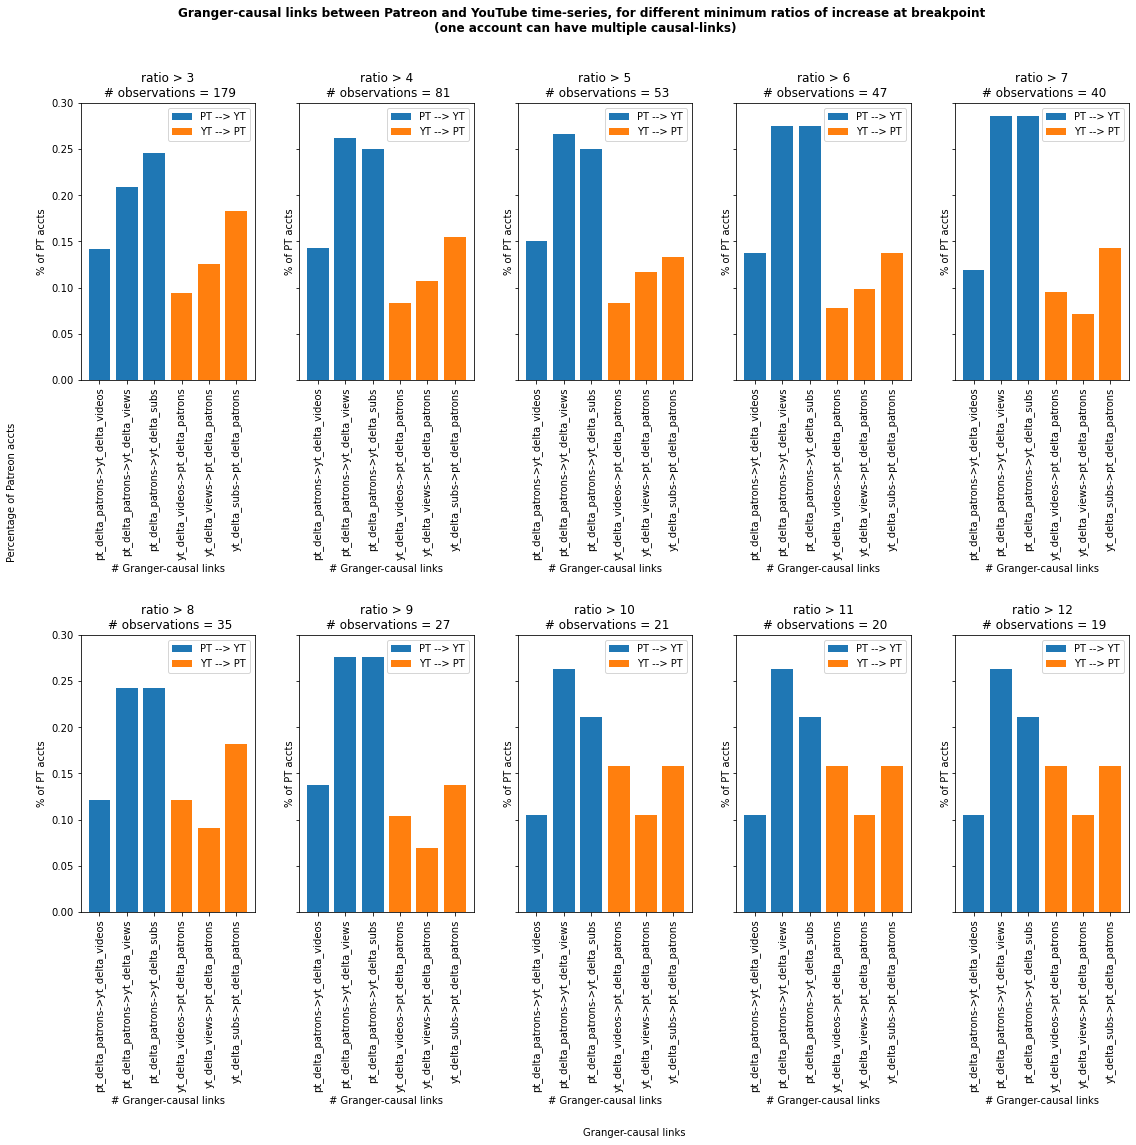

In [40]:
# For different minimum ratios of increase, plot sum of Granger-causal links between Patreon and YouTube time-series (in blue) and vice-versa (in orange)

nb_plots = 10
sbplt_cols = 5
sbplt_rows = int(nb_plots / sbplt_cols)

fig, axs = plt.subplots(sbplt_rows, sbplt_cols, figsize=(16,16), sharey=True, sharex=False)
for idx in range(0, nb_plots):
    
    row = math.floor(idx/sbplt_cols)
    col = idx % sbplt_cols
    sbplt = axs[row, col]
    
    increase_ratio = idx+INCR_RATIO_THRESH
    ratio_df = df_granger[df_granger['ratio_d1_d2'] > increase_ratio]
    
    # print(f'\n\nratio > {increase_ratio}:')
    # print(f'total number of accounts: {len(ratio_df)}:')
    # no_causal_links_df = ratio_df[ratio_df[cols1 + cols2].sum(axis=1) == 0]
    # print(f'nb accts with no Granger-causal links: {len(no_causal_links_df)} ({len(no_causal_links_df)/len(ratio_df):.0%})')
    # print(f'\nPatreon --> YouTube:')
    # print(ratio_df[cols1].sum())
    # print(f'\nYouTube --> Patreon:')
    # print(ratio_df[cols2].sum())
    
    granger_series = ratio_df[cols1 + cols2].sum()/ratio_df[cols1 + cols2].sum().sum()
    sbplt.bar(granger_series[cols1].index, granger_series[cols1].values, label='PT --> YT')
    sbplt.bar(granger_series[cols2].index, granger_series[cols2].values, label='YT --> PT')
    sbplt.set_title(f"ratio > {increase_ratio}\n # observations = {len(ratio_df)}")
    sbplt.set_xlabel("# Granger-causal links")
    sbplt.set_ylabel("% of PT accts")
    sbplt.tick_params(axis='x', labelrotation=90)
    sbplt.legend()


fig.suptitle('Granger-causal links between Patreon and YouTube time-series, for different minimum ratios of increase at breakpoint \n (one account can have multiple causal-links)', fontweight="bold")
fig.text(0.5,0, 'Granger-causal links')
fig.text(0,0.5, 'Percentage of Patreon accts ', rotation = 90)


fig.tight_layout(pad=3, w_pad=3)
plt.show()

**Observation**: Although there are granger links in both directions, we notice that there are more granger links going from Patreon --> YouTube, than YouTube --> Patreon

## 4. Observational Study

### 4.1 Select "treated" accounts

#### Change point detection _(see section 2.2)_

### 4.2 Select "control" accounts

#### Potential "control" accounts

- For each subject in “Treated” group (`df_treated`):
    - For each subject in `top_patreons` Population (except for current Treated subject):
        - Run breakpoint detection algorithm up to the Treated breakpoint date
            - If we find a breakpoint --> reject 
            - If we dont find a breakpoint --> add to _potential_ control subjects (aka “Potential Control Subjects”) for this Treated subject

In [41]:
# dict_potential_matches = {}  

# print(f"Look for potential matches for {len(df_treated)} treated subjects")

# for idx_treated, treated_subject_row in tqdm(df_treated.iterrows(), total=df_treated.shape[0]):
#     treated_subject = treated_subject_row['patreon_id']
#     # print(f"\ntreated subject: {idx_treated}, {treated_subject}")
    
#     # make sure date cant go beyond treated group
#     date_max = treated_subject_row['bkpt_date_add30']    
#     # print("date_max: ", date_max)
    
#     for idx_potential_control, potential_control_subject in enumerate(top_patreons):
#     # print(f"\n\tpotential control subject: {idx_potential_control}, {potential_control_subject}")        
        
#         # make sure potential control account is not the same as treated account         
#         if (potential_control_subject == treated_subject):
#             # print("potential_control_subject == treated_subject")
#             continue
            
#         # eliminate potential control accounts that have a breakpoint date earlier than treated
#         if (potential_control_subject not in df_treated['patreon_id'].tolist()):
#             # print("\t\tNo breakpoint for this account...      => KEEP AS A POTENTIAL CONTROL GROUP :)")
#             if treated_subject in dict_potential_matches:
#                 dict_potential_matches[treated_subject].append(potential_control_subject)
#             else:
#                 dict_potential_matches[treated_subject] = [potential_control_subject]
#         else: 
#             # if in the treated group but has a breakpoint after max date, consider it
#             if (df_treated[df_treated['patreon_id'] == potential_control_subject].bkpt_date.iloc[0] > date_max):
#                 # print("\t\tBreakpoint after the max date...      => KEEP AS A POTENTIAL CONTROL GROUP :)")
#                 if treated_subject in dict_potential_matches:
#                     dict_potential_matches[treated_subject].append(potential_control_subject)
#                 else:
#                     dict_potential_matches[treated_subject] = [potential_control_subject]
#             else:
#                 # reject it
#                 continue

In [42]:
# save potential dictionary matches to disk in pickle format
# output_file_path = LOCAL_DATA_FOLDER+"dict_potential_matches.pickle"
# with open(output_file_path, 'wb') as f:
#     pickle.dump(dict_potential_matches, f)

In [43]:
!ls -lh {LOCAL_DATA_FOLDER}dict_potential_matches.pickle

-rw-r--r-- 1 fmurray 30064 92K Jun  5 10:03 local_data/dict_potential_matches.pickle


In [44]:
with open(LOCAL_DATA_FOLDER+"dict_potential_matches.pickle", 'rb') as f:
    dict_potential_matches = pickle.load(f)

In [45]:
print(f"Total number of treated subjects: {len(dict_potential_matches)}")

print("\nNumber of potential control subjects for each treated subject (print first 5): ") 
for idx, (k, v) in enumerate(dict_potential_matches.items()):
    if idx <5:
        print(f'{k}: {len(v)}')
print("...")

Total number of treated subjects: 179

Number of potential control subjects for each treated subject (print first 5): 
patreon.com/blindwave: 252
patreon.com/thenormies: 265
patreon.com/bohobeautiful: 228
patreon.com/lindsayellis: 299
patreon.com/3blue1brown: 254
...


#### Pseudo intervention date (align bkpoint)

In [46]:
def align_breakpoint_dict(df, column, treated_subject_row):
    """
    Mathces the dates of the treated subject
    
    :param df: dataframe
    :param column: column to scan
    :param treated_subject_row: treated suject to get the dates from
    """
    
    bkpt_date_sub30   = treated_subject_row['bkpt_date_sub30'].iloc[0]
    bkpt_date         = treated_subject_row['bkpt_date'].iloc[0]
    bkpt_date_add30   = treated_subject_row['bkpt_date_add30'].iloc[0]
    bkpt_date_add60   = treated_subject_row['bkpt_date_add60'].iloc[0]
    bkpt_date_add90   = treated_subject_row['bkpt_date_add90'].iloc[0]

        
    # align points from subject conto control group
    try:        
        sub30 = df[df['date'] == bkpt_date_sub30]['patrons_ma'].iloc[0]
        point = df[df['date'] == bkpt_date]['patrons_ma'].iloc[0]
        add30 = df[df['date'] == bkpt_date_add30]['patrons_ma'].iloc[0]
        add60 = df[df['date'] == bkpt_date_add60]['patrons_ma'].iloc[0]
        add90 = df[df['date'] == bkpt_date_add90]['patrons_ma'].iloc[0]
    except Exception as e:
        # print("Exception in align_breakpoint_dict function (date issue): ", e)
        raise

    d1 = point - sub30
    d2 = add30 - point            
    d3 = add60 - add30            
    d4 = add90 - add60            

    # avoid  weird ratios obtained by diving by a difference between -1 and 1 
    if (0 <= d1 < 1):
        d1 = 1
    elif (-1 < d1 < 0):
        d1 = -1

    r_d1_d2 = d2 / d1

    # no condition since it's the control group
    bkpnt_dict = {
        "bkpt_date"         : bkpt_date,
        "bkpt_date_sub30"   : bkpt_date_sub30,
        "bkpt_date_add30"   : bkpt_date_add30,
        "bkpt_date_add60"   : bkpt_date_add60,
        "bkpt_date_add90"   : bkpt_date_add90,
        "avg_patrons_bkpnt" : point,
        "avg_patrons_sub30" : sub30,
        "avg_patrons_add30" : add30,
        "avg_patrons_add60" : add60,
        "avg_patrons_add90" : add90,
        "d1"                : d1,
        "d2"                : d2,
        "d3"                : d3,
        "d4"                : d4,
        "r_d1_d2"           : r_d1_d2
    }

    return bkpnt_dict

`align_breakpoint`

In [47]:
# creation pseudo intervention dates on potential control group
def align_breakpoints(treated_subject, potential_control_list, patreon_df, youtube_timeseries_df, youtube_meta_df):
    """
    for a treated subject in dict, 
    get breakpoint dates values of potential control accounts
    """
    # print(f"\n matching regions of potential control subjects for treated subject: {treated_subject}....)")
          
    # variables declaration
    MONTH_OFFSET = pd.DateOffset(months=1)
    ROLLING_AVG_WINDOW = 30
    potential_control_tuples = []


        
    treated_subject_row = df_treated[df_treated['patreon_id'] == treated_subject]
    bkpt_date_sub30   = treated_subject_row['bkpt_date_sub30'].iloc[0]
    bkpt_date         = treated_subject_row['bkpt_date'].iloc[0]
    bkpt_date_add30   = treated_subject_row['bkpt_date_add30'].iloc[0]
    bkpt_date_add60   = treated_subject_row['bkpt_date_add60'].iloc[0]
    bkpt_date_add90   = treated_subject_row['bkpt_date_add90'].iloc[0]
    
    # print("treated_subject_row:", treated_subject_row)
    # print("bkpt_date_sub30:", bkpt_date_sub30)    
    
    for idx, potential_control in enumerate(tqdm(potential_control_list)):
        # print("\t", idx, potential_control)
        treat = 0
        

        ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################
        # restrict to 1 patreon account, sort by date and drop duplicates

        # patreon earnings and users
        tmp_df_pt = restrict_acct_and_sort_df(patreon_df, 'patreon', potential_control, 'date')

        # sanity checks to make sure the treated date range exist in potential_control_df
        if (tmp_df_pt[tmp_df_pt['date'] == bkpt_date_sub30].empty) or (tmp_df_pt[tmp_df_pt['date'] == bkpt_date_add90].empty):
            # print("skip Patreon account as the range dates dont exist")
            continue
            
        
        # youtube videos
        tmp_df_yt = restrict_acct_and_sort_df(youtube_timeseries_df, 'patreon_id', potential_control, 'datetime')
            

        # youtube metadata
        tmp_df_yt_meta = restrict_acct_and_sort_df(youtube_meta_df, 'patreon_id', potential_control, 'upload_date')

        ########################## RESTRICT DATES FOR ZOOM OUT ##########################

        # set min and max dates for plots   
        date_min = max([tmp_df_yt['datetime'].min(), tmp_df_pt['date'].min()])
        date_max = min([tmp_df_yt['datetime'].max(), tmp_df_pt['date'].max()])

        # if no overlap period between YT and Patreon datasets, skip account
        if date_max < date_min:
            # print(f":( no overlapping period between YouTube and Patreon datasets\n")
            continue

        # restrict datasets between min and max dates
        tmp_df_pt = tmp_df_pt[(tmp_df_pt['date'] >= date_min) & (tmp_df_pt['date'] <= date_max)]
        tmp_df_yt = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min) & (tmp_df_yt['datetime'] <= date_max)]

        # align both dataframes since youtube starts once a week
        tmp_df_pt = tmp_df_pt[tmp_df_pt['date'] >= tmp_df_yt['datetime'].min()]




        ########################## PATREON: CALCULATE MOVING AVERAGE AND WEEKLY DELTAS ##########################

        tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
        tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
        ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index

        # resample time series to get 7 days intervals in order to calculate weekly deltas
        ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
        ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
        ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
        ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
        tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT

        # reorder columns to have deltas columns next to their respective columns
        patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
        ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]

        # convert Float64 columns to float64 to avoid Matplotlib NAType error
        ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})



        ########################## PRINT TITLES ##########################
        # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
        # ch_ids = tmp_df_yt['channel'].unique()
        # print(f"\n\033[1mRank {idx+1}: {patreon[12:]} \033[0m")

        ########################## ALIGN CONTROL ACCOUNT TO TREATED BREAKPOINT AND REJECT PATREON ACCOUNT IF NOT VALID ##########################

        try:
            bkpnt_dict = align_breakpoint_dict(tmp_df_pt, 'patrons_ma', treated_subject_row)

        except Exception as e:
                print("Exception in align_breakpoint_dict function: ", e)
                continue            
                              
                
        ################################### CALCULATE DELTA MEANS BEFORE AND AFTER BKPOINT ###################################  

        ##### PATREON #####
        tmp_df_PT_sub30 = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= bkpnt_dict['bkpt_date_sub30']) & (ts_pt_weekly_avg_df_float64.index <= bkpnt_dict['bkpt_date'])]
        tmp_df_PT_add30 = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= bkpnt_dict['bkpt_date']) & (ts_pt_weekly_avg_df_float64.index <= bkpnt_dict['bkpt_date_add30'])]
        tmp_df_PT_add60 = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= bkpnt_dict['bkpt_date_add30']) & (ts_pt_weekly_avg_df_float64.index <= bkpnt_dict['bkpt_date_add60'])]
        tmp_df_PT_add90 = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= bkpnt_dict['bkpt_date_add60']) & (ts_pt_weekly_avg_df_float64.index <= bkpnt_dict['bkpt_date_add90'])]

        # delta patrons
        mean_delta_patrons_sub30 = tmp_df_PT_sub30['delta_patrons'].mean()
        mean_delta_patrons_add30 = tmp_df_PT_add30['delta_patrons'].mean()
        mean_delta_patrons_add60 = tmp_df_PT_add60['delta_patrons'].mean()
        mean_delta_patrons_add90 = tmp_df_PT_add90['delta_patrons'].mean()

        # delta earnings
        mean_delta_earnings_sub30 = tmp_df_PT_sub30['delta_earning'].mean()
        mean_delta_earnings_add30 = tmp_df_PT_add30['delta_earning'].mean()  
        mean_delta_earnings_add60 = tmp_df_PT_add60['delta_earning'].mean()  
        mean_delta_earnings_add90 = tmp_df_PT_add90['delta_earning'].mean()  


        ##### YOUTUBE TIME SERIES #####
        tmp_df_YT_sub30 = tmp_df_yt[(tmp_df_yt['datetime'] >= bkpnt_dict['bkpt_date_sub30']) & (tmp_df_yt['datetime'] <= bkpnt_dict['bkpt_date']      )]
        tmp_df_YT_add30 = tmp_df_yt[(tmp_df_yt['datetime'] >= bkpnt_dict['bkpt_date']      ) & (tmp_df_yt['datetime'] <= bkpnt_dict['bkpt_date_add30'])]
        tmp_df_YT_add60 = tmp_df_yt[(tmp_df_yt['datetime'] >= bkpnt_dict['bkpt_date_add30']) & (tmp_df_yt['datetime'] <= bkpnt_dict['bkpt_date_add60'])]
        tmp_df_YT_add90 = tmp_df_yt[(tmp_df_yt['datetime'] >= bkpnt_dict['bkpt_date_add60']) & (tmp_df_yt['datetime'] <= bkpnt_dict['bkpt_date_add90'])]

        # delta videos
        mean_delta_videos_sub30 = tmp_df_YT_sub30['delta_videos'].mean()
        mean_delta_videos_add30 = tmp_df_YT_add30['delta_videos'].mean()  
        mean_delta_videos_add60 = tmp_df_YT_add60['delta_videos'].mean()  
        mean_delta_videos_add90 = tmp_df_YT_add90['delta_videos'].mean()  

        # delta views
        mean_delta_views_sub30 = tmp_df_YT_sub30['delta_views'].mean()
        mean_delta_views_add30 = tmp_df_YT_add30['delta_views'].mean()  
        mean_delta_views_add60 = tmp_df_YT_add60['delta_views'].mean()  
        mean_delta_views_add90 = tmp_df_YT_add90['delta_views'].mean()  

        # delta subscriptions
        mean_delta_subs_sub30 = tmp_df_YT_sub30['delta_subs'].mean()
        mean_delta_subs_add30 = tmp_df_YT_add30['delta_subs'].mean()  
        mean_delta_subs_add60 = tmp_df_YT_add60['delta_subs'].mean()  
        mean_delta_subs_add90 = tmp_df_YT_add90['delta_subs'].mean()  


        ##### YOUTUBE METADATA #####
        tmp_df_YT_META_sub30 = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= bkpnt_dict['bkpt_date_sub30']) & (tmp_df_yt_meta['upload_date'] <= bkpnt_dict['bkpt_date']      )]
        tmp_df_YT_META_add30 = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= bkpnt_dict['bkpt_date']      ) & (tmp_df_yt_meta['upload_date'] <= bkpnt_dict['bkpt_date_add30'])]
        tmp_df_YT_META_add60 = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= bkpnt_dict['bkpt_date_add30']) & (tmp_df_yt_meta['upload_date'] <= bkpnt_dict['bkpt_date_add60'])]
        tmp_df_YT_META_add90 = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= bkpnt_dict['bkpt_date_add60']) & (tmp_df_yt_meta['upload_date'] <= bkpnt_dict['bkpt_date_add90'])]

        # durations
        mean_duration_sub30 = tmp_df_YT_META_sub30['duration'].mean()
        mean_duration_add30 = tmp_df_YT_META_add30['duration'].mean()      
        mean_duration_add60 = tmp_df_YT_META_add60['duration'].mean()      
        mean_duration_add90 = tmp_df_YT_META_add90['duration'].mean()      

        # likes
        mean_likes_sub30 = tmp_df_YT_META_sub30['like_count'].mean()
        mean_likes_add30 = tmp_df_YT_META_add30['like_count'].mean()      
        mean_likes_add60 = tmp_df_YT_META_add60['like_count'].mean()      
        mean_likes_add90 = tmp_df_YT_META_add90['like_count'].mean()     


        # get youtube channel id name
        yt_channel_id = tmp_df_yt['channel'].unique()[0]


        potential_control_tuples.append(
            (          
                potential_control, 
                yt_channel_id,   
                treat,
                bkpnt_dict["d1"], 
                bkpnt_dict["d2"], 
                bkpnt_dict["d3"], 
                bkpnt_dict["d4"], 

                bkpnt_dict["r_d1_d2"],

                bkpnt_dict["bkpt_date"], 
                bkpnt_dict["bkpt_date_sub30"], 
                bkpnt_dict["bkpt_date_add30"],
                bkpnt_dict["bkpt_date_add60"],
                bkpnt_dict["bkpt_date_add90"],

                bkpnt_dict["avg_patrons_bkpnt"], 
                bkpnt_dict["avg_patrons_sub30"], 
                bkpnt_dict["avg_patrons_add30"], 
                bkpnt_dict["avg_patrons_add60"], 
                bkpnt_dict["avg_patrons_add90"], 

                # delta patrons
                mean_delta_patrons_sub30,
                mean_delta_patrons_add30,
                mean_delta_patrons_add60,
                mean_delta_patrons_add90,

                # delta earnings
                mean_delta_earnings_sub30,
                mean_delta_earnings_add30,
                mean_delta_earnings_add60, 
                mean_delta_earnings_add90,

                # delta videos
                mean_delta_videos_sub30,
                mean_delta_videos_add30,
                mean_delta_videos_add60,
                mean_delta_videos_add90,

                # delta views
                mean_delta_views_sub30,
                mean_delta_views_add30,
                mean_delta_views_add60,
                mean_delta_views_add90,

                # delta subscriptions
                mean_delta_subs_sub30,
                mean_delta_subs_add30,
                mean_delta_subs_add60,
                mean_delta_subs_add90,

                # durations
                mean_duration_sub30,
                mean_duration_add30,     
                mean_duration_add60,    
                mean_duration_add90, 

                # likes
                mean_likes_sub30,
                mean_likes_add30,  
                mean_likes_add60,   
                mean_likes_add90
            )
        )



    df_potential_control = pd.DataFrame(potential_control_tuples, columns = [
        'patreon_id',
        'yt_channel_id',
        'treat',
        'd1', 
        'd2', 
        'd3',
        'd4',

        'ratio_d1_d2',
        'bkpt_date',     
        'bkpt_date_sub30', 
        'bkpt_date_add30', 
        'bkpt_date_add60',
        'bkpt_date_add90',

        'avg_patrons_bkpnt', 
        'avg_patrons_sub30', 
        'avg_patrons_add30', 
        'avg_patrons_add60',
        'avg_patrons_add90',

        # delta patrons
        'mean_delta_patrons_sub30',
        'mean_delta_patrons_add30',
        'mean_delta_patrons_add60',
        'mean_delta_patrons_add90',

        # delta earnings
        'mean_delta_earnings_sub30',
        'mean_delta_earnings_add30',
        'mean_delta_earnings_add60',
        'mean_delta_earnings_add90',

        # delta videos
        'mean_delta_videos_sub30',
        'mean_delta_videos_add30',
        'mean_delta_videos_add60',
        'mean_delta_videos_add90',

        # delta views
        'mean_delta_views_sub30',
        'mean_delta_views_add30',
        'mean_delta_views_add60',
        'mean_delta_views_add90',

        # delta subscriptions
        'mean_delta_subs_sub30',
        'mean_delta_subs_add30',
        'mean_delta_subs_add60',
        'mean_delta_subs_add90',

        # durations
        'mean_duration_sub30',
        'mean_duration_add30',
        'mean_duration_add60',
        'mean_duration_add90',

        # likes
        'mean_likes_sub30',
        'mean_likes_add30',
        'mean_likes_add60',
        'mean_likes_add90'
    ])



    print(f'Number of Patreon accounts added to the potential_control group:  {len(df_potential_control)}')

    df_potential_control['bkpt_date'] = pd.to_datetime(df_potential_control['bkpt_date'])
    df_potential_control['bkpt_date_sub30'] = pd.to_datetime(df_potential_control['bkpt_date_sub30'])
    df_potential_control['bkpt_date_add30'] = pd.to_datetime(df_potential_control['bkpt_date_add30'])
    df_potential_control['bkpt_date_add60'] = pd.to_datetime(df_potential_control['bkpt_date_add60'])
    df_potential_control['bkpt_date_add90'] = pd.to_datetime(df_potential_control['bkpt_date_add90'])


    df_treat = pd.concat([treated_subject_row, df_potential_control]).reset_index(drop=True)
    return df_treat

##### Create DataFrame with potential control subjects per treated 

In [48]:
# # create a DF with treated and potential control accounts (takes about 2h15)
# exceptions = 0
# all_treat_and_potential_control_df = pd.DataFrame()

# print(f'Iterate over {len(dict_potential_matches)} treated accounts...')
# for idx, (treated_subject, potential_control_list) in enumerate(tqdm(dict_potential_matches.items())):
#     # if idx >= 10:
#     #     break
#     # print(f"\nidx: {idx}, treated_subject: {treated_subject}")
#     try: 
#         df_treat = align_breakpoints(treated_subject, potential_control_list, df_top_pt_accts, df_yt_timeseries_top_pt, df_yt_metadata_pt_filtered)

#     except Exception as e: 
#         exceptions += 1
#         # print("Exception: ", e)
#         continue
        
#     df_treat['treated_patreon_id'] = treated_subject
#     all_treat_and_potential_control_df = pd.concat([all_treat_and_potential_control_df, df_treat])
    
# print("total number of exceptions: ", exceptions)

# # move treated_patreon_id column at the beginning of the df
# first_column = all_treat_and_potential_control_df.pop('treated_patreon_id')  
# all_treat_and_potential_control_df.insert(0, 'treated_patreon_id', first_column)

# print("all_treat_and_potential_control_df: ")
# all_treat_and_potential_control_df

In [49]:
# # save "all_treat_and_potential_control_df" dataframe to LOCAL SCRATCH FOLDER as a compressed tsv
# output_file_path = LOCAL_DATA_FOLDER+"all_treat_and_potential_control_df.tsv.gz"
# all_treat_and_potential_control_df.to_csv(output_file_path, index=False, sep='\t', compression='gzip')
# !ls -lh {LOCAL_DATA_FOLDER}all_treat_and_potential_control_df.tsv.gz

---

### 4.3 Naive analysis
Compare the distribution of the outcome variables (`mean_delta_videos_add30`, `mean_delta_views_add30`, `mean_delta_subs_add30`, `mean_duration_add30`) between the two groups, using plots and numbers. 

In [50]:
all_treat_and_potential_control_df = pd.read_csv(LOCAL_DATA_FOLDER+"all_treat_and_potential_control_df.tsv.gz", sep="\t", compression='gzip')

#### Split "treated" VS "non-treated" Patreon accounts

We choose the following caracteristics for the Treated vs Non-Treated accounts:

    
- **Treated** accounts
    - accounts for which we have detected breakpoints in section 2.2


- **Non-Treated / Control** accounts
    - all the other accounts. 
    
**Important Note**: since we have selected multiple potential Control accounts for each Treated account among the same pool of accounts, and we have not done the matching yet, some Control accounts are being duplicated (with different "alignement" dates) accross different potential control groups. This results in far more potential Control accounts than Treated accounts (~130 control accounts for 1 treated account)

In [51]:
treated = all_treat_and_potential_control_df[all_treat_and_potential_control_df['treat'] == 1]
control = all_treat_and_potential_control_df[all_treat_and_potential_control_df['treat'] == 0]

print(f'Total number of accounts (some being duplicated accross potential control groups) : {len(all_treat_and_potential_control_df):>6,}')
print(f'Number of treated accounts (with a breakpoint)                                    : {len(treated):>6,}')
print(f'Number of potential control accounts (without a breakpoint)                       : {len(control):>6,}')
print(f'Avg number of potential control accounts per treated accounts                     ~ {len(control)/len(treated):>6,.0f}')
with pd.option_context('display.max_rows', 150, 'display.min_rows', 150, 'display.max_columns', 50):
    display(all_treat_and_potential_control_df.head())

Total number of accounts (some being duplicated accross potential control groups) : 23,399
Number of treated accounts (with a breakpoint)                                    :    179
Number of potential control accounts (without a breakpoint)                       : 23,220
Avg number of potential control accounts per treated accounts                     ~    130


treated_patreon_id                       patreon_id  \
0  patreon.com/blindwave            patreon.com/blindwave   
1  patreon.com/blindwave         patreon.com/swiftlessons   
2  patreon.com/blindwave           patreon.com/pauldavids   
3  patreon.com/blindwave  patreon.com/everyframeapainting   
4  patreon.com/blindwave        patreon.com/abroadinjapan   

              yt_channel_id  treat          d1          d2          d3  \
0  UCs1APU4_lj3PgZz2B4HeadA      1   28.600000  359.633333  437.866667   
1  UCjdxyPMmtiBLrmsM2Ok-AUg      0  162.000000  132.866667  140.533333   
2  UC_Oa7Ph3v94om5OyxY1nPKg      0  128.700000  235.366667  151.500000   
3  UCjFqcJQXGZ6T6sxyFB-5i6A      0   64.200000   60.433333   36.566667   
4  UCHL9bfHTxCMi-7vfxQ-AYtg      0  107.733333  104.600000   40.933333   

           d4  ratio_d1_d2   bkpt_date bkpt_date_sub30 bkpt_date_add30  \
0  801.700000    12.574592  2017-05-05      2017-04-05      2017-06-04   
1  135.133333     0.820165  2017-05-05      2017-04-05      2017-06-04   
2  126.200000     1.828801  2017-05-05      2017-04-05      2017-06-04   
3   21.666667     0.941329  2017-05-05      2017-04-05      2017-06-04   
4   43.766667     0.970916  2017-05-05      2017-04-05      2017-06-04   

  bkpt_date_add60 bkpt_date_add90  avg_patrons_bkpnt  avg_patrons_sub30  \
0      2017-07-04      2017-08-03        2709.066667        2680.466667   
1      2017-07-04      2017-08-03        1585.666667        1423.666667   
2      2017-07-04      2017-08-03         145.300000          16.600000   
3      2017-07-04      2017-08-03        4310.833333        4246.633333   
4      2017-07-04      2017-08-03        1427.466667        1319.733333   

   avg_patrons_add30  avg_patrons_add60  avg_patrons_add90  \
0        3068.700000        3506.566667        4308.266667   
1        1718.533333        1859.066667        1994.200000   
2         380.666667         532.166667         658.366667   
3        4371.266667        4407.833333        4429.500000   
4        1532.066667        1573.000000        1616.766667   

   mean_delta_patrons_sub30  mean_delta_patrons_add30  \
0                  4.607143                 96.250000   
1                 38.071429                 31.428571   
2                 29.785714                 61.107143   
3                 14.142857                 14.464286   
4                 20.857143                 28.642857   

   mean_delta_patrons_add60  mean_delta_patrons_add90  \
0                100.942857                171.214286   
1                 32.628571                 29.035714   
2                 30.885714                 31.428571   
3                  8.771429                  4.678571   
4                  7.571429                  8.892857   

   mean_delta_earnings_sub30  mean_delta_earnings_add30  \
0                  -2.671429                 373.442857   
1                        NaN                        NaN   
2                 142.650357                 297.371786   
3                  18.305714                  22.998214   
4                  31.112857                  51.523214   

   mean_delta_earnings_add60  mean_delta_earnings_add90  \
0                 504.437143                1936.496429   
1                        NaN                        NaN   
2                 190.878095                        NaN   
3                  -0.642857                   5.271786   
4                  13.610000                  15.752857   

   mean_delta_videos_sub30  mean_delta_videos_add30  mean_delta_videos_add60  \
0                     12.0                    14.25                     21.2   
1                      1.5                     1.25                      2.0   
2                      1.0                     1.25                      0.8   
3                      0.0                     0.00                      0.0   
4                      0.5                     0.00                      0.6   

   mean_delta_videos_add90  mean_delta_views_sub

In [52]:
outcome_variables = ['mean_delta_videos_add30', 'mean_delta_views_add30', 'mean_delta_subs_add30', 'mean_duration_add30']
outcome_delta_variables = ['mean_delta_videos_add30', 'mean_delta_views_add30', 'mean_delta_subs_add30', 'mean_duration_add30']
print("Descriptive statistics of the outcome variables during month after breakpoint\n")
print("Treated group:")
display(treated[outcome_variables].describe().T)

print("Control group")
display(control[outcome_variables].describe().T)


Descriptive statistics of the outcome variables during month after breakpoint

Treated group:


count           mean            std        min  \
mean_delta_videos_add30  179.0       2.676188       3.616665      0.000   
mean_delta_views_add30   179.0  778290.713148  912731.080614  13904.125   
mean_delta_subs_add30    179.0    5842.744810    8142.257506      0.000   
mean_duration_add30      165.0     909.047879     728.797626     71.000   

                                   25%            50%            75%  \
mean_delta_videos_add30       0.750000       1.250000       3.200000   
mean_delta_views_add30   213468.537760  497833.774740  988646.731532   
mean_delta_subs_add30      1328.692708    3288.076823    6466.700521   
mean_duration_add30         440.200000     725.000000    1116.000000   

                                 max  
mean_delta_videos_add30       21.600  
mean_delta_views_add30   5994321.400  
mean_delta_subs_add30      66787.375  
mean_duration_add30         3892.000

Control group


count           mean            std  min  \
mean_delta_videos_add30  23220.0       2.085553       2.744512  0.0   
mean_delta_views_add30   23220.0  489755.062914  620181.350538  0.0   
mean_delta_subs_add30    23220.0    3228.963521    5227.358094  0.0   
mean_duration_add30      18943.0    1030.109499    1144.249591  5.0   

                                   25%          50%            75%  \
mean_delta_videos_add30       0.500000       1.0000       2.500000   
mean_delta_views_add30   145349.261785  291123.0125  626227.666132   
mean_delta_subs_add30       893.234375    1939.3875    3934.000000   
mean_duration_add30         498.309524     721.0000    1111.285714   

                                  max  
mean_delta_videos_add30  2.725000e+01  
mean_delta_views_add30   1.291978e+07  
mean_delta_subs_add30    1.559518e+05  
mean_duration_add30      2.782650e+04

#### Explore outcome variables' distribution

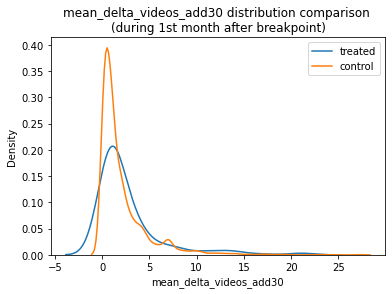

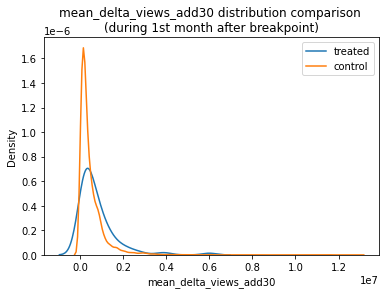

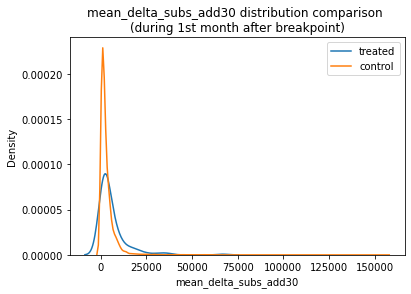

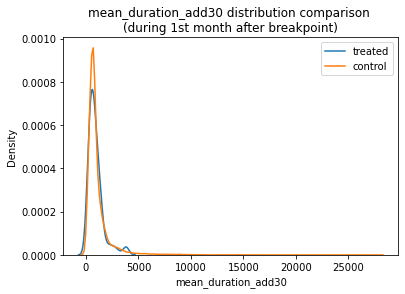

In [53]:
for column in outcome_delta_variables:
    ax = sns.kdeplot(treated[column], label='treated')
    ax = sns.kdeplot(control[column], label='control')
    ax.set(title=f'{column} distribution comparison \n(during 1st month after breakpoint)', xlabel=column, ylabel='Density')
    plt.legend()
    plt.show()

#### Pairplots

In [54]:
features = [
    'treat','d1', 'd2', 'ratio_d1_d2','bkpt_date', 'avg_patrons_sub30', 'mean_delta_patrons_sub30', 'mean_delta_earnings_sub30', 
    'mean_delta_videos_sub30', 'mean_delta_views_sub30','mean_delta_subs_sub30', 'mean_duration_sub30']

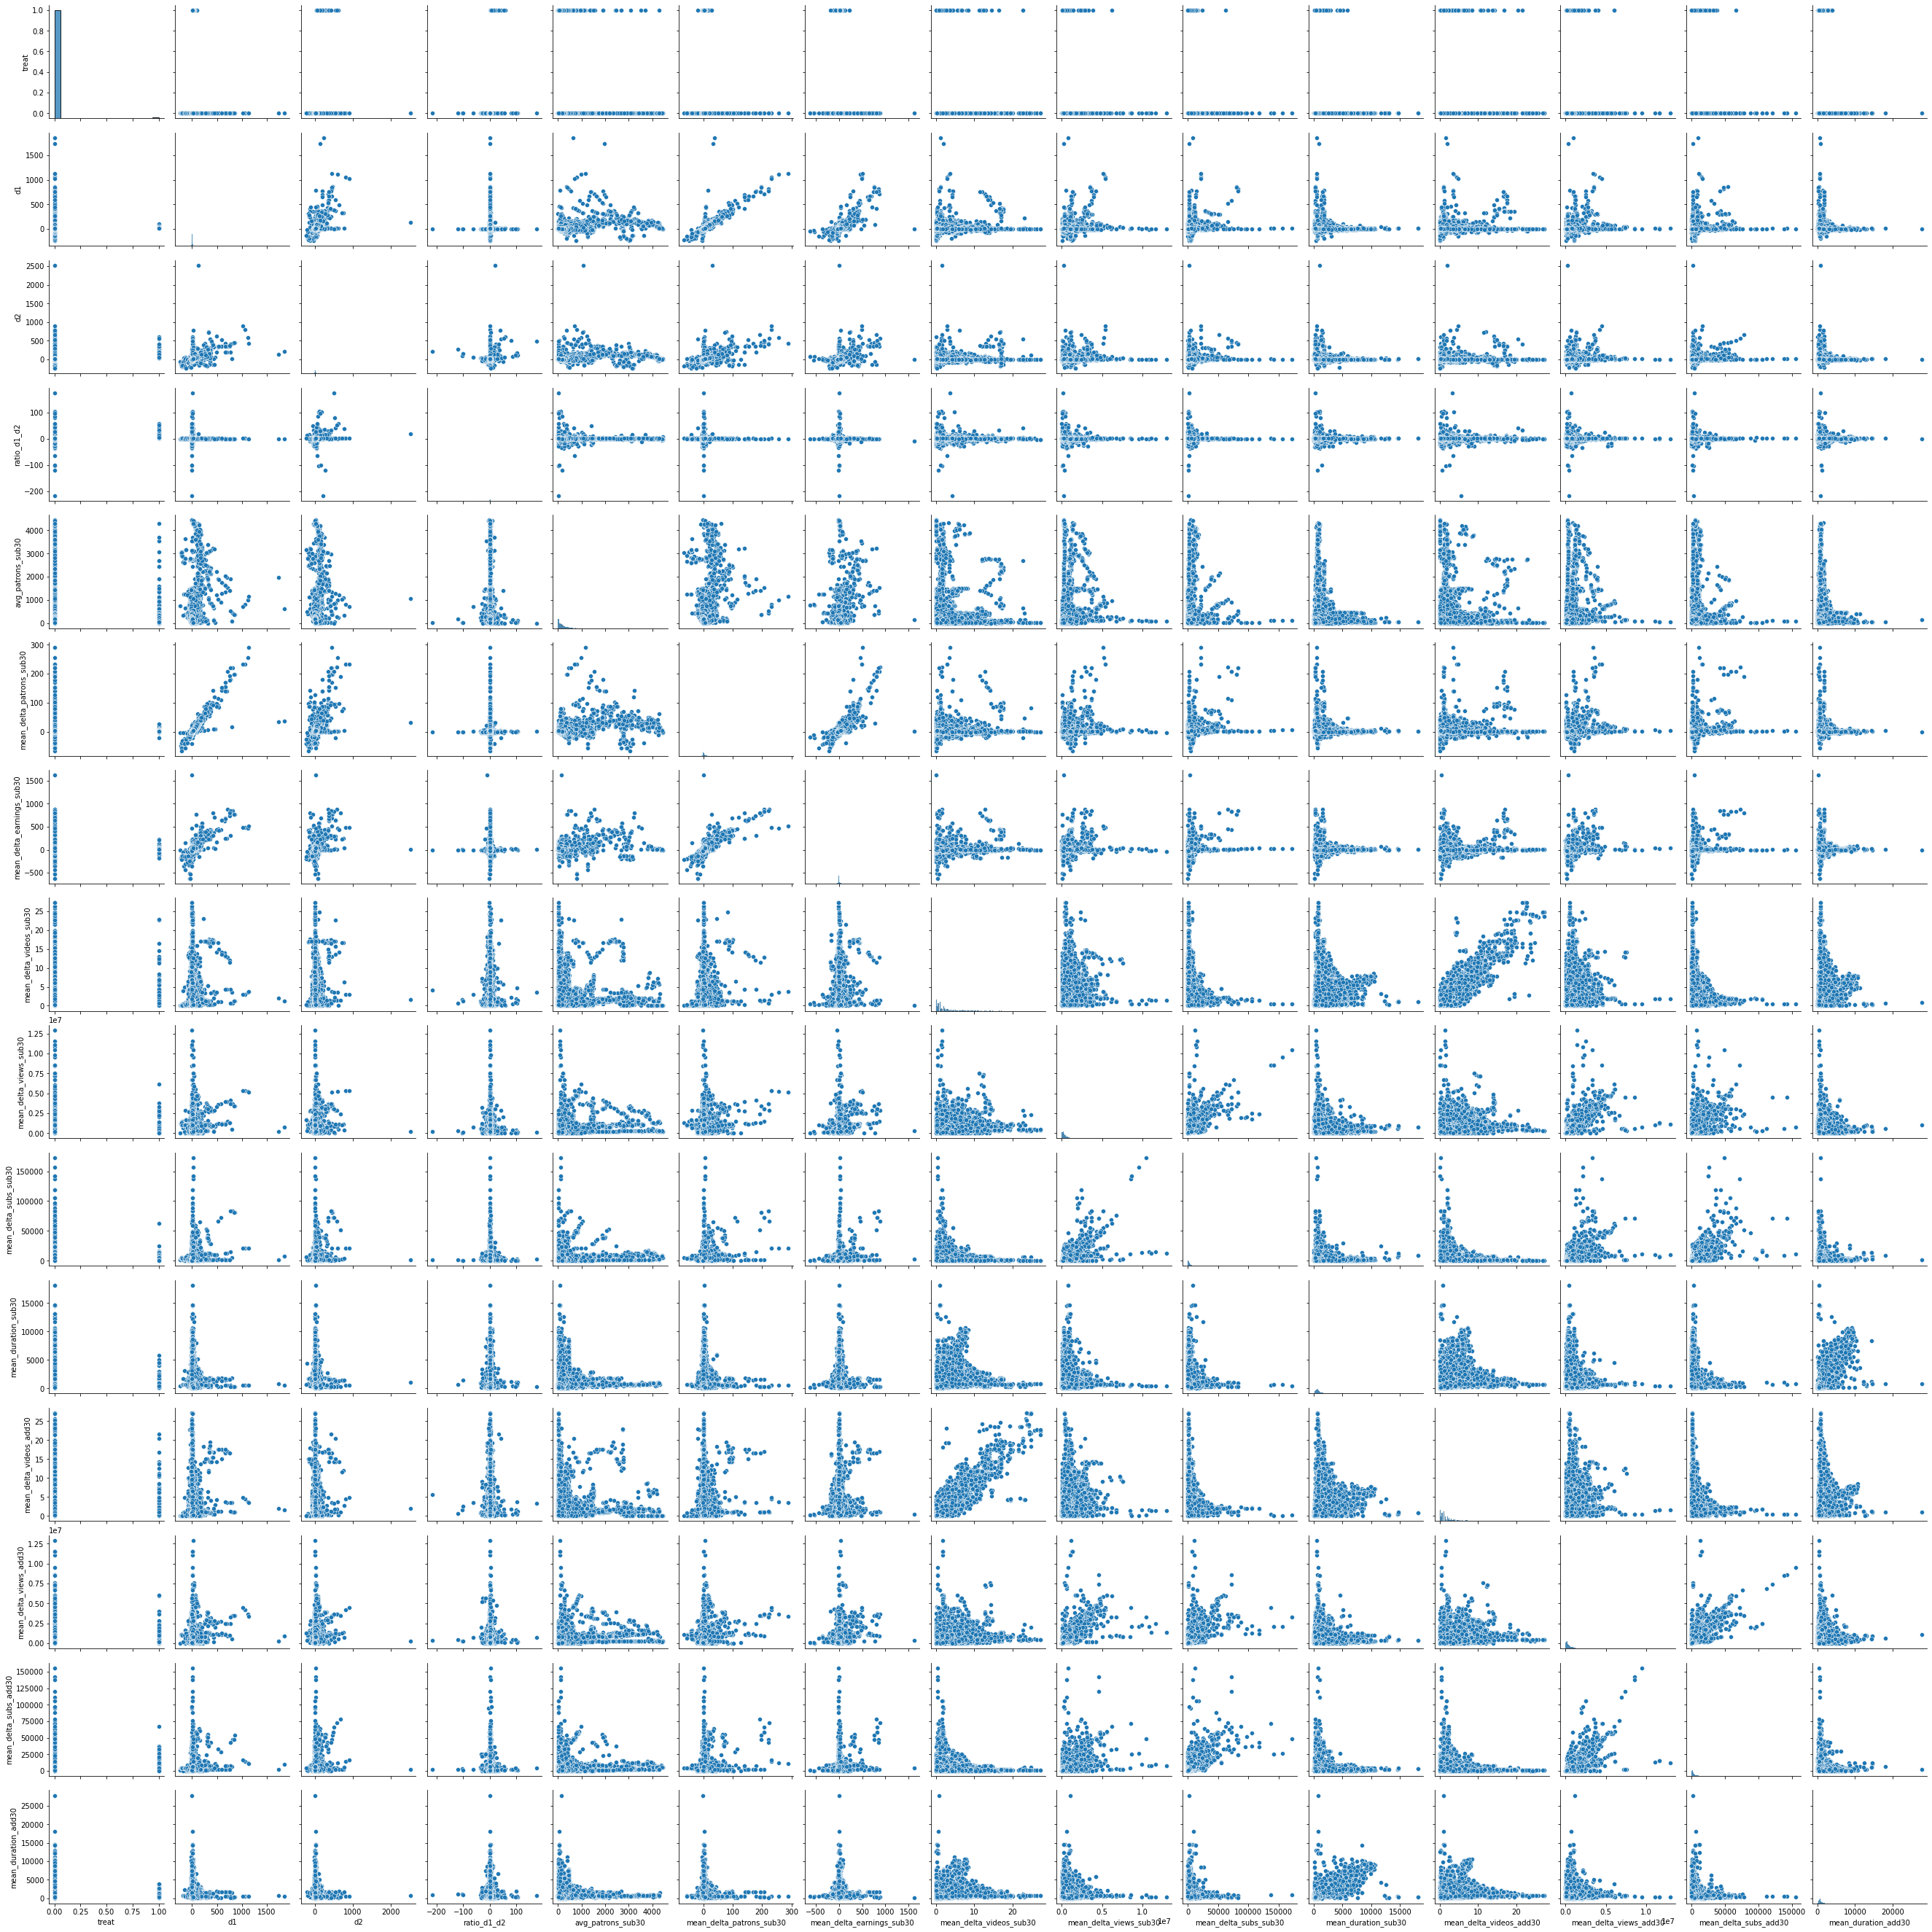

In [55]:
# Plot pairwise relationships
sns.pairplot(all_treat_and_potential_control_df[features + outcome_variables])
plt.show()

#### Boxplots

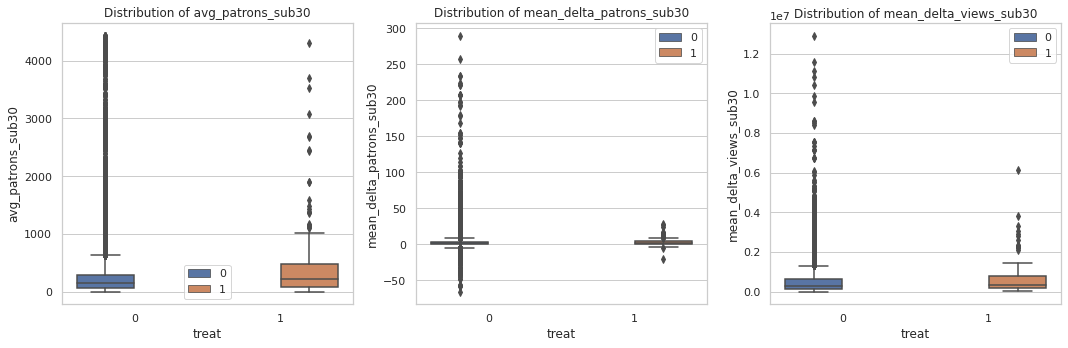

In [56]:
# SHAREX = 'row'
# SHAREY = 'row'
SHAREX = False
SHAREY = False

sns.set_theme(style="whitegrid")

selected_cols = ['avg_patrons_sub30', 'mean_delta_patrons_sub30', 'mean_delta_views_sub30']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=SHAREX, sharey=SHAREY)
for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.boxplot(x='treat', y=col, hue='treat', data=all_treat_and_potential_control_df, ax=ax)
    ax.set(title=f'Distribution of {col}')
    ax.legend()
plt.tight_layout()
plt.show()


### 4.4 Propensity Score Matching (PSM)
_(this section has been inspired by ADA 2021 Observational study exercise session by Tiziano Piccardi and Kristina Gligoric)_

#### Propensity score model
-  Use logistic regression to estimate propensity scores for all Patreon accounts in the dataset. 
-  Use statsmodels to fit the logistic regression model and apply it to each account to obtain its propensity score.

The propensity score of an account represents its probability of receiving the treatment, based on its pre-treatment features


- **Treatment** (binary variable):
    - `treat` = 1 (treatment group), if we detect a breakpoint
    - `treat` = 0 (control group), if we don't detect a breakpoint
        
- **Outcome**
    - `mean_delta_videos_after`: YouTube delta views (post-treatment)
    
- **Observed covariates:**
    - `mean_delta_patrons_sub30`: Patreon delta patrons mean (pre-treatment) 
    - `mean_delta_videos_sub30`: YouTube delta videos mean (pre-treatment) 
    - `mean_delta_views_sub30`:  YouTube delta views mean (pre-treatment) 
    - `mean_delta_subs_sub30`:   YouTube delta subs mean (pre-treatment) 
    - (`mean_duration_sub30`:     YouTube video duration mean (pre-treatment))
    
    
    
_Note: "pre-treatment" = month (30 days) before breakpoint and "post-treatement" = 1 month (30 days) after breakpoint_

#### Compute Propensity score and match pairs

In [57]:
continuous_features = [
    'd1', 'd2', 'd3', 'd4',
    'ratio_d1_d2',
    'avg_patrons_sub30', 'avg_patrons_bkpnt', 'avg_patrons_add30', 'avg_patrons_add60', 'avg_patrons_add90',
    'mean_delta_patrons_sub30', 'mean_delta_patrons_add30', 'mean_delta_patrons_add60', 'mean_delta_patrons_add90',
    'mean_delta_earnings_sub30', 'mean_delta_earnings_add30', 'mean_delta_earnings_add60','mean_delta_earnings_add90',
    'mean_delta_videos_sub30', 'mean_delta_videos_add30', 'mean_delta_videos_add60', 'mean_delta_videos_add90',
    'mean_delta_views_sub30','mean_delta_views_add30', 'mean_delta_views_add60', 'mean_delta_views_add90',
    'mean_delta_subs_sub30', 'mean_delta_subs_add30', 'mean_delta_subs_add60', 'mean_delta_subs_add90',
    'mean_duration_sub30', 'mean_duration_add30', 'mean_duration_add60', 'mean_duration_add90',
    'mean_likes_sub30', 'mean_likes_add30', 'mean_likes_add60', 'mean_likes_add90'
]

In [58]:
def standardize_features(df, features_list):
    # standardize the continuous features
    df_std = df.copy()
    for feature in features_list:
        df_std[feature] = (df_std[feature] - df_std[feature].mean())/df_std[feature].std()
    
    return df_std

In [59]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [60]:
def maximum_weight_matching(df):
    # Separate the treatment and control groups
    treatment_df = df[df['treat'] == 1]
    control_df   = df[df['treat'] == 0]

    # Create an empty undirected graph
    G = nx.Graph()

    # Loop through all the pairs of instances
    for treatment_id, treatment_row in treatment_df.iterrows():
        for control_id, control_row in control_df.iterrows():

            # Calculate the similarity 
            similarity = get_similarity(control_row['Propensity_score'],
                                        treatment_row['Propensity_score'])

            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

    # Generate and return the maximum weight matching on the generated graph
    matching = nx.max_weight_matching(G)
    return matching

In [61]:
#suppress warnings
warnings.filterwarnings('ignore')


all_treat_and_potential_control_df.groupby('treated_patreon_id')['patreon_id'].count()
treated_subjects = all_treat_and_potential_control_df.treated_patreon_id.unique()


# match pairs
exceptions = 0
all_pairs_df = pd.DataFrame()
match_pairs_dict = {} # treatment: control
display_cols = ['patreon_id', 'treat', 'Propensity_score', 'd1', 'd2', 'ratio_d1_d2', 'bkpt_date', 'avg_patrons_sub30', 'mean_delta_videos_sub30', 'mean_delta_views_sub30', 'mean_delta_subs_sub30', 'mean_duration_sub30']
non_na_cols  = ['patreon_id', 'treat', 'd1', 'd2', 'ratio_d1_d2', 'bkpt_date', 'avg_patrons_sub30', 'mean_delta_videos_sub30', 'mean_delta_views_sub30', 'mean_delta_subs_sub30']

print(f'Iterate over {len(treated_subjects)} treated accounts...')
# for idx, (treated_subject, potential_control_list) in enumerate(tqdm(dict_potential_matches.items())):
for idx, treated_subject in enumerate(tqdm(treated_subjects)):
    # print(f"\nidx: {idx}, treated_subject: {treated_subject}")
    
    # restrict dataframe to this treated account
    df_treat = all_treat_and_potential_control_df[all_treat_and_potential_control_df['treated_patreon_id'] == treated_subject]
    
    
    try: 
        # drop rows only from control accounts which have NA values in the columns of interest
        df_treat = df_treat.drop(df_treat[(df_treat['treat'] == 0) & (df_treat[non_na_cols].isna().any(axis=1))].index)
        df_treat = df_treat.reset_index(drop=True)

        df_treat_std = standardize_features(df_treat, continuous_features)

        #### GET PROPENSITY SCORE ####
        # Declare the model
        mod = smf.logit(formula='treat ~  mean_delta_patrons_sub30 + mean_delta_videos_sub30 + mean_delta_views_sub30 + mean_delta_subs_sub30', data=df_treat_std)
        
        # Fits the model (find the optimal coefficients
        res = mod.fit(disp=0, warn_convergence=True)

        # Extract the estimated propensity scores 
        df_treat['Propensity_score'] = res.predict()
        df_treat_std['Propensity_score'] = res.predict() 
        # print(res.summary())

        #### MATCH PAIRS ####
        matching_pair = maximum_weight_matching(df_treat)
        matched_list = [i[0] for i in list(matching_pair)] + [i[1] for i in list(matching_pair)]
        matched_pair_df = df_treat.iloc[matched_list]


        match_pairs_dict[matched_pair_df[matched_pair_df.treat == 1].patreon_id.iloc[0]] = matched_pair_df[matched_pair_df.treat == 0].patreon_id.iloc[0]

        all_pairs_df = pd.concat([all_pairs_df, matched_pair_df])
    except Exception as e: 
        exceptions += 1
        # print(f"\nidx: {idx}, treated_subject: {treated_subject}")
        # print("Exception: ", e)
        continue

    # print("\n\n ------------------------------------------------------------------------------------------------------------------------------------------------------ \n\n")

print("\nnumber of exceptions: ", exceptions)
print("\n\n Dataframe with all pairs: ")

Iterate over 179 treated accounts...


  0%|          | 0/179 [00:00<?, ?it/s]


number of exceptions:  39


 Dataframe with all pairs: 


In [62]:
all_pairs_df = all_pairs_df.reset_index(drop=True)
all_pairs_df['bkpt_date'] = pd.to_datetime(all_pairs_df['bkpt_date'])
all_pairs_df['bkpt_date_sub30'] = pd.to_datetime(all_pairs_df['bkpt_date_sub30'])
all_pairs_df['bkpt_date_add30'] = pd.to_datetime(all_pairs_df['bkpt_date_add30'])
all_pairs_df['bkpt_date_add60'] = pd.to_datetime(all_pairs_df['bkpt_date_add60'])
all_pairs_df['bkpt_date_add90'] = pd.to_datetime(all_pairs_df['bkpt_date_add90'])
all_pairs_df.head()

treated_patreon_id                patreon_id  \
0      patreon.com/blindwave  patreon.com/chibireviews   
1      patreon.com/blindwave     patreon.com/blindwave   
2     patreon.com/thenormies  patreon.com/popdetective   
3     patreon.com/thenormies    patreon.com/thenormies   
4  patreon.com/bohobeautiful    patreon.com/bazbattles   

              yt_channel_id  treat    d1          d2          d3          d4  \
0  UCfGmaA-nXPryTfimsnkLieQ      0   2.9    0.600000   -1.333333   -2.033333   
1  UCs1APU4_lj3PgZz2B4HeadA      1  28.6  359.633333  437.866667  801.700000   
2  UCHiwtz2tCEfS17N9A-WoSSw      0   1.0    0.433333   28.200000   77.300000   
3  UCbv2OBLeYiYe7B6WgPDnLow      1  24.6   76.000000  185.933333  522.866667   
4  UCx-dJoP9hFCBloY9qodykvw      0  19.5   28.800000   16.066667   25.966667   

   ratio_d1_d2  bkpt_date  ... mean_delta_subs_add90 mean_duration_sub30  \
0     0.206897 2017-05-05  ...            734.375000          730.191919   
1    12.574592 2017-05-05  ...           3321.500000         1888.019231   
2     0.433333 2017-02-25  ...           4530.500000          648.000000   
3     3.089431 2017-02-25  ...           1150.375000         1396.800000   
4     1.476923 2017-08-25  ...           3171.717448          716.000000   

  mean_duration_add30 mean_duration_add60  mean_duration_add90  \
0          737.011905         1012.363636           866.253165   
1         1907.721311         1349.214286          1755.760870   
2                 NaN         1019.000000          1093.000000   
3         1489.291667         1380.939394          1317.216216   
4          640.000000          732.000000           533.000000   

   mean_likes_sub30  mean_likes_add30  mean_likes_add60  mean_likes_add90  \
0        782.464646        736.202381        766.772727        565.493671   
1       1922.519231       2036.065574       2108.724490       2476.684783   
2     103832.000000               NaN      49574.000000     124806.000000   
3       1859.700000       1981.916667       2009.606061       2141.351351   
4      63321.000000      29274.000000      17393.000000      18932.000000   

   Propensity_score  
0          0.000006  
1          0.999986  
2          0.019843  
3          0.019821  
4          0.017678  

[5 rows x 48 columns]

#### Assess balance in covariates using SMD
To assess the balance in covariates after PSM, we calculate the standard mean difference (SMD) of a feature between the treatment and control groups
(_source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/#s11title_)


T = Treatment;
C = Control
$$ 
SMD = \frac{ \overline{T} - \overline{C} } {\sqrt{\frac{(S_T^2 + S_C^2)}{2}}} 
$$

In [63]:
features_smd =  ['avg_patrons_sub30','mean_delta_patrons_sub30','mean_delta_earnings_sub30','mean_delta_videos_sub30',
                 'mean_delta_views_sub30','mean_delta_subs_sub30','mean_duration_sub30']

In [64]:
# tableone package: https://github.com/tompollard/tableone
data=all_pairs_df
columns = features_smd
groupby = ['treat']
labels={'treat'                    : 'Treatment',
        'avg_patrons_sub30'        : 'Pre-treatment Avg #Patrons',
        'mean_delta_patrons_sub30' : 'Pre-treatment mean ΔPatrons',
        'mean_delta_earnings_sub30': 'Pre-treatment mean ΔEarnings',
        'mean_delta_videos_sub30'  : 'Pre-treatment mean ΔVideos',
        'mean_delta_views_sub30'   : 'Pre-treatment mean ΔViews',
        'mean_delta_subs_sub30'    : 'Pre-treatment mean ΔSubscriptions',
        'mean_duration_sub30'      : 'Pre-treatment mean ΔVideo durations',
       }
table1 = TableOne(data, columns=columns, groupby=groupby, rename=labels, pval=True, smd=True)
# print(mytable.tabulate(tablefmt = "fancy_grid"))
table1

Grouped by Treatment                                                                                 
                                                             Missing              Overall                    0                    1 P-Value SMD (0,1)
n                                                                                     280                  140                  140                  
Pre-treatment Avg #Patrons, mean (SD)                              0        368.3 (645.3)        315.2 (660.8)        421.3 (627.2)   0.169     0.165
Pre-treatment mean ΔPatrons, mean (SD)                             0            3.0 (7.4)            3.0 (9.5)            3.0 (4.4)   0.997    -0.000
Pre-treatment mean ΔEarnings, mean (SD)                           70           9.6 (47.0)           6.7 (52.0)          12.3 (41.9)   0.394     0.119
Pre-treatment mean ΔVideos, mean (SD)                              0            2.1 (3.1)            2.2 (3.7)            2.1 (2.4)   0.849    -0.023
Pre-treatment mean ΔViews, mean (SD)                               0  482604.9 (534601.4)  449315.9 (557665.4)  515894.0 (510323.7)   0.298     0.125
Pre-treatment mean ΔSubscriptions, mean (SD)                       0      2864.8 (3742.6)      2515.3 (4143.0)      3214.3 (3271.8)   0.118     0.187
Pre-treatment mean ΔVideo durations, mean (SD)                    53        974.4 (948.7)        981.4 (979.2)        968.0 (924.3)   0.916    -0.014

In [65]:
# export results to latex format
# table1.to_latex('table1LaTeX')

#### Explore outcome variables' distribution (after matching)

In [66]:
treated_balanced = all_pairs_df.loc[all_pairs_df['treat'] == 1] 
control_balanced = all_pairs_df.loc[all_pairs_df['treat'] == 0] 

print(f'Total number of accounts                                                          : {len(all_pairs_df):>6,}')
print(f'Number of treated accounts (with a breakpoint)                                    : {len(treated):>6,}')
print(f'Number of potential control accounts (without a breakpoint)                       : {len(control):>6,}')
print(f'Avg number of potential control accounts per treated accounts                     ~ {len(control)/len(treated):>6,.0f}')
with pd.option_context('display.max_rows', 150, 'display.min_rows', 150, 'display.max_columns', 50):
    display(all_treat_and_potential_control_df.head())

Total number of accounts                                                          :    280
Number of treated accounts (with a breakpoint)                                    :    179
Number of potential control accounts (without a breakpoint)                       : 23,220
Avg number of potential control accounts per treated accounts                     ~    130


treated_patreon_id                       patreon_id  \
0  patreon.com/blindwave            patreon.com/blindwave   
1  patreon.com/blindwave         patreon.com/swiftlessons   
2  patreon.com/blindwave           patreon.com/pauldavids   
3  patreon.com/blindwave  patreon.com/everyframeapainting   
4  patreon.com/blindwave        patreon.com/abroadinjapan   

              yt_channel_id  treat          d1          d2          d3  \
0  UCs1APU4_lj3PgZz2B4HeadA      1   28.600000  359.633333  437.866667   
1  UCjdxyPMmtiBLrmsM2Ok-AUg      0  162.000000  132.866667  140.533333   
2  UC_Oa7Ph3v94om5OyxY1nPKg      0  128.700000  235.366667  151.500000   
3  UCjFqcJQXGZ6T6sxyFB-5i6A      0   64.200000   60.433333   36.566667   
4  UCHL9bfHTxCMi-7vfxQ-AYtg      0  107.733333  104.600000   40.933333   

           d4  ratio_d1_d2   bkpt_date bkpt_date_sub30 bkpt_date_add30  \
0  801.700000    12.574592  2017-05-05      2017-04-05      2017-06-04   
1  135.133333     0.820165  2017-05-05      2017-04-05      2017-06-04   
2  126.200000     1.828801  2017-05-05      2017-04-05      2017-06-04   
3   21.666667     0.941329  2017-05-05      2017-04-05      2017-06-04   
4   43.766667     0.970916  2017-05-05      2017-04-05      2017-06-04   

  bkpt_date_add60 bkpt_date_add90  avg_patrons_bkpnt  avg_patrons_sub30  \
0      2017-07-04      2017-08-03        2709.066667        2680.466667   
1      2017-07-04      2017-08-03        1585.666667        1423.666667   
2      2017-07-04      2017-08-03         145.300000          16.600000   
3      2017-07-04      2017-08-03        4310.833333        4246.633333   
4      2017-07-04      2017-08-03        1427.466667        1319.733333   

   avg_patrons_add30  avg_patrons_add60  avg_patrons_add90  \
0        3068.700000        3506.566667        4308.266667   
1        1718.533333        1859.066667        1994.200000   
2         380.666667         532.166667         658.366667   
3        4371.266667        4407.833333        4429.500000   
4        1532.066667        1573.000000        1616.766667   

   mean_delta_patrons_sub30  mean_delta_patrons_add30  \
0                  4.607143                 96.250000   
1                 38.071429                 31.428571   
2                 29.785714                 61.107143   
3                 14.142857                 14.464286   
4                 20.857143                 28.642857   

   mean_delta_patrons_add60  mean_delta_patrons_add90  \
0                100.942857                171.214286   
1                 32.628571                 29.035714   
2                 30.885714                 31.428571   
3                  8.771429                  4.678571   
4                  7.571429                  8.892857   

   mean_delta_earnings_sub30  mean_delta_earnings_add30  \
0                  -2.671429                 373.442857   
1                        NaN                        NaN   
2                 142.650357                 297.371786   
3                  18.305714                  22.998214   
4                  31.112857                  51.523214   

   mean_delta_earnings_add60  mean_delta_earnings_add90  \
0                 504.437143                1936.496429   
1                        NaN                        NaN   
2                 190.878095                        NaN   
3                  -0.642857                   5.271786   
4                  13.610000                  15.752857   

   mean_delta_videos_sub30  mean_delta_videos_add30  mean_delta_videos_add60  \
0                     12.0                    14.25                     21.2   
1                      1.5                     1.25                      2.0   
2                      1.0                     1.25                      0.8   
3                      0.0                     0.00                      0.0   
4                      0.5                     0.00                      0.6   

   mean_delta_videos_add90  mean_delta_views_sub

In [67]:
print("Descriptive statistics of the \"balanced\" outcome variables during month after breakpoint\n")
print("\"Balanced\" Treated group:")
display(treated_balanced[outcome_variables].describe().T)

print("\"Balanced\" Control group")
display(control_balanced[outcome_variables].describe().T)

Descriptive statistics of the "balanced" outcome variables during month after breakpoint

"Balanced" Treated group:


count           mean            std           min  \
mean_delta_videos_add30  140.0       2.412412       2.555267      0.250000   
mean_delta_views_add30   140.0  670482.812400  643510.556260  13904.125000   
mean_delta_subs_add30    140.0    5034.483364    5865.105176     48.858073   
mean_duration_add30      130.0     924.128947     734.854684    126.000000   

                                   25%            50%            75%  \
mean_delta_videos_add30       0.787500       1.500000       3.200000   
mean_delta_views_add30   236094.746897  471279.217318  892892.157682   
mean_delta_subs_add30      1345.841667    3191.972656    5933.609310   
mean_duration_add30         459.712500     758.177966    1140.770737   

                                 max  
mean_delta_videos_add30       14.250  
mean_delta_views_add30   3930118.325  
mean_delta_subs_add30      37608.800  
mean_duration_add30         3892.000

"Balanced" Control group


count           mean            std         min  \
mean_delta_videos_add30  140.0       2.173933       3.494103    0.000000   
mean_delta_views_add30   140.0  451878.551187  563919.495867  584.209635   
mean_delta_subs_add30    140.0    2632.988661    4337.187442    0.000000   
mean_duration_add30      103.0     969.134732     920.793413  123.000000   

                                  25%            50%            75%  \
mean_delta_videos_add30      0.250000       0.800000       2.250000   
mean_delta_views_add30   93470.047477  231261.531250  624897.467187   
mean_delta_subs_add30      622.612565    1349.702604    2797.880729   
mean_duration_add30        428.413462     682.261905    1063.442857   

                                  max  
mean_delta_videos_add30  2.250000e+01  
mean_delta_views_add30   3.113291e+06  
mean_delta_subs_add30    3.796644e+04  
mean_duration_add30      5.396444e+03

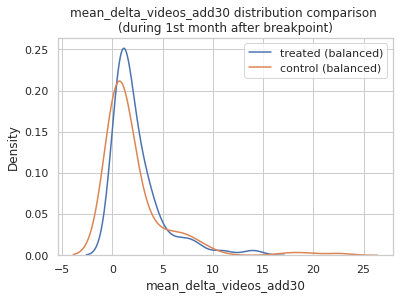

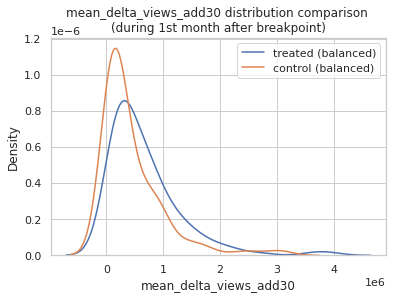

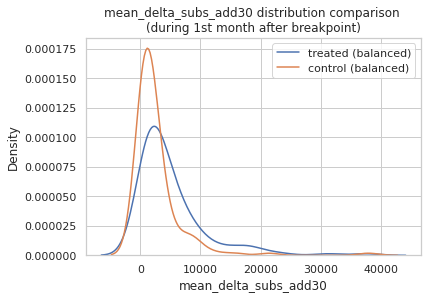

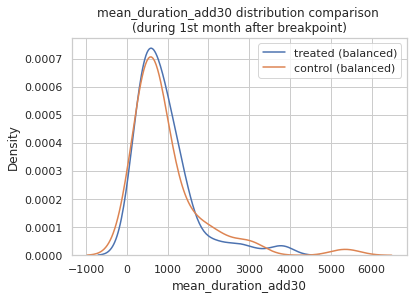

In [68]:
for column in outcome_delta_variables:
    ax = sns.kdeplot(treated_balanced[column], label='treated (balanced)')
    ax = sns.kdeplot(control_balanced[column], label='control (balanced)')
    ax.set(title=f'{column} distribution comparison \n(during 1st month after breakpoint)', xlabel=column, ylabel='Density')
    plt.legend()
    plt.show()

### 4.5 Compute difference between means of the different periods

In [69]:
# compute increases between means of all 4 regions
all_pairs_df['diff_delta_patrons_d1'] = all_pairs_df['mean_delta_patrons_add30'] - all_pairs_df['mean_delta_patrons_sub30']
all_pairs_df['diff_delta_patrons_d2'] = all_pairs_df['mean_delta_patrons_add60'] - all_pairs_df['mean_delta_patrons_sub30']
all_pairs_df['diff_delta_patrons_d3'] = all_pairs_df['mean_delta_patrons_add90'] - all_pairs_df['mean_delta_patrons_sub30']

all_pairs_df['diff_delta_earnings_d1'] = all_pairs_df['mean_delta_earnings_add30'] - all_pairs_df['mean_delta_earnings_sub30']
all_pairs_df['diff_delta_earnings_d2'] = all_pairs_df['mean_delta_earnings_add60'] - all_pairs_df['mean_delta_earnings_sub30']
all_pairs_df['diff_delta_earnings_d3'] = all_pairs_df['mean_delta_earnings_add90'] - all_pairs_df['mean_delta_earnings_sub30']

all_pairs_df['diff_delta_videos_d1'] = all_pairs_df['mean_delta_videos_add30'] - all_pairs_df['mean_delta_videos_sub30']
all_pairs_df['diff_delta_videos_d2'] = all_pairs_df['mean_delta_videos_add60'] - all_pairs_df['mean_delta_videos_sub30']
all_pairs_df['diff_delta_videos_d3'] = all_pairs_df['mean_delta_videos_add90'] - all_pairs_df['mean_delta_videos_sub30']

all_pairs_df['diff_delta_views_d1'] = all_pairs_df['mean_delta_views_add30'] - all_pairs_df['mean_delta_views_sub30']
all_pairs_df['diff_delta_views_d2'] = all_pairs_df['mean_delta_views_add60'] - all_pairs_df['mean_delta_views_sub30']
all_pairs_df['diff_delta_views_d3'] = all_pairs_df['mean_delta_views_add90'] - all_pairs_df['mean_delta_views_sub30']

all_pairs_df['diff_delta_subs_d1'] = all_pairs_df['mean_delta_subs_add30'] - all_pairs_df['mean_delta_subs_sub30']
all_pairs_df['diff_delta_subs_d2'] = all_pairs_df['mean_delta_subs_add60'] - all_pairs_df['mean_delta_subs_sub30']
all_pairs_df['diff_delta_subs_d3'] = all_pairs_df['mean_delta_subs_add90'] - all_pairs_df['mean_delta_subs_sub30']

all_pairs_df['diff_duration_d1'] = all_pairs_df['mean_duration_add30'] - all_pairs_df['mean_duration_sub30']
all_pairs_df['diff_duration_d2'] = all_pairs_df['mean_duration_add60'] - all_pairs_df['mean_duration_sub30']
all_pairs_df['diff_duration_d3'] = all_pairs_df['mean_duration_add90'] - all_pairs_df['mean_duration_sub30']

all_pairs_df['diff_likes_d1'] = all_pairs_df['mean_likes_add30'] - all_pairs_df['mean_likes_sub30']
all_pairs_df['diff_likes_d2'] = all_pairs_df['mean_likes_add60'] - all_pairs_df['mean_likes_sub30']
all_pairs_df['diff_likes_d3'] = all_pairs_df['mean_likes_add90'] - all_pairs_df['mean_likes_sub30']
all_pairs_df.head()

treated_patreon_id                patreon_id  \
0      patreon.com/blindwave  patreon.com/chibireviews   
1      patreon.com/blindwave     patreon.com/blindwave   
2     patreon.com/thenormies  patreon.com/popdetective   
3     patreon.com/thenormies    patreon.com/thenormies   
4  patreon.com/bohobeautiful    patreon.com/bazbattles   

              yt_channel_id  treat    d1          d2          d3          d4  \
0  UCfGmaA-nXPryTfimsnkLieQ      0   2.9    0.600000   -1.333333   -2.033333   
1  UCs1APU4_lj3PgZz2B4HeadA      1  28.6  359.633333  437.866667  801.700000   
2  UCHiwtz2tCEfS17N9A-WoSSw      0   1.0    0.433333   28.200000   77.300000   
3  UCbv2OBLeYiYe7B6WgPDnLow      1  24.6   76.000000  185.933333  522.866667   
4  UCx-dJoP9hFCBloY9qodykvw      0  19.5   28.800000   16.066667   25.966667   

   ratio_d1_d2  bkpt_date  ... diff_delta_views_d3 diff_delta_subs_d1  \
0     0.206897 2017-05-05  ...       -50520.031250         -94.468750   
1    12.574592 2017-05-05  ...       732337.531250         337.343750   
2     0.433333 2017-02-25  ...       145871.089844         -59.741151   
3     3.089431 2017-02-25  ...       323809.236979         416.838911   
4     1.476923 2017-08-25  ...      -110676.980469         696.000000   

  diff_delta_subs_d2 diff_delta_subs_d3  diff_duration_d1  diff_duration_d2  \
0        -110.525000         -57.500000          6.819986        282.171717   
1         550.718750        1579.843750         19.702081       -538.804945   
2         -53.534086        4441.328414               NaN        371.000000   
3        1017.457552         478.438802         92.491667        -15.860606   
4       -5705.800000       -5426.532552        -76.000000         16.000000   

   diff_duration_d3  diff_likes_d1  diff_likes_d2  diff_likes_d3  
0        136.061245     -46.262266     -15.691919    -216.970976  
1       -132.258361     113.546343     186.205259     554.165552  
2        445.000000            NaN  -54258.000000   20974.000000  
3        -79.583784     122.216667     149.906061     281.651351  
4       -183.000000  -34047.000000  -45928.000000  -44389.000000  

[5 rows x 69 columns]

## 5. Analyze balanced dataset

In [70]:
# reorder columns
pd.set_option('display.max_columns', 70)
columns_order = [
            'treated_patreon_id', 'patreon_id', 'yt_channel_id', 'treat','Propensity_score',
            'd1', 'd2', 'd3', 'd4',
            'ratio_d1_d2',
            'bkpt_date_sub30', 'bkpt_date', 'bkpt_date_add30', 'bkpt_date_add60', 'bkpt_date_add90',
            'avg_patrons_sub30', 'avg_patrons_bkpnt', 'avg_patrons_add30', 'avg_patrons_add60', 'avg_patrons_add90',
            'mean_delta_patrons_sub30', 'mean_delta_patrons_add30', 'mean_delta_patrons_add60', 'mean_delta_patrons_add90',
            'mean_delta_earnings_sub30', 'mean_delta_earnings_add30', 'mean_delta_earnings_add60','mean_delta_earnings_add90',
            'mean_delta_videos_sub30', 'mean_delta_videos_add30', 'mean_delta_videos_add60', 'mean_delta_videos_add90',
            'mean_delta_views_sub30','mean_delta_views_add30', 'mean_delta_views_add60', 'mean_delta_views_add90',
            'mean_delta_subs_sub30', 'mean_delta_subs_add30', 'mean_delta_subs_add60', 'mean_delta_subs_add90',
            'mean_duration_sub30', 'mean_duration_add30', 'mean_duration_add60', 'mean_duration_add90',
            'mean_likes_sub30', 'mean_likes_add30', 'mean_likes_add60', 'mean_likes_add90',
            'diff_delta_patrons_d1', 'diff_delta_patrons_d2', 'diff_delta_patrons_d3',
            'diff_delta_earnings_d1', 'diff_delta_earnings_d2','diff_delta_earnings_d3',
            'diff_delta_videos_d1','diff_delta_videos_d2', 'diff_delta_videos_d3',
            'diff_delta_views_d1','diff_delta_views_d2', 'diff_delta_views_d3',
            'diff_delta_subs_d1','diff_delta_subs_d2', 'diff_delta_subs_d3',
            'diff_duration_d1','diff_duration_d2', 'diff_duration_d3',
            'diff_likes_d1','diff_likes_d2', 'diff_likes_d3'
]

all_pairs_df = all_pairs_df[columns_order]
all_pairs_df.head()

treated_patreon_id                patreon_id  \
0      patreon.com/blindwave  patreon.com/chibireviews   
1      patreon.com/blindwave     patreon.com/blindwave   
2     patreon.com/thenormies  patreon.com/popdetective   
3     patreon.com/thenormies    patreon.com/thenormies   
4  patreon.com/bohobeautiful    patreon.com/bazbattles   

              yt_channel_id  treat  Propensity_score    d1          d2  \
0  UCfGmaA-nXPryTfimsnkLieQ      0          0.000006   2.9    0.600000   
1  UCs1APU4_lj3PgZz2B4HeadA      1          0.999986  28.6  359.633333   
2  UCHiwtz2tCEfS17N9A-WoSSw      0          0.019843   1.0    0.433333   
3  UCbv2OBLeYiYe7B6WgPDnLow      1          0.019821  24.6   76.000000   
4  UCx-dJoP9hFCBloY9qodykvw      0          0.017678  19.5   28.800000   

           d3          d4  ratio_d1_d2 bkpt_date_sub30  bkpt_date  \
0   -1.333333   -2.033333     0.206897      2017-04-05 2017-05-05   
1  437.866667  801.700000    12.574592      2017-04-05 2017-05-05   
2   28.200000   77.300000     0.433333      2017-01-24 2017-02-25   
3  185.933333  522.866667     3.089431      2017-01-24 2017-02-25   
4   16.066667   25.966667     1.476923      2017-07-26 2017-08-25   

  bkpt_date_add30 bkpt_date_add60 bkpt_date_add90  avg_patrons_sub30  \
0      2017-06-04      2017-07-04      2017-08-03          14.700000   
1      2017-06-04      2017-07-04      2017-08-03        2680.466667   
2      2017-03-27      2017-04-26      2017-05-26          63.266667   
3      2017-03-27      2017-04-26      2017-05-26          74.066667   
4      2017-09-24      2017-10-24      2017-11-23         101.133333   

   avg_patrons_bkpnt  avg_patrons_add30  avg_patrons_add60  avg_patrons_add90  \
0          17.600000          18.200000          16.866667          14.833333   
1        2709.066667        3068.700000        3506.566667        4308.266667   
2          64.266667          64.700000          92.900000         170.200000   
3          98.666667         174.666667         360.600000         883.466667   
4         120.633333         149.433333         165.500000         191.466667   

   mean_delta_patrons_sub30  mean_delta_patrons_add30  \
0                  0.857143                  0.178571   
1                  4.607143                 96.250000   
2                  0.000000                 -0.371429   
3                  5.428571                 20.114286   
4                  5.071429                  6.285714   

   mean_delta_patrons_add60  mean_delta_patrons_add90  \
0                 -0.457143                 -0.464286   
1                100.942857                171.214286   
2                  2.857143                 19.642857   
3                 31.942857                150.285714   
4                  4.571429                  5.821429   

   mean_delta_earnings_sub30  mean_delta_earnings_add30  \
0                  38.606429                  -9.054286   
1                  -2.671429                 373.442857   
2                   0.070000                   1.587143   
3                  16.295357                 163.372286   
4                  10.012857                  13.390714   

   mean_delta_earnings_add60  mean_delta_earnings_add90  \
0                 -24.349429                  -1.321786   
1                 504.437143                1936.496429   
2                   9.423429                  42.998571   
3                 259.267143                1131.235714   
4                  16.949429                  15.100357   

   mean_delta_videos_sub30  mean_delta_videos_add30  mean_delta_videos_add60  \
0                    22.50                    19.25                     15.4   
1                    12.00                    14.25                     21.2   
2                     0.25                     0.00                      0.2   
3                     6.00                     6.00                      7.6   
4                     0.50                     0.25                      0.4   

   m

### Filter pairs according to increase of the treated

Now that we have a balanced dataset, and that we know which pairs are matched together, we can change the threshold of increase of the treated pair to restrict the dataset

In [71]:
TREATED_INCR_RATIO_THRESH = 3
print(f"Treated increase threshold: ratio > {TREATED_INCR_RATIO_THRESH}")

# filter pairs according to increase of the treated
filtered_list = all_pairs_df[(all_pairs_df['treat'] == 1) & (all_pairs_df['ratio_d1_d2'] > TREATED_INCR_RATIO_THRESH)].treated_patreon_id
print(f"Number of treated accounts:              {len(filtered_list):>3}")

all_pairs_df_filt = all_pairs_df[all_pairs_df['treated_patreon_id'].isin(filtered_list)]
print(f"Number of corresponding matched pairs:   {len(all_pairs_df_filt):>3}")

all_pairs_df_filt.head(3)

Treated increase threshold: ratio > 3
Number of treated accounts:              140
Number of corresponding matched pairs:   280


treated_patreon_id                patreon_id             yt_channel_id  \
0   patreon.com/blindwave  patreon.com/chibireviews  UCfGmaA-nXPryTfimsnkLieQ   
1   patreon.com/blindwave     patreon.com/blindwave  UCs1APU4_lj3PgZz2B4HeadA   
2  patreon.com/thenormies  patreon.com/popdetective  UCHiwtz2tCEfS17N9A-WoSSw   

   treat  Propensity_score    d1          d2          d3          d4  \
0      0          0.000006   2.9    0.600000   -1.333333   -2.033333   
1      1          0.999986  28.6  359.633333  437.866667  801.700000   
2      0          0.019843   1.0    0.433333   28.200000   77.300000   

   ratio_d1_d2 bkpt_date_sub30  bkpt_date bkpt_date_add30 bkpt_date_add60  \
0     0.206897      2017-04-05 2017-05-05      2017-06-04      2017-07-04   
1    12.574592      2017-04-05 2017-05-05      2017-06-04      2017-07-04   
2     0.433333      2017-01-24 2017-02-25      2017-03-27      2017-04-26   

  bkpt_date_add90  avg_patrons_sub30  avg_patrons_bkpnt  avg_patrons_add30  \
0      2017-08-03          14.700000          17.600000               18.2   
1      2017-08-03        2680.466667        2709.066667             3068.7   
2      2017-05-26          63.266667          64.266667               64.7   

   avg_patrons_add60  avg_patrons_add90  mean_delta_patrons_sub30  \
0          16.866667          14.833333                  0.857143   
1        3506.566667        4308.266667                  4.607143   
2          92.900000         170.200000                  0.000000   

   mean_delta_patrons_add30  mean_delta_patrons_add60  \
0                  0.178571                 -0.457143   
1                 96.250000                100.942857   
2                 -0.371429                  2.857143   

   mean_delta_patrons_add90  mean_delta_earnings_sub30  \
0                 -0.464286                  38.606429   
1                171.214286                  -2.671429   
2                 19.642857                   0.070000   

   mean_delta_earnings_add30  mean_delta_earnings_add60  \
0                  -9.054286                 -24.349429   
1                 373.442857                 504.437143   
2                   1.587143                   9.423429   

   mean_delta_earnings_add90  mean_delta_videos_sub30  \
0                  -1.321786                    22.50   
1                1936.496429                    12.00   
2                  42.998571                     0.25   

   mean_delta_videos_add30  mean_delta_videos_add60  mean_delta_videos_add90  \
0                    19.25                     15.4                    18.75   
1                    14.25                     21.2                    21.75   
2                     0.00                      0.2                     0.25   

   mean_delta_views_sub30  mean_delta_views_add30  mean_delta_views_add60  \
0            5.173208e+05            4.483222e+05            4.401710e+05   
1            1.212643e+06            1.340693e+06            1.554458e+06   
2            6.149910e+03            6.120740e+03            5.854006e+03   

   mean_delta_views_add90  mean_delta_subs_sub30  mean_delta_subs_add30  \
0              466800.750             791.875000             697.406250   
1             1944980.625            1741.656250            2079.000000   
2              152021.000              89.171586              29.430434   

   mean_delta_subs_add60  mean_delta_subs_add90  mean_duration_sub30  \
0               681.3500                734.375           730.191919   
1              2292.3750               3321.500          1888.019231   
2                35.6375               4530.500           648.000000   

   mean_duration_add30  mean_duration_add60  mean_duration_add90  \
0           737.011905          1012.363636           866.253165   
1          1907.721311          1349.214286          1755.760870   
2                  NaN          1019.000000          1093.000000   

   mean_likes_sub30  mean_likes_add30  mean_likes_add60  mean_likes_add90

### Scatterplots
diffs of delta means 1, 2 and 3 months after breakpoint

In [72]:
# split the dataset
treated_balanced_filt = all_pairs_df_filt.loc[all_pairs_df_filt['treat'] == 1] 
control_balanced_filt = all_pairs_df_filt.loc[all_pairs_df_filt['treat'] == 0] 

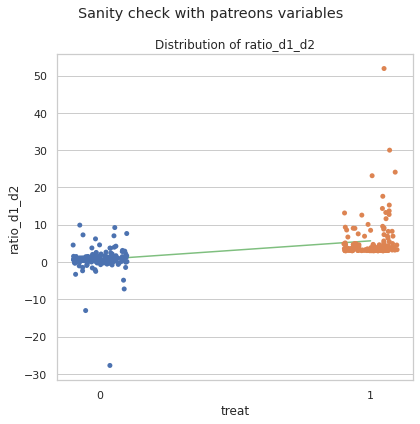

In [73]:
# sanity check
x_values = [0,1]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharex=False, sharey='row')
   
sns.stripplot(x="treat", y='ratio_d1_d2', data=all_pairs_df_filt, ax=axs)
axs.set(title=f'Distribution of ratio_d1_d2')
axs.set_ylabel('ratio_d1_d2')
axs.plot(x_values, [control_balanced_filt['ratio_d1_d2'].mean(), treated_balanced_filt['ratio_d1_d2'].mean()], linestyle="-", color='green', alpha=0.5)

# plot a horizontal line at the increase ratio threshold of the treated group
# axs.hlines(y=TREATED_INCR_RATIO_THRESH, xmin=-0.1, xmax=1.1, linewidth=2, linestyle='--', color='green')

plt.suptitle("Sanity check with patreons variables")
plt.tight_layout()
plt.show()

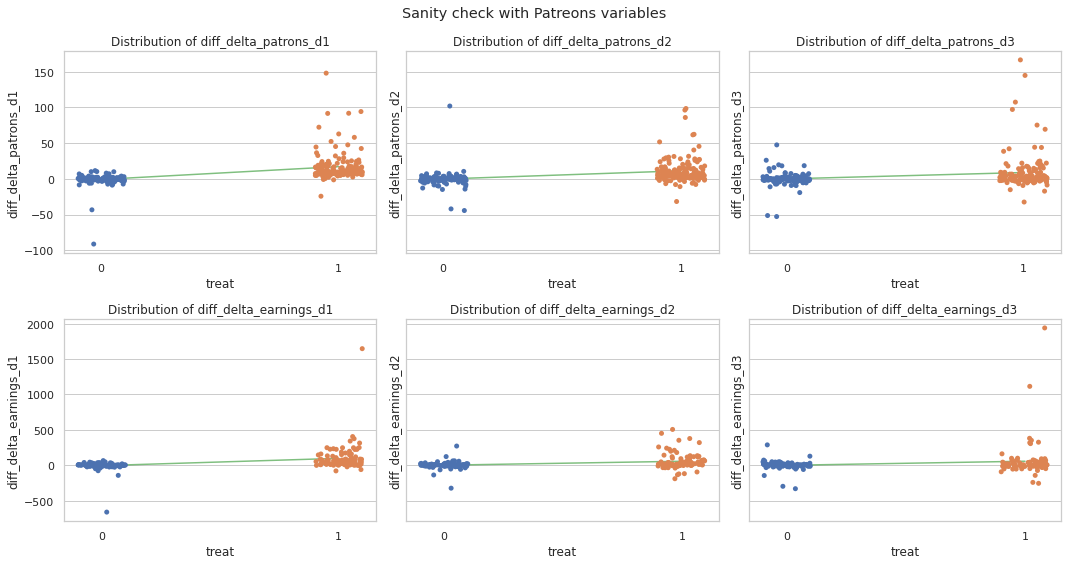

In [74]:
x_values = [0,1]

# sanity check
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,8), sharex=False, sharey='row')

# diff delta patrons distribution
sns.stripplot(x="treat", y='diff_delta_patrons_d1', data=all_pairs_df_filt, ax=axs[0,0])
axs[0,0].plot(x_values, [control_balanced_filt['diff_delta_patrons_d1'].mean(), treated_balanced_filt['diff_delta_patrons_d1'].mean()], linestyle="-", color='green', alpha=0.5)
axs[0,0].set(title=f'Distribution of diff_delta_patrons_d1')
axs[0,0].set_ylabel('diff_delta_patrons_d1')

sns.stripplot(x="treat", y='diff_delta_patrons_d2', data=all_pairs_df_filt, ax=axs[0,1])
axs[0,1].plot(x_values, [control_balanced_filt['diff_delta_patrons_d2'].mean(), treated_balanced_filt['diff_delta_patrons_d2'].mean()], linestyle="-", color='green', alpha=0.5)
axs[0,1].set(title=f'Distribution of diff_delta_patrons_d2')
axs[0,1].set_ylabel('diff_delta_patrons_d2')

sns.stripplot(x="treat", y='diff_delta_patrons_d3', data=all_pairs_df_filt, ax=axs[0,2])
axs[0,2].plot(x_values, [control_balanced_filt['diff_delta_patrons_d3'].mean(), treated_balanced_filt['diff_delta_patrons_d3'].mean()], linestyle="-", color='green', alpha=0.5)
axs[0,2].set(title=f'Distribution of diff_delta_patrons_d3')
axs[0,2].set_ylabel('diff_delta_patrons_d3')


# diff delta earnings distribution
sns.stripplot(x="treat", y='diff_delta_earnings_d1', data=all_pairs_df_filt, ax=axs[1,0])
axs[1,0].plot(x_values, [control_balanced_filt['diff_delta_earnings_d1'].mean(), treated_balanced_filt['diff_delta_earnings_d1'].mean()], linestyle="-", color='green', alpha=0.5)
axs[1,0].set(title=f'Distribution of diff_delta_earnings_d1')
axs[1,0].set_ylabel('diff_delta_earnings_d1')

sns.stripplot(x="treat", y='diff_delta_earnings_d2', data=all_pairs_df_filt, ax=axs[1,1])
axs[1,1].plot(x_values, [control_balanced_filt['diff_delta_earnings_d2'].mean(), treated_balanced_filt['diff_delta_earnings_d2'].mean()], linestyle="-", color='green', alpha=0.5)
axs[1,1].set(title=f'Distribution of diff_delta_earnings_d2')
axs[1,1].set_ylabel('diff_delta_earnings_d2')

sns.stripplot(x="treat", y='diff_delta_earnings_d3', data=all_pairs_df_filt, ax=axs[1,2])
axs[1,2].plot(x_values, [control_balanced_filt['diff_delta_earnings_d3'].mean(), treated_balanced_filt['diff_delta_earnings_d3'].mean()], linestyle="-", color='green', alpha=0.5)
axs[1,2].set(title=f'Distribution of diff_delta_earnings_d3')
axs[1,2].set_ylabel('diff_delta_earnings_d3')


plt.suptitle("Sanity check with Patreons variables")
plt.tight_layout()
plt.show()

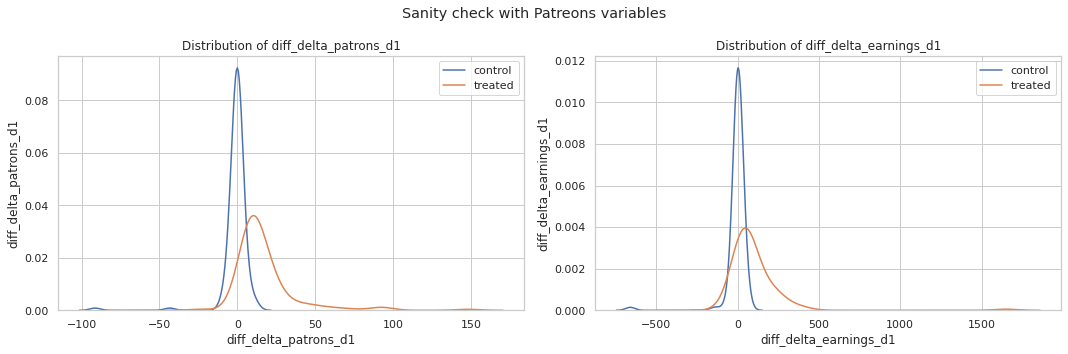

In [75]:
selected_cols = ['diff_delta_patrons_d1', 'diff_delta_earnings_d1']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.kdeplot(control_balanced_filt[col], label='control', ax=ax)
    sns.kdeplot(treated_balanced_filt[col], label='treated', ax=ax)
    ax.set(title=f'Distribution of {col}')
    ax.set_ylabel(col)
    # ax.set(yscale="log")
    ax.legend()
plt.suptitle("Sanity check with Patreons variables")
plt.tight_layout()
plt.show()

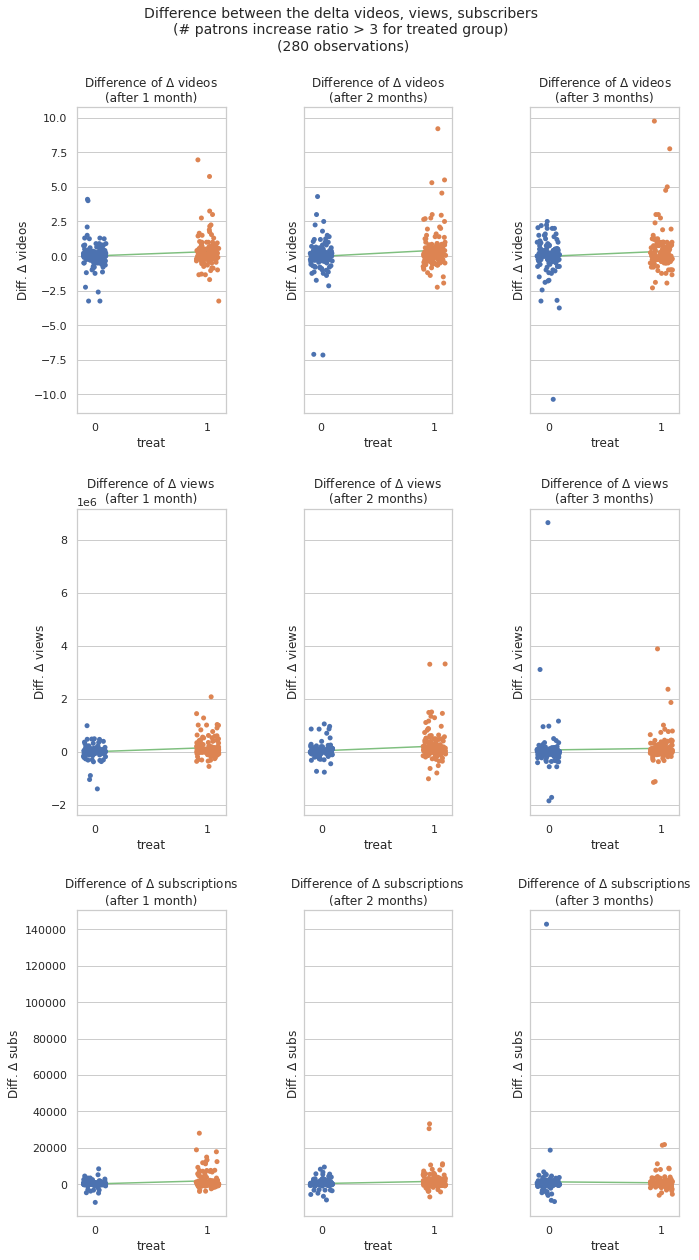

In [76]:
# change Y scale to log scale. Warning, will fail to plot negative values when set to True
Y_LOG_SCALE = False

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,18), sharex=False, sharey='row')
# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,18), sharex=False, sharey=False)


# videos
sns.stripplot(x="treat", y='diff_delta_videos_d1', data=all_pairs_df_filt, ax=axs[0,0])
axs[0,0].plot(x_values, [control_balanced_filt['diff_delta_videos_d1'].mean(), treated_balanced_filt['diff_delta_videos_d1'].mean()], linestyle="-", color='green', alpha=0.5)
axs[0,0].set(title=f'Difference of $\Delta$ videos \n(after 1 month)')
axs[0,0].set_ylabel('Diff. $\Delta$ videos')
axs[0,0].set(yscale="log") if Y_LOG_SCALE else None


sns.stripplot(x="treat", y='diff_delta_videos_d2', data=all_pairs_df_filt, ax=axs[0,1])
axs[0,1].plot(x_values, [control_balanced_filt['diff_delta_videos_d2'].mean(), treated_balanced_filt['diff_delta_videos_d2'].mean()], linestyle="-", color='green', alpha=0.5)
axs[0,1].set(title=f'Difference of $\Delta$ videos \n(after 2 months)')
axs[0,1].set_ylabel('Diff. $\Delta$ videos')
axs[0,1].set(yscale="log") if Y_LOG_SCALE else None


sns.stripplot(x="treat", y='diff_delta_videos_d3', data=all_pairs_df_filt, ax=axs[0,2])
axs[0,2].plot(x_values, [control_balanced_filt['diff_delta_videos_d3'].mean(), treated_balanced_filt['diff_delta_videos_d3'].mean()], linestyle="-", color='green', alpha=0.5)
axs[0,2].set(title=f'Difference of $\Delta$ videos \n(after 3 months)')
axs[0,2].set_ylabel('Diff. $\Delta$ videos')
axs[0,2].set(yscale="log") if Y_LOG_SCALE else None

# views
sns.stripplot(x="treat", y='diff_delta_views_d1', data=all_pairs_df_filt, ax=axs[1,0])
axs[1,0].plot(x_values, [control_balanced_filt['diff_delta_views_d1'].mean(), treated_balanced_filt['diff_delta_views_d1'].mean()], linestyle="-", color='green', alpha=0.5)
axs[1,0].set(title=f'Difference of $\Delta$ views \n(after 1 month)')
axs[1,0].set_ylabel('Diff. $\Delta$ views')
axs[1,0].set(yscale="symlog") if Y_LOG_SCALE else None


sns.stripplot(x="treat", y='diff_delta_views_d2', data=all_pairs_df_filt, ax=axs[1,1])
axs[1,1].plot(x_values, [control_balanced_filt['diff_delta_views_d2'].mean(), treated_balanced_filt['diff_delta_views_d2'].mean()], linestyle="-", color='green', alpha=0.5)
axs[1,1].set(title=f'Difference of $\Delta$ views \n(after 2 months)')
axs[1,1].set_ylabel('Diff. $\Delta$ views')
axs[1,1].set(yscale="log") if Y_LOG_SCALE else None


sns.stripplot(x="treat", y='diff_delta_views_d3', data=all_pairs_df_filt, ax=axs[1,2])
axs[1,2].plot(x_values, [control_balanced_filt['diff_delta_views_d3'].mean(), treated_balanced_filt['diff_delta_views_d3'].mean()], linestyle="-", color='green', alpha=0.5)
axs[1,2].set(title=f'Difference of $\Delta$ views \n(after 3 months)')
axs[1,2].set_ylabel('Diff. $\Delta$ views')
axs[1,2].set(yscale="log") if Y_LOG_SCALE else None



# subs
sns.stripplot(x="treat", y='diff_delta_subs_d1', data=all_pairs_df_filt, ax=axs[2,0])
axs[2,0].plot(x_values, [control_balanced_filt['diff_delta_subs_d1'].mean(), treated_balanced_filt['diff_delta_subs_d1'].mean()], linestyle="-", color='green', alpha=0.5)
axs[2,0].set(title=f'Difference of $\Delta$ subscriptions \n(after 1 month)')
axs[2,0].set_ylabel('Diff. $\Delta$ subs')
axs[2,0].set(yscale="log") if Y_LOG_SCALE else None


sns.stripplot(x="treat", y='diff_delta_subs_d2', data=all_pairs_df_filt, ax=axs[2,1])
axs[2,1].plot(x_values, [control_balanced_filt['diff_delta_subs_d2'].mean(), treated_balanced_filt['diff_delta_subs_d2'].mean()], linestyle="-", color='green', alpha=0.5)
axs[2,1].set(title=f'Difference of $\Delta$ subscriptions \n(after 2 months)')
axs[2,1].set_ylabel('Diff. $\Delta$ subs')
axs[2,1].set(yscale="log") if Y_LOG_SCALE else None


sns.stripplot(x="treat", y='diff_delta_subs_d3', data=all_pairs_df_filt, ax=axs[2,2])
axs[2,2].plot(x_values, [control_balanced_filt['diff_delta_subs_d3'].mean(), treated_balanced_filt['diff_delta_subs_d3'].mean()], linestyle="-", color='green', alpha=0.5)
axs[2,2].set(title=f'Difference of $\Delta$ subscriptions \n(after 3 months)')
axs[2,2].set_ylabel('Diff. $\Delta$ subs')
axs[2,2].set(yscale="log") if Y_LOG_SCALE else None


plt.suptitle(f"Difference between the delta videos, views, subscribers \n(# patrons increase ratio > {TREATED_INCR_RATIO_THRESH} for treated group) \n({len(all_pairs_df_filt)} observations)",fontsize=14)
fig.tight_layout(pad=2, w_pad=5)
plt.show()


### Linear regression

In [77]:
SIGNIFICANCE_LEVEL = 0.05

# Declare the model
predictors = [
            # 'diff_delta_patrons_d1', 'diff_delta_patrons_d2', 'diff_delta_patrons_d3',
            # 'diff_delta_earnings_d1', 'diff_delta_earnings_d2','diff_delta_earnings_d3',
            'diff_delta_videos_d1','diff_delta_videos_d2', 'diff_delta_videos_d3',
            'diff_delta_views_d1','diff_delta_views_d2', 'diff_delta_views_d3',
            'diff_delta_subs_d1','diff_delta_subs_d2', 'diff_delta_subs_d3',
            # 'diff_duration_d1','diff_duration_d2', 'diff_duration_d3'
]

print(f"Tests at significance level α={SIGNIFICANCE_LEVEL}:")
for idx, predictor in enumerate(predictors):
    formula_string = 'treat ~ '+predictor
    mod = smf.ols(formula=formula_string, data=all_pairs_df_filt)
    np.random.seed(2)
    res = mod.fit()
    if idx % 3 == 0:
        print("\n")
    significance = "-> Statistically significant" if (res.pvalues[1] < 0.05) else ""
    print(f'{formula_string}\t: R2={res.rsquared:.2f}, p-value={res.pvalues[1]:.2f} {significance}')
    
    # print(res.summary())

Tests at significance level α=0.05:


treat ~ diff_delta_videos_d1	: R2=0.02, p-value=0.01 -> Statistically significant
treat ~ diff_delta_videos_d2	: R2=0.03, p-value=0.00 -> Statistically significant
treat ~ diff_delta_videos_d3	: R2=0.02, p-value=0.03 -> Statistically significant


treat ~ diff_delta_views_d1	: R2=0.06, p-value=0.00 -> Statistically significant
treat ~ diff_delta_views_d2	: R2=0.04, p-value=0.00 -> Statistically significant
treat ~ diff_delta_views_d3	: R2=0.00, p-value=0.45 


treat ~ diff_delta_subs_d1	: R2=0.06, p-value=0.00 -> Statistically significant
treat ~ diff_delta_subs_d2	: R2=0.03, p-value=0.01 -> Statistically significant
treat ~ diff_delta_subs_d3	: R2=0.00, p-value=0.62 


### Distribution plots

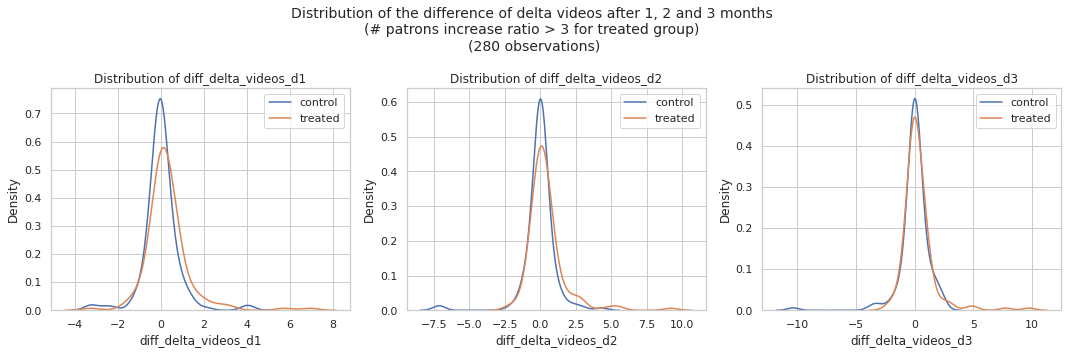

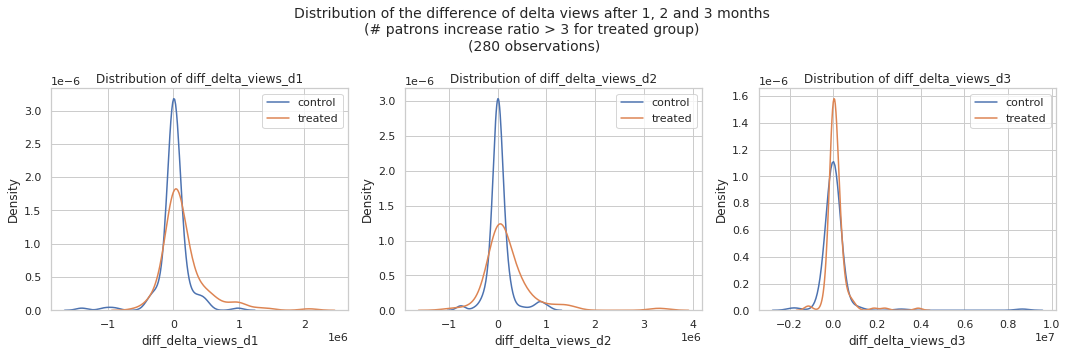

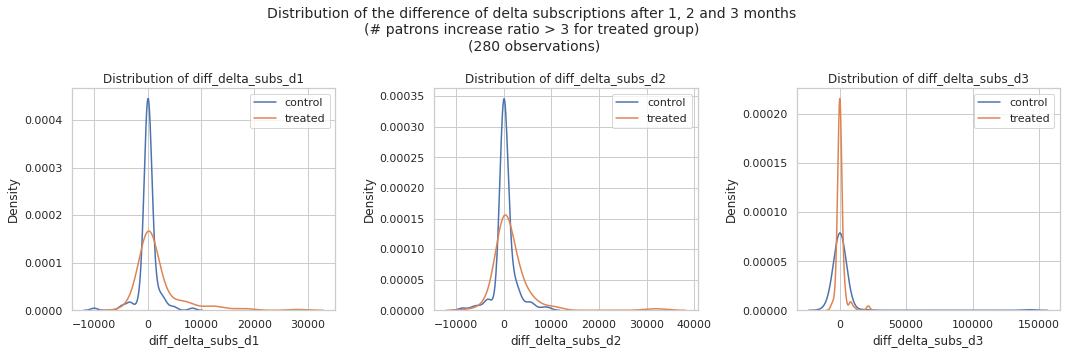

In [78]:
# SHAREX = 'row'
# SHAREY = 'row'
SHAREX = False
SHAREY = False

# diff delta videos
selected_cols = ['diff_delta_videos_d1', 'diff_delta_videos_d2', 'diff_delta_videos_d3']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=SHAREX, sharey=SHAREY)
for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.kdeplot(control_balanced_filt[col], label='control', ax=ax)
    sns.kdeplot(treated_balanced_filt[col], label='treated', ax=ax)
    ax.set(title=f'Distribution of {col}')
    ax.set_ylabel("Density")
    # ax.set(yscale="log")
    ax.legend()
plt.suptitle(f"Distribution of the difference of delta videos after 1, 2 and 3 months \n(# patrons increase ratio > {TREATED_INCR_RATIO_THRESH} for treated group) \n({len(all_pairs_df_filt)} observations)",fontsize=14)
plt.tight_layout()
plt.show()


# diff delta views
selected_cols = ['diff_delta_views_d1', 'diff_delta_views_d2', 'diff_delta_views_d3']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=SHAREX, sharey=SHAREY)
for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.kdeplot(control_balanced_filt[col], label='control', ax=ax)
    sns.kdeplot(treated_balanced_filt[col], label='treated', ax=ax)
    ax.set(title=f'Distribution of {col}')
    ax.set_ylabel("Density")
    # ax.set(yscale="log")
    ax.legend()
plt.suptitle(f"Distribution of the difference of delta views after 1, 2 and 3 months \n(# patrons increase ratio > {TREATED_INCR_RATIO_THRESH} for treated group) \n({len(all_pairs_df_filt)} observations)",fontsize=14)
plt.tight_layout()
plt.show()


# diff delta subscriptions
selected_cols = ['diff_delta_subs_d1', 'diff_delta_subs_d2', 'diff_delta_subs_d3']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=SHAREX, sharey=SHAREY)
for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.kdeplot(control_balanced_filt[col], label='control', ax=ax)
    sns.kdeplot(treated_balanced_filt[col], label='treated', ax=ax)
    ax.set(title=f'Distribution of {col}')
    ax.set_ylabel("Density")
    # ax.set(yscale="log")
    ax.legend()
plt.suptitle(f"Distribution of the difference of delta subscriptions after 1, 2 and 3 months \n(# patrons increase ratio > {TREATED_INCR_RATIO_THRESH} for treated group) \n({len(all_pairs_df_filt)} observations)",fontsize=14)
plt.tight_layout()
plt.show()

### Boxplots

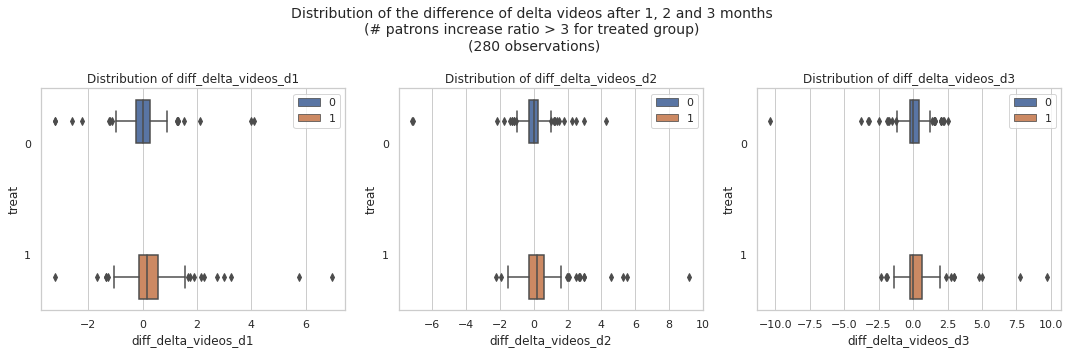

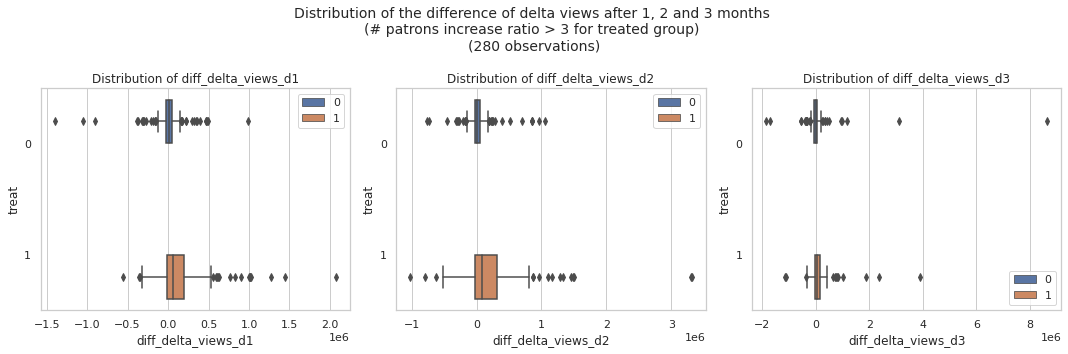

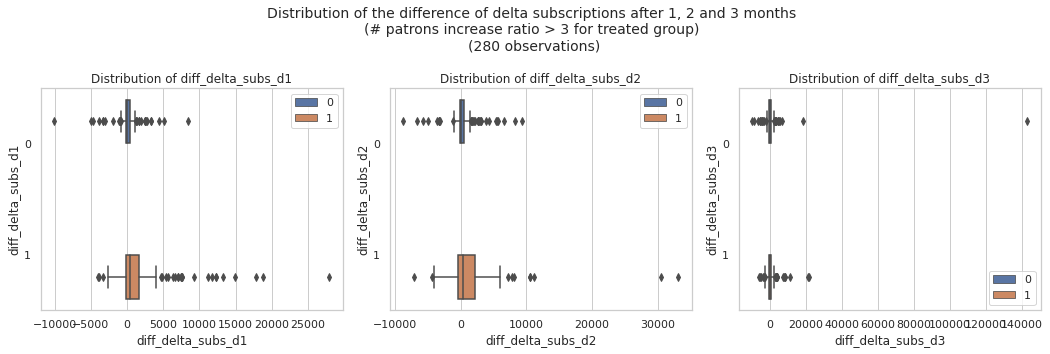

In [79]:
# SHAREX = 'row'
# SHAREY = 'row'
SHAREX = False
SHAREY = False

sns.set_theme(style="whitegrid")

# diff delta videos
selected_cols = ['diff_delta_videos_d1', 'diff_delta_videos_d2', 'diff_delta_videos_d3']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=SHAREX, sharey=SHAREY)
for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.boxplot(y='treat', x=col, hue='treat', data=all_pairs_df_filt, ax=ax, orient="h")
    ax.set(title=f'Distribution of {col}')
    ax.legend()
plt.suptitle(f"Distribution of the difference of delta videos after 1, 2 and 3 months \n(# patrons increase ratio > {TREATED_INCR_RATIO_THRESH} for treated group) \n({len(all_pairs_df_filt)} observations)",fontsize=14)
plt.tight_layout()
plt.show()


# diff delta views
selected_cols = ['diff_delta_views_d1', 'diff_delta_views_d2', 'diff_delta_views_d3']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=SHAREX, sharey=SHAREY)
for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.boxplot(y='treat', x=col, hue='treat', data=all_pairs_df_filt, ax=ax, orient="h")
    ax.set(title=f'Distribution of {col}')
    ax.legend()
plt.suptitle(f"Distribution of the difference of delta views after 1, 2 and 3 months \n(# patrons increase ratio > {TREATED_INCR_RATIO_THRESH} for treated group) \n({len(all_pairs_df_filt)} observations)",fontsize=14)
plt.tight_layout()
plt.show()


# diff delta subscriptions
selected_cols = ['diff_delta_subs_d1', 'diff_delta_subs_d2', 'diff_delta_subs_d3']
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharex=SHAREX, sharey=SHAREY)
for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.boxplot(y='treat', x=col, hue='treat', data=all_pairs_df_filt, ax=ax, orient="h")
    ax.set(title=f'Distribution of {col}')
    ax.set_ylabel(col)
    ax.legend()
plt.suptitle(f"Distribution of the difference of delta subscriptions after 1, 2 and 3 months \n(# patrons increase ratio > {TREATED_INCR_RATIO_THRESH} for treated group) \n({len(all_pairs_df_filt)} observations)",fontsize=14)
plt.tight_layout()
plt.show()

### Time series plots (balanced dataset)

  0%|          | 0/4 [00:00<?, ?it/s]




 1: chibireviews (treat = 0)
https://www.patreon.com/chibireviews
https://graphtreon.com/creator/chibireviews
https://youtube.com/channel/UCfGmaA-nXPryTfimsnkLieQ

YouTube Metadata: 
• YT videos were uploaded between March 17, 2015 and October 01, 2019
• YT metadata was crawled between November 04, 2019 and November 04, 2019
Breakpoint date:  2017-05-05

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-04-05): 14.7
• At breakpoint          (2017-05-05): 17.6
• At breakpoint + 30days (2017-06-04): 18.2
• At breakpoint + 60days (2017-07-04): 16.9
• At breakpoint + 90days (2017-08-03): 14.8

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-04-05 to 2017-05-05:        d1  =   +2.9 patrons
• Increase of patrons from 2017-05-05 to 2017-06-04:        d2  =   +0.6 patrons
• Increase of patrons from 2017-06-04 to 2017-07-04:        d3  =   -1.3 patrons
• Increase of patrons 

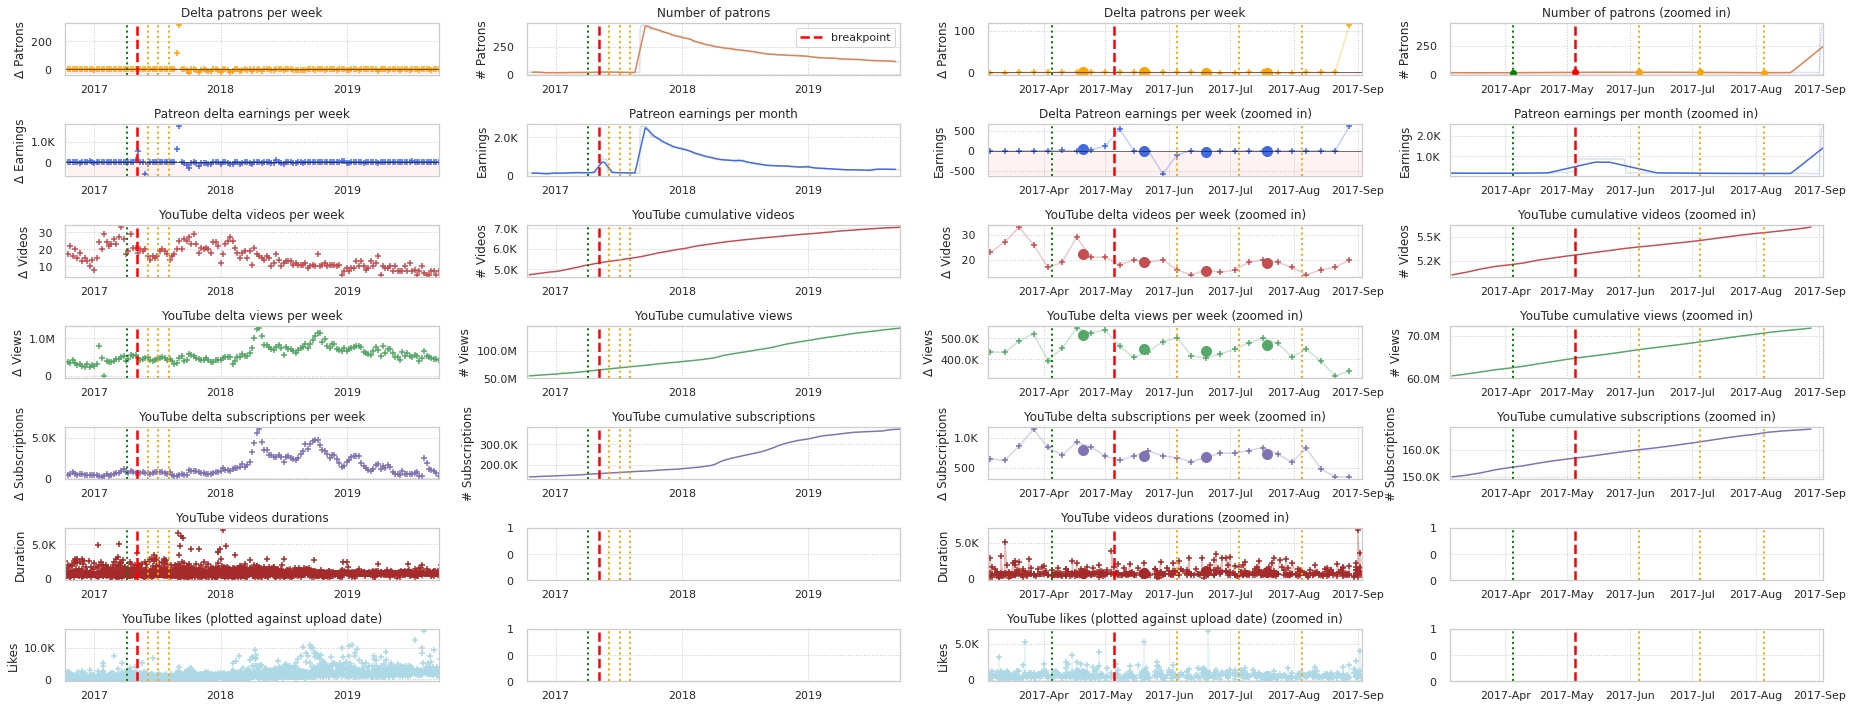




---------------------------------------------------------------------------------------------------------------------------------------------------



 2: blindwave (treat = 1)
https://www.patreon.com/blindwave
https://graphtreon.com/creator/blindwave
https://youtube.com/channel/UCs1APU4_lj3PgZz2B4HeadA

YouTube Metadata: 
• YT videos were uploaded between November 11, 2015 and October 02, 2019
• YT metadata was crawled between November 10, 2019 and November 10, 2019
Breakpoint date:  2017-05-05

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-04-05): 2,680.5
• At breakpoint          (2017-05-05): 2,709.1
• At breakpoint + 30days (2017-06-04): 3,068.7
• At breakpoint + 60days (2017-07-04): 3,506.6
• At breakpoint + 90days (2017-08-03): 4,308.3

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-04-05 to 2017-05-05:        d1  =  +28.6 patrons
• Increase of patrons fr

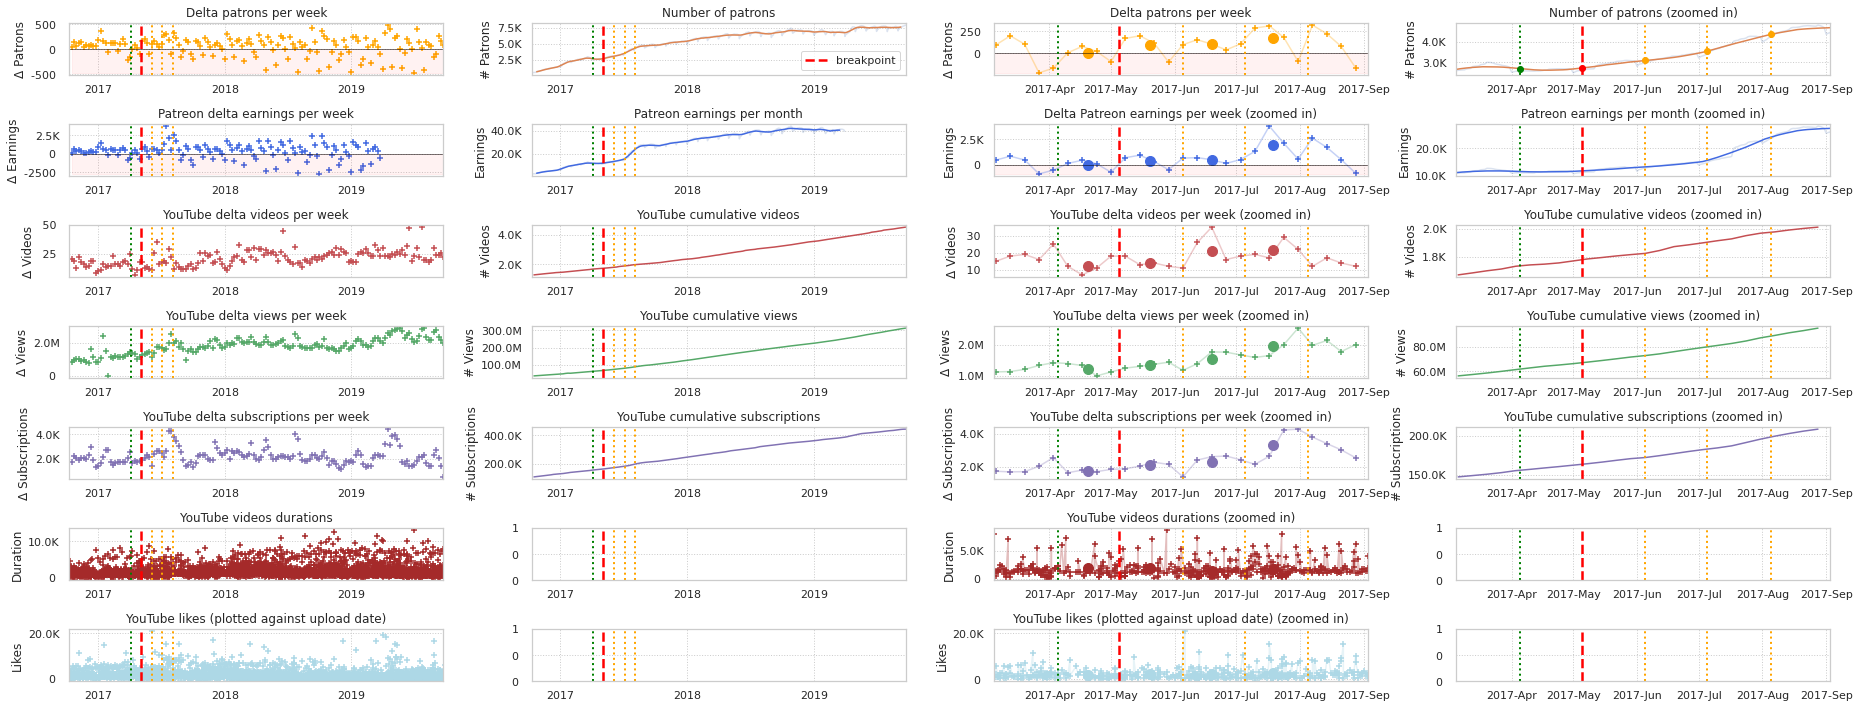




---------------------------------------------------------------------------------------------------------------------------------------------------



 3: popdetective (treat = 0)
https://www.patreon.com/popdetective
https://graphtreon.com/creator/popdetective
https://youtube.com/channel/UCHiwtz2tCEfS17N9A-WoSSw

YouTube Metadata: 
• YT videos were uploaded between July 13, 2016 and September 16, 2019
• YT metadata was crawled between November 22, 2019 and November 22, 2019
Breakpoint date:  2017-02-25

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-01-24): 63.3
• At breakpoint          (2017-02-25): 64.3
• At breakpoint + 30days (2017-03-27): 64.7
• At breakpoint + 60days (2017-04-26): 92.9
• At breakpoint + 90days (2017-05-26): 170.2

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-01-24 to 2017-02-25:        d1  =   +1.0 patrons
• Increase of patrons from 2017

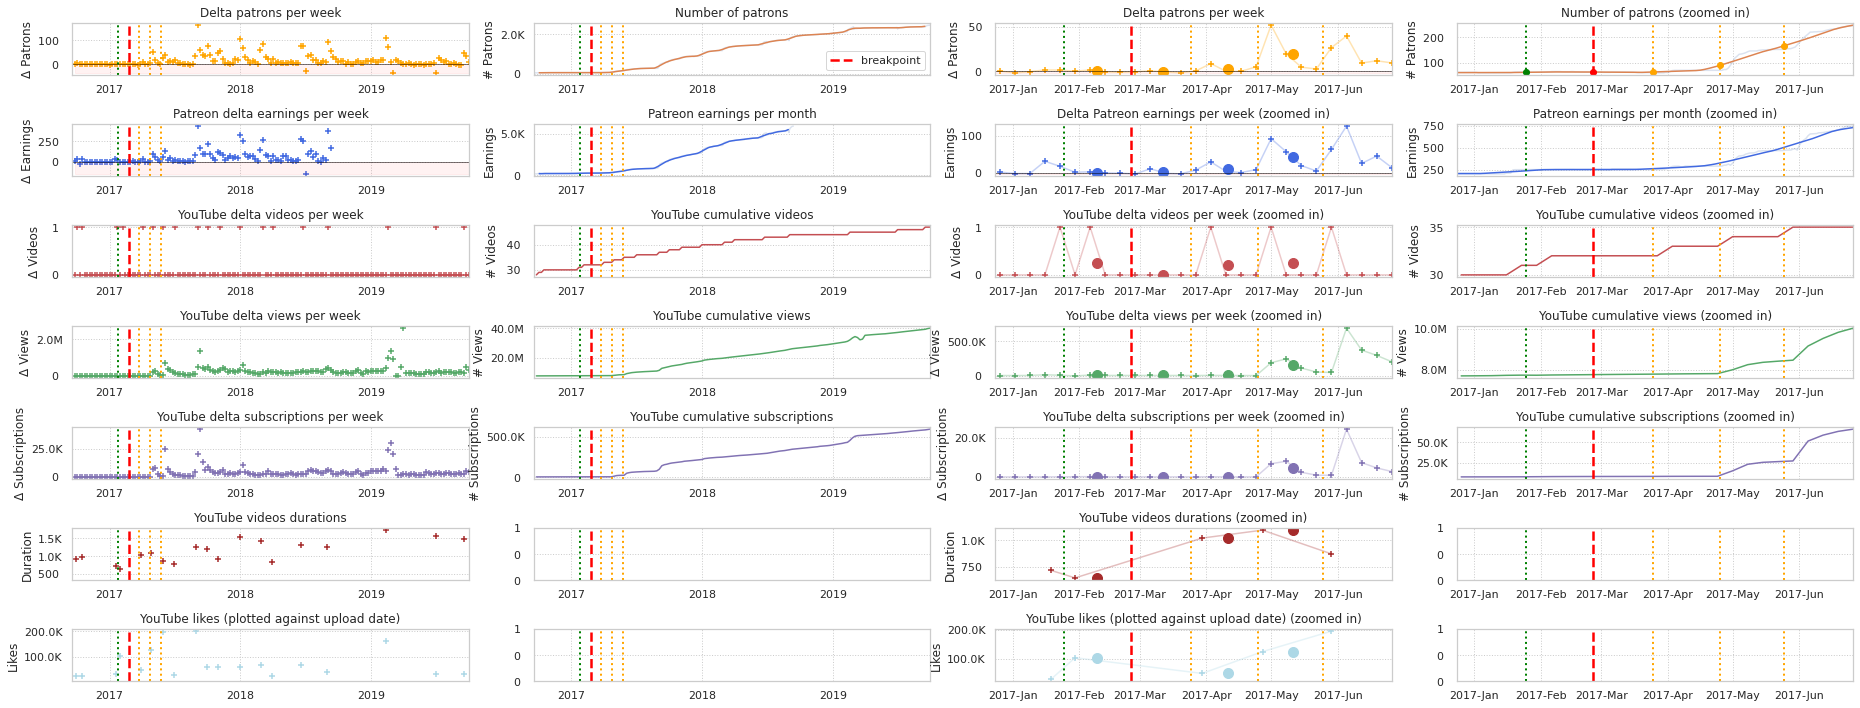




---------------------------------------------------------------------------------------------------------------------------------------------------



 4: thenormies (treat = 1)
https://www.patreon.com/thenormies
https://graphtreon.com/creator/thenormies
https://youtube.com/channel/UCbv2OBLeYiYe7B6WgPDnLow

YouTube Metadata: 
• YT videos were uploaded between October 27, 2016 and October 02, 2019
• YT metadata was crawled between November 04, 2019 and November 16, 2019
Breakpoint date:  2017-02-25

Average number of patrons: (values calculated using a 30 days centered moving average)
• At breakpoint - 30days (2017-01-24): 74.1
• At breakpoint          (2017-02-25): 98.7
• At breakpoint + 30days (2017-03-27): 174.7
• At breakpoint + 60days (2017-04-26): 360.6
• At breakpoint + 90days (2017-05-26): 883.5

Increase of patrons in the period before and after the breakpoint:
• Increase of patrons from 2017-01-24 to 2017-02-25:        d1  =  +24.6 patrons
• Increase of patrons from 2017-02

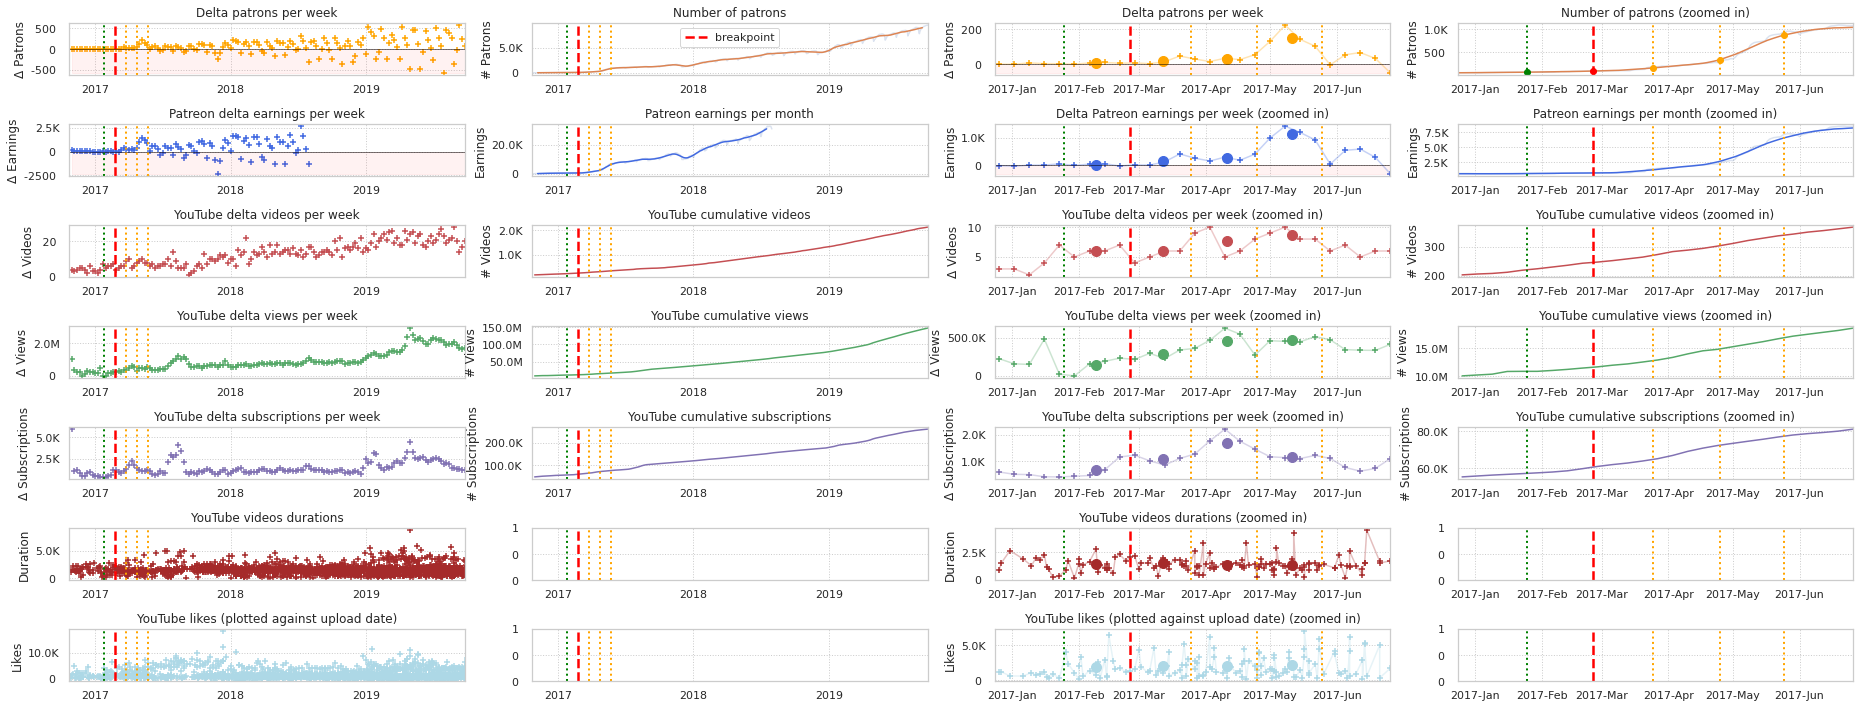




---------------------------------------------------------------------------------------------------------------------------------------------------


In [80]:
NUMBER_OF_ACCOUNTS_TO_PLOT = 4
MONTH_OFFSET = pd.DateOffset(months=1)
ROLLING_AVG_WINDOW = 30

# LOOP OVER TOP PATREON ACCOUNTS
for idx, row in tqdm(all_pairs_df[:NUMBER_OF_ACCOUNTS_TO_PLOT].iterrows(), total=all_pairs_df[:NUMBER_OF_ACCOUNTS_TO_PLOT].shape[0]):
    patreon = row['patreon_id']
    
    fig, axs = plt.subplots(7, 4, figsize=(26, 10), sharey=False, sharex=False)
        
    
    ########################## RESTRICT DATAFRAMES TO 1 PATREON ACCOUNT ##########################

    # patreon earnings and users
    tmp_df_pt = restrict_acct_and_sort_df(df_top_pt_accts, 'patreon', patreon, 'date')

    # youtube videos
    tmp_df_yt = restrict_acct_and_sort_df(df_yt_timeseries_top_pt, 'patreon_id', patreon, 'datetime')

    # youtube metadata
    tmp_df_yt_meta = restrict_acct_and_sort_df(df_yt_metadata_pt_filtered, 'patreon_id', patreon, 'upload_date')
    
    
    ########################## PRINT TITLES ##########################
    
    # print URLs for patreon, graphtreon, YT channel(s) related to this patreon account, and breakpoint date
    ch_ids = tmp_df_yt['channel'].unique()
    print(f"\n\n\n\033[1m {idx+1}: {patreon[12:]} (treat = {row['treat']})\033[0m")
    print(f"https://www.{patreon}")
    print(f"https://graphtreon.com/creator/{patreon[12:]}")
    for ch_id in ch_ids:
        print(f"https://youtube.com/channel/{ch_id}")
   
    print(f'\nYouTube Metadata: ')
    
    if not (tmp_df_yt_meta.empty):
        print('• YT videos were uploaded between {} and {}'.format(tmp_df_yt_meta['upload_date'].min().strftime('%B %d, %Y'),
                                                                 tmp_df_yt_meta['upload_date'].max().strftime('%B %d, %Y')))

        print('• YT metadata was crawled between {} and {}'.format(tmp_df_yt_meta['crawl_date'].min().strftime('%B %d, %Y'),
                                                                 tmp_df_yt_meta['crawl_date'].max().strftime('%B %d, %Y')))
    else:
        print('• No metadata available for this acount')

       
    ########################## RESTRICT PATREON AND YOUTUBE TIME SERIES TO OVERLAPPING DATES ##########################
    
   # if no overlap period between YT and Patreon datasets, raise exception and skip account
    try: 
        tmp_df_pt, tmp_df_yt, date_min, date_max = restrict_to_overlapping_dates(tmp_df_pt, tmp_df_yt, 'date', 'datetime')
    except Exception as e: 
        print(f"Exception: {patreon} and {yt_channel_id}: {e} --> skipping account")        
        no_overlap += 1
        continue
    
    
    
    ########################## PATREON: CALCULATE MOVING AVERAGE AND WEEKLY DELTAS ##########################
    
    tmp_df_pt['patrons_ma'] = tmp_df_pt['patrons'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
    tmp_df_pt['earning_ma'] = tmp_df_pt['earning'].rolling(ROLLING_AVG_WINDOW, center=True).mean()
    ts_pt_df = tmp_df_pt.set_index(tmp_df_pt['date']) # set the date as the index
    
    # resample time series to get 7 days intervals in order to calculate weekly deltas
    ts_pt_weekly_avg_df = ts_pt_df.resample('7D').mean()
    ts_pt_weekly_avg_df['delta_patrons'] = ts_pt_weekly_avg_df['patrons'].diff(periods=1)
    ts_pt_weekly_avg_df['delta_earning'] = ts_pt_weekly_avg_df['earning'].diff(periods=1)
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[1:]  # remove 1st row (which is NA)
    tmp_df_yt = tmp_df_yt[1:] # remove YT 1st row to start at the same time as PT
    
    # reorder columns to have deltas columns next to their respective columns
    patreon_column_names = ['earning', 'delta_earning', 'earning_ma', 'patrons', 'delta_patrons', 'patrons_ma']
    ts_pt_weekly_avg_df = ts_pt_weekly_avg_df[patreon_column_names]
    
    # convert Float64 columns to float64 to avoid Matplotlib NAType error
    ts_pt_weekly_avg_df_float64 = ts_pt_weekly_avg_df.astype({'patrons': 'float64', 'delta_patrons': 'float64'})
    
              
    ########################## DETECT BREAKPOINT AND REJECT PATREON ACCOUNT IF NOT VALID ##########################

    breakpoint_date = row['bkpt_date']
    print("Breakpoint date: ", breakpoint_date.date())

    # check that dates prior and after breakpoint exist
    if not (((breakpoint_date - 1*MONTH_OFFSET)) in ts_pt_df.index and ((breakpoint_date + 4*MONTH_OFFSET) in ts_pt_df.index)):
        print(f"ERROR: Breakpoint too close to edge of patreon time series or missing data\n")
        plt.figure().clear(); plt.close(); plt.cla(); plt.clf(); plt.show()
        continue
    
    
    ################################### CALCULATE INCREASE AND REJECT IF NOT VALID OR LESS THAN THRESHOLD ###################################

    avg_patrons_bkpnt = row['avg_patrons_bkpnt']
    avg_patrons_sub30 = row['avg_patrons_sub30']
    avg_patrons_add30 = row['avg_patrons_add30']
    avg_patrons_add60 = row['avg_patrons_add60']
    avg_patrons_add90 = row['avg_patrons_add90']
    
    bkpt_date       = row['bkpt_date']
    bkpt_date_sub30 = row['bkpt_date_sub30']
    bkpt_date_add30 = row['bkpt_date_add30']
    bkpt_date_add60 = row['bkpt_date_add60']
    bkpt_date_add90 = row['bkpt_date_add90']

    d1 = row['d1']
    d2 = row['d2']
    d3 = row['d3']
    d4 = row['d4']

    
    r_d1_d2 = row['ratio_d1_d2']

    print(f'\nAverage number of patrons: (values calculated using a 30 days centered moving average)')
    print(f'• At breakpoint - 30days ({bkpt_date_sub30.date()}): {avg_patrons_sub30:,.1f}')
    print(f'• At breakpoint          ({bkpt_date.date()}): {avg_patrons_bkpnt:,.1f}')
    print(f'• At breakpoint + 30days ({bkpt_date_add30.date()}): {avg_patrons_add30:,.1f}')
    print(f'• At breakpoint + 60days ({bkpt_date_add60.date()}): {avg_patrons_add60:,.1f}')
    print(f'• At breakpoint + 90days ({bkpt_date_add90.date()}): {avg_patrons_add90:,.1f}')
    
    print(f'\nIncrease of patrons in the period before and after the breakpoint:')
    print(f"• Increase of patrons from {bkpt_date_sub30.date()} to {bkpt_date.date()}:        d1  = {d1:>+6.1f} patrons")
    print(f"• Increase of patrons from {bkpt_date.date()} to {bkpt_date_add30.date()}:        d2  = {d2:>+6.1f} patrons")
    print(f"• Increase of patrons from {bkpt_date_add30.date()} to {bkpt_date_add60.date()}:        d3  = {d3:>+6.1f} patrons")
    print(f"• Increase of patrons from {bkpt_date_add60.date()} to {bkpt_date_add90.date()}:        d4  = {d4:>+6.1f} patrons")
    
    print(f'\nRatio of the increases of the 2 periods: ')
    print(f"• Ratio between 2 increases:                            d2/d1  = {r_d1_d2:.2f}")
    print(f"• Percentage increase:                              d2/d1*100  = {r_d1_d2:>+.0%}")

    
    
    

    ################################### GET DELTA MEANS BEFORE AND AFTER BKPOINT ###################################  
       
    
    mean_date_sub30 = row['bkpt_date_sub30'] + (row['bkpt_date']       - row['bkpt_date_sub30'])/2
    mean_date_add30 = row['bkpt_date']       + (row['bkpt_date_add30'] - row['bkpt_date'])/2
    mean_date_add60 = row['bkpt_date_add30'] + (row['bkpt_date_add60'] - row['bkpt_date_add30'])/2
    mean_date_add90 = row['bkpt_date_add60'] + (row['bkpt_date_add90'] - row['bkpt_date_add60'])/2
  

    mean_dates = [
        mean_date_sub30, 
        mean_date_add30, 
        mean_date_add60, 
        mean_date_add90
    ]  
    
    mean_delta_patrons = [
        row['mean_delta_patrons_sub30'],
        row['mean_delta_patrons_add30'],
        row['mean_delta_patrons_add60'],
        row['mean_delta_patrons_add90']
    ]

    mean_delta_earnings = [
        row['mean_delta_earnings_sub30'],
        row['mean_delta_earnings_add30'],
        row['mean_delta_earnings_add60'],
        row['mean_delta_earnings_add90']
    ]

    mean_delta_videos = [
        row['mean_delta_videos_sub30'],
        row['mean_delta_videos_add30'],
        row['mean_delta_videos_add60'],
        row['mean_delta_videos_add90']
    ]

    mean_delta_views = [
        row['mean_delta_views_sub30'],
        row['mean_delta_views_add30'],
        row['mean_delta_views_add60'],
        row['mean_delta_views_add90']
    ]

    mean_delta_subscriptions = [
        row['mean_delta_subs_sub30'],
        row['mean_delta_subs_add30'],
        row['mean_delta_subs_add60'],
        row['mean_delta_subs_add90']
    ]

    mean_delta_durations = [
        row['mean_duration_sub30'],
        row['mean_duration_add30'],
        row['mean_duration_add60'],
        row['mean_duration_add90']
    ]

    mean_delta_likes = [
        row['mean_likes_sub30'],
        row['mean_likes_add30'],
        row['mean_likes_add60'],
        row['mean_likes_add90']
    ]
    
        


    # patreons
    for mean_date, mean_value in zip(mean_dates, mean_delta_patrons):
        axs[0,2].plot(mean_date, mean_value, marker='o', color='orange', markersize=10)

    for mean_date, mean_value in zip(mean_dates, mean_delta_earnings):
        axs[1,2].plot(mean_date, mean_value, marker='o', color='royalblue', markersize=10)


    # youtube
    for mean_date, mean_value in zip(mean_dates, mean_delta_videos):
        axs[2,2].plot(mean_date, mean_value, marker='o', color='r', markersize=10)

    for mean_date, mean_value in zip(mean_dates, mean_delta_views):
        axs[3,2].plot(mean_date, mean_value, marker='o', color='g', markersize=10)

    for mean_date, mean_value in zip(mean_dates, mean_delta_subscriptions):
        axs[4,2].plot(mean_date, mean_value, marker='o', color='m', markersize=10)
        

    # youtube metadata
    for mean_date, mean_value in zip(mean_dates, mean_delta_durations):
        axs[5,2].plot(mean_date, mean_value, marker='o', color='brown', markersize=10)
        
    for mean_date, mean_value in zip(mean_dates, mean_delta_likes):
        axs[6,2].plot(mean_date, mean_value, marker='o', color='lightblue', markersize=10)
    
    

    
#     # plot horizontal lines for means
#     mean_befor_list = [mean_delta_patrons_befor, mean_delta_earnings_befor, mean_delta_videos_befor, mean_delta_views_befor, mean_delta_subs_befor, mean_duration_befor, mean_likes_befor]
#     mean_afer_list = [mean_delta_patrons_after, mean_delta_earnings_after, mean_delta_videos_after, mean_delta_views_after, mean_delta_subs_after, mean_duration_after, mean_likes_after]
       
#     for idx, mean in enumerate(mean_befor_list):
#             if not math.isnan(mean):
#                 axs[idx,2].hlines(y=mean, xmin=bkpt_date_sub30, xmax=bkpt_date      , linewidth=2, linestyle='--', color='green')

#     for idx, mean in enumerate(mean_afer_list):
#             if not math.isnan(mean):
#                 axs[idx,2].hlines(y=mean, xmin=bkpt_date,       xmax=bkpt_date_add30, linewidth=2, linestyle='--', color='orange')
        

    
    
    ################################### ZOOM OUT PLOTS ###################################
    
    # number of patrons (delta)
    axs[0,0].scatter(ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_patrons'], c='orange', s=30, marker='+')
    axs[0,0].set(title="Delta patrons per week")
    axs[0,0].set_ylabel("Δ Patrons")    
    color_neg_pos(axs[0,0], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_patrons'])

    # number of patrons (cumulative)
    axs[0,1].plot(tmp_df_pt['date'], tmp_df_pt['patrons'], alpha=0.2)
    axs[0,1].plot(tmp_df_pt['date'], tmp_df_pt['patrons_ma'])
    axs[0,1].set(title="Number of patrons")
    axs[0,1].set_ylabel("# Patrons")

    # patreon earnings (delta)
    axs[1,0].scatter(ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_earning'], color='royalblue', s=30, marker='+')
    axs[1,0].set(title="Patreon delta earnings per week")
    axs[1,0].set_ylabel("Δ Earnings") 
    color_neg_pos(axs[1,0], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_float64['delta_earning'])

    # patreon earnings (cumulative)
    axs[1,1].plot(tmp_df_pt['date'], tmp_df_pt['earning'], alpha=0.2)
    axs[1,1].plot(tmp_df_pt['date'], tmp_df_pt['earning_ma'], color='royalblue')
    axs[1,1].set(title="Patreon earnings per month")
    axs[1,1].set_ylabel("Earnings")
    
    # youtube videos (delta)
    axs[2,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_videos'], c='r', s=30, marker='+')
    axs[2,0].set(title="YouTube delta videos per week")
    axs[2,0].set_ylabel("Δ Videos")
    color_neg_pos(axs[2,0], tmp_df_yt['datetime'], tmp_df_yt['delta_videos'])

    # youtube videos (cumulative)
    axs[2,1].plot(tmp_df_yt['datetime'], tmp_df_yt['videos'], 'r')
    axs[2,1].set(title="YouTube cumulative videos")
    axs[2,1].set_ylabel("# Videos")

    # youtube views (delta)
    axs[3,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_views'], c='g', s=30, marker='+')
    axs[3,0].set(title="YouTube delta views per week")
    axs[3,0].set_ylabel("Δ Views")
    color_neg_pos(axs[3,0], tmp_df_yt['datetime'], tmp_df_yt['delta_views'])

    # youtube views (cumulative)
    axs[3,1].plot(tmp_df_yt['datetime'], tmp_df_yt['views'], 'g')
    axs[3,1].set(title="YouTube cumulative views")
    axs[3,1].set_ylabel("# Views")

    # youtube subs (delta)
    axs[4,0].scatter(tmp_df_yt['datetime'], tmp_df_yt['delta_subs'], c='m', s=30, marker='+')
    axs[4,0].set(title="YouTube delta subscriptions per week")
    axs[4,0].set_ylabel("Δ Subscriptions")
    color_neg_pos(axs[4,0], tmp_df_yt['datetime'], tmp_df_yt['delta_subs'])

    # youtube subs (cumulative)
    axs[4,1].plot(tmp_df_yt['datetime'], tmp_df_yt['subs'], 'm')
    axs[4,1].set(title="YouTube cumulative subscriptions")
    axs[4,1].set_ylabel("# Subscriptions")
    
    
    # youtube durations per uploads
    axs[5,0].scatter(tmp_df_yt_meta['upload_date'], tmp_df_yt_meta['duration'], c='brown', s=30, marker='+')
    axs[5,0].set(title="YouTube videos durations")
    axs[5,0].set_ylabel("Duration")
    
    
    # youtube likes at crawl date
    axs[6,0].scatter(tmp_df_yt_meta['upload_date'], tmp_df_yt_meta['like_count'], c='lightblue', s=30, marker='+')
    axs[6,0].set(title="YouTube likes (plotted against upload date)")
    axs[6,0].set_ylabel("Likes")
    

    ########################## RESTRICT DATES FOR ZOOM IN (+/- 2 months around breakpoint) ##########################

    # calculate min and max dates for zoom
    date_min_zoom = bkpt_date_sub30 - (1 * MONTH_OFFSET)
    date_max_zoom = bkpt_date_add90 + (1 * MONTH_OFFSET)
    
    
    # restrict datasets between min and max dates
    tmp_df_pt_zoomed = tmp_df_pt[(tmp_df_pt['date'] >= date_min_zoom) & (tmp_df_pt['date'] <= date_max_zoom)].copy()
    tmp_df_yt_zoomed = tmp_df_yt[(tmp_df_yt['datetime'] >= date_min_zoom) & (tmp_df_yt['datetime'] <= date_max_zoom)].copy()
    tmp_df_yt_meta_zoomed = tmp_df_yt_meta[(tmp_df_yt_meta['upload_date'] >= date_min_zoom) & (tmp_df_yt_meta['upload_date'] <= date_max_zoom)].copy()

    # used for coloration
    ts_pt_weekly_avg_df_zoomed = ts_pt_weekly_avg_df_float64[(ts_pt_weekly_avg_df_float64.index >= date_min_zoom) & (ts_pt_weekly_avg_df_float64.index <= date_max_zoom)]
    
    
   ################################### ZOOM IN PLOTS  ###################################

    # zoomed in patron numbers (delta)
    axs[0,2].scatter(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'], c='orange', s=30, marker='+')
    axs[0,2].plot(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'], c='orange', alpha=0.3)
    axs[0,2].set(title="Delta patrons per week")
    axs[0,2].set_ylabel("Δ Patrons")
    color_neg_pos(axs[0,2], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_zoomed['delta_patrons'])
    
    # zoomed in patron numbers (cumulative)
    axs[0,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['patrons'], alpha=0.2)
    axs[0,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['patrons_ma'])
    axs[0,3].set(title="Number of patrons (zoomed in)")
    axs[0,3].set_ylabel("# Patrons")
    
    # zoomed in patron earnings (delta)
    axs[1,2].scatter(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_earning'], color='royalblue', s=30, marker='+')
    axs[1,2].plot(ts_pt_weekly_avg_df_zoomed.index, ts_pt_weekly_avg_df_zoomed['delta_earning'], color='royalblue', alpha=0.3)
    axs[1,2].set(title="Delta Patreon earnings per week (zoomed in)")
    axs[1,2].set_ylabel("Earnings")  
    color_neg_pos(axs[1,2], ts_pt_weekly_avg_df_float64.index, ts_pt_weekly_avg_df_zoomed['delta_earning'])

    # zoomed in patron earnings (cumulative)
    axs[1,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['earning'], alpha=0.2)
    axs[1,3].plot(tmp_df_pt_zoomed['date'], tmp_df_pt_zoomed['earning_ma'], color='royalblue')
    axs[1,3].set(title="Patreon earnings per month (zoomed in)")
    axs[1,3].set_ylabel("Earnings")
    
    # zoomed in youtube videos (delta)
    axs[2,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_videos'], c='r', s=30, marker='+')
    axs[2,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_videos'], c='r', alpha=0.3)
    axs[2,2].set(title="YouTube delta videos per week (zoomed in)")
    axs[2,2].set_ylabel("Δ Videos")
    color_neg_pos(axs[2,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_videos'])

    # zoomed in youtube videos (cumulative)
    axs[2,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['videos'], 'r')
    axs[2,3].set(title="YouTube cumulative videos (zoomed in)")
    axs[2,3].set_ylabel("# Videos")

    # zoomed in youtube views (delta)
    axs[3,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_views'], c='g', s=30, marker='+')
    axs[3,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_views'], c='g', alpha=0.3)
    axs[3,2].set(title="YouTube delta views per week (zoomed in)")
    axs[3,2].set_ylabel("Δ Views")
    color_neg_pos(axs[3,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_views'])

    # zoomed in youtube views (cumulative)
    axs[3,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['views'], 'g')
    axs[3,3].set(title="YouTube cumulative views (zoomed in)")
    axs[3,3].set_ylabel("# Views")
    
    # zoomed in youtube subs (delta)
    axs[4,2].scatter(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_subs'], c='m', s=30, marker='+')
    axs[4,2].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['delta_subs'], c='m', alpha=0.3)
    axs[4,2].set(title="YouTube delta subscriptions per week (zoomed in)")
    axs[4,2].set_ylabel("Δ Subscriptions")
    color_neg_pos(axs[4,2], tmp_df_yt['datetime'], tmp_df_yt_zoomed['delta_subs'])

    # zoomed in youtube subs (cumulative)
    axs[4,3].plot(tmp_df_yt_zoomed['datetime'], tmp_df_yt_zoomed['subs'], 'm')
    axs[4,3].set(title="YouTube cumulative subscriptions (zoomed in)")
    axs[4,3].set_ylabel("# Subscriptions")
    
    
    # youtube durations per uploads
    axs[5,2].scatter(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'], c='brown', s=30, marker='+')
    axs[5,2].plot(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'], c='brown', alpha=0.3)
    axs[5,2].set(title="YouTube videos durations (zoomed in)")
    axs[5,2].set_ylabel("Duration")
    color_neg_pos(axs[5,2], tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['duration'])
    
        
   # youtube likes per uploads
    axs[6,2].scatter(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['like_count'], c='lightblue', s=30, marker='+')
    axs[6,2].plot(tmp_df_yt_meta_zoomed['upload_date'], tmp_df_yt_meta_zoomed['like_count'], c='lightblue', alpha=0.3)
    axs[6,2].set(title="YouTube likes (plotted against upload date) (zoomed in)")
    axs[6,2].set_ylabel("Likes")
    color_neg_pos(axs[5,2], tmp_df_yt_meta_zoomed['crawl_date'], tmp_df_yt_meta_zoomed['like_count'])
    
    
    
    ################################### FORMAT AXES ###################################

    # format the axes
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if j < 2:
                axs[i,j].set_xlim([date_min, date_max])
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                axs[i,j].xaxis.set_major_locator(mdates.YearLocator())
                axs[i,j].xaxis.set_minor_locator(mdates.MonthLocator())
            if j >= 2:
                axs[i,j].set_xlim([date_min_zoom, date_max_zoom])
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
                axs[i,j].xaxis.set_major_locator(mdates.MonthLocator())
                # axs[i,j].xaxis.set_minor_locator(mdates.WeekdayLocator())
            axs[i,j].xaxis.grid(color="#CCCCCC", ls=":")
            axs[i,j].yaxis.grid(color="#CCCCCC", ls=":")
            axs[i,j].yaxis.set_major_formatter(KM_formatter)
            
            
    ################################### PLOT BREAKPOINT LINES AND POINTS ###################################

    # plot vertical lines for breakpoint, breakpoint-1month, breakpoint+1month
    print_legend = True
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            if print_legend:
                axs[i,j].axvline(breakpoint_date, color='red', linestyle='--', label='breakpoint', linewidth=2.5)
                axs[i,j].axvline(breakpoint_date - MONTH_OFFSET, color='green', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)          
                axs[i,j].axvline(breakpoint_date + 2*MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)          
                axs[i,j].axvline(breakpoint_date + 3*MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)          
                # print_legend = False
            else:
                axs[i,j].axvline(breakpoint_date, color='red', linestyle='--', linewidth=2.5)
                axs[i,j].axvline(breakpoint_date - MONTH_OFFSET, color='green', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + 2*MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)
                axs[i,j].axvline(breakpoint_date + 3*MONTH_OFFSET, color='orange', linestyle=':', linewidth=2)
    # axs[0,0].legend()
    axs[0,1].legend()

    # plot point for mean nb of patrons for breakpoint, breakpoint-1month, breakpoint+1month    
    axs[0,3].plot(breakpoint_date - MONTH_OFFSET, ts_pt_df.at[(breakpoint_date - MONTH_OFFSET), 'patrons_ma'], marker='o', color='green')
    axs[0,3].plot(breakpoint_date,               ts_pt_df.at[breakpoint_date              , 'patrons_ma'], marker='o', color='red')    
    axs[0,3].plot(breakpoint_date + MONTH_OFFSET, ts_pt_df.at[(breakpoint_date + MONTH_OFFSET), 'patrons_ma'], marker='o', color='orange')    
    axs[0,3].plot(breakpoint_date + 2*MONTH_OFFSET, ts_pt_df.at[(breakpoint_date + 2*MONTH_OFFSET), 'patrons_ma'], marker='o', color='orange')    
    axs[0,3].plot(breakpoint_date + 3*MONTH_OFFSET, ts_pt_df.at[(breakpoint_date + 3*MONTH_OFFSET), 'patrons_ma'], marker='o', color='orange')   

    fig.tight_layout(w_pad=0)
    plt.show()
    
    print('\n\n\n---------------------------------------------------------------------------------------------------------------------------------------------------')
    